In [2]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

27

In [3]:
import os 
from scipy.signal.windows import hann
import pandas as pd 
import numpy as np
from numpy.fft import fft
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch 
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18
from torch import nn, optim
import seaborn as sns
import timm
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import timm
import torch, gc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
from collections import defaultdict

## Feature Extraction

In [4]:
df_aug = pd.read_pickle('data_augmented.pkl')

In [5]:
df_aug.shape

(12480, 12)

In [6]:
# Spectrogram (Experiment 2: Standard STFT)

# STFT Parameters
fs = 12000              # Sampling frequency
fi = 100                # Frame rate
Nseg = int(fs / fi)     # STFT segment/window size (120 samples)
Nfft = 256              # Number of FFT points

# Final tensor shape: (Frequency bins, Time frames, Channels)
target_shape = (128, 64, 1)   # Single-channel standard STFT


In [7]:
def compute_stft(x, Nseg, Nfft):
    overlap_ratio = 0.9
    Nover = int(Nseg * overlap_ratio)
    Nstep = Nseg - Nover
    Nframe = (len(x) - Nseg) // Nstep
    X = np.zeros((Nframe, Nfft))
    window = hann(Nseg)
    for n in range(Nframe):
        start = n * Nstep
        end = start + Nseg
        segment = x[start:end] * window
        spectrum = np.abs(fft(segment, Nfft))
        X[n, :] = spectrum
    return X.T


def normalize_tensor(tensor):
    tensor = np.abs(tensor)  # Ensure all values are non-negative
    tensor = np.log1p(tensor)
    return tensor / np.max(tensor)

def fix_tensor_shape(tensor, target_shape):
    tensor = tensor[:target_shape[0], :target_shape[1], :target_shape[2]]
    padded = np.zeros(target_shape, dtype=np.float32)
    padded[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
    return padded

In [8]:
processed_data = []

for index, row in df_aug.iterrows():
    signal = row['signal']
    label = row['fault_class_id']

    # Use Nseg for both segment and FFT size
    X = compute_stft(signal, Nseg, Nseg)

    # Truncate to fixed shape
    X = X[:128, :64]

    # Add channel dimension
    raw_tensor = X[:, :, np.newaxis]  # Shape: (128, 64, 1)

    # Normalize and pad to target shape
    normalized = normalize_tensor(raw_tensor)
    fixed = fix_tensor_shape(normalized, target_shape)

    # **Flatten to 1D vector for Experiment 3**
    flattened = fixed.flatten()  # shape: (8192,)

    processed_data.append({'tensor': flattened, 'label': label})


## Train-Test Split and DataLoader 

In [9]:
class STFTFlattenedDataset(Dataset):
    def __init__(self, tensors, labels):
        self.data = tensors
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #vector = torch.tensor(self.data[idx], dtype=torch.float32)  # flattened vector (8192,)
        vector = torch.tensor(self.data[idx], dtype=torch.float32)  # (8192,)
        vector = vector.unsqueeze(0)  # add channel dimension → (1, 8192)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return vector, label

In [ ]:
# # -------------------------------
# # STEP 4: Train/Test Split (80/20)
# # -------------------------------
# X = [item['tensor'] for item in processed_data]
# y = [item['label'] for item in processed_data]

# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
# -------------------------------
# STEP 4: Train/Test Split (80/20)
# -------------------------------
X = [item['tensor'] for item in processed_data]
y = [item['label'] for item in processed_data]

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [11]:
# -------------------------------
# STEP 5: 10-Fold CV on 80% Train
# -------------------------------

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Compute class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights = [class_weights[label] for label in y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    # Create datasets and loaders for current fold
    train_dataset = STFTFlattenedDataset(X_train, y_train)
    val_dataset = STFTFlattenedDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # --- Insert model, optimizer, criterion, and training logic here ---
    # e.g., train_model(model, train_loader, val_loader, ...)


# -------------------------------
# STEP 6: Final Test Dataset & Loader (20% held-out test)
# -------------------------------

test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Use test_loader for final evaluation after training



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

--- Fold 6 ---

--- Fold 7 ---

--- Fold 8 ---

--- Fold 9 ---

--- Fold 10 ---


In [12]:
# Count class occurrences
train_counts = Counter(y_trainval)
test_counts = Counter(y_test)

# Mapping class ID to (Fault Type, Diameter)
fault_map = {
    0: ("Ball Fault", "0.007\""),
    1: ("Ball Fault", "0.014\""),
    2: ("Ball Fault", "0.021\""),
    3: ("Inner Race Fault", "0.007\""),
    4: ("Inner Race Fault", "0.014\""),
    5: ("Inner Race Fault", "0.021\""),
    6: ("Outer Race Fault", "0.007\""),
    7: ("Outer Race Fault", "0.014\""),
    8: ("Outer Race Fault", "0.021\""),
    9: ("Normal (Healthy)", "--")
}

# Fill in the table data
rows = []
for class_id in range(10):
    fault_type, diameter = fault_map[class_id]
    train_sample_count = train_counts.get(class_id, 0)
    test_sample_count = test_counts.get(class_id, 0)
    rows.append([class_id, fault_type, diameter, train_sample_count, test_sample_count])

# Add total row
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
rows.append(["", "Total", "--", total_train, total_test])

# Display as DataFrame 
df_class_dist = pd.DataFrame(rows, columns=[
    "Class ID", "Fault Type", "Diameter (in)", "Train samples", "Test samples"
])

print(df_class_dist.to_string(index=False))


Class ID       Fault Type Diameter (in)  Train samples  Test samples
       0       Ball Fault        0.007"            874           218
       1       Ball Fault        0.014"            874           218
       2       Ball Fault        0.021"            874           218
       3 Inner Race Fault        0.007"            873           219
       4 Inner Race Fault        0.014"            835           209
       5 Inner Race Fault        0.021"            874           218
       6 Outer Race Fault        0.007"           2256           564
       7 Outer Race Fault        0.014"            432           108
       8 Outer Race Fault        0.021"           1910           478
       9 Normal (Healthy)            --            182            46
                    Total            --           9984          2496


## Feature Extraction

In [11]:
class Custom1DCNN_8192(nn.Module):
    def __init__(self, input_channels=1, input_length=8192, num_classes=10):
        super().__init__()

        # Block 1
        self.block1_conv1 = nn.Conv1d(input_channels, 32, kernel_size=9, padding=4)
        self.block1_conv2 = nn.Conv1d(32, 32, kernel_size=9, padding=4)
        self.block1_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 2
        self.block2_conv1 = nn.Conv1d(32, 64, kernel_size=7, padding=3)
        self.block2_conv2 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.block2_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 3
        self.block3_conv1 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.block3_conv2 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.block3_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 4
        self.block4_conv1 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.block4_conv2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.block4_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 5
        self.block5_conv1 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.block5_conv2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.block5_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate flattened size after all pooling
        final_length = input_length // (2 ** 5)  # 8192 / 32 = 256
        self.flattened_size = 512 * final_length

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)

        # Output layer
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, 1, 8192)
        x = F.relu(self.block1_conv1(x))
        x = F.relu(self.block1_conv2(x))
        x = self.block1_pool(x)

        x = F.relu(self.block2_conv1(x))
        x = F.relu(self.block2_conv2(x))
        x = self.block2_pool(x)

        x = F.relu(self.block3_conv1(x))
        x = F.relu(self.block3_conv2(x))
        x = self.block3_pool(x)

        x = F.relu(self.block4_conv1(x))
        x = F.relu(self.block4_conv2(x))
        x = self.block4_pool(x)

        x = F.relu(self.block5_conv1(x))
        x = F.relu(self.block5_conv2(x))
        x = self.block5_pool(x)

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.output(x)  # logits for 10 classes
        return x

# Test it:
if __name__ == "__main__":
    model = Custom1DCNN_8192()
    print(model)

    dummy_input = torch.randn(8, 1, 8192)  # batch_size=8
    output = model(dummy_input)
    print(output.shape)  # Expected: torch.Size([8, 10])


Custom1DCNN_8192(
  (block1_conv1): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
  (block1_conv2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
  (block1_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (block2_conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (block2_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3_conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (block3_conv2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (block3_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4_conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (block4_conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (block4_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [14]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = Custom1DCNN_8192(num_classes=10).to(device)

        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [15]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)



--- Fold 1 ---


Epoch 1: Train Loss=2.0887, Val Loss=2.5328, Train Acc=9.96%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.8384, Val Loss=1.8257, Train Acc=15.73%, Val Acc=19.92%, Val Macro-F1=0.1784


Epoch 3: Train Loss=0.8798, Val Loss=0.8743, Train Acc=51.42%, Val Acc=57.86%, Val Macro-F1=0.5946


Epoch 4: Train Loss=0.4999, Val Loss=0.6311, Train Acc=70.21%, Val Acc=71.67%, Val Macro-F1=0.7263


Epoch 5: Train Loss=0.3572, Val Loss=0.4033, Train Acc=78.30%, Val Acc=79.48%, Val Macro-F1=0.8143


Epoch 6: Train Loss=0.2810, Val Loss=0.3056, Train Acc=82.28%, Val Acc=83.18%, Val Macro-F1=0.8526


Epoch 7: Train Loss=0.2311, Val Loss=0.2462, Train Acc=85.91%, Val Acc=84.98%, Val Macro-F1=0.8654


Epoch 8: Train Loss=0.1740, Val Loss=0.2054, Train Acc=89.04%, Val Acc=88.79%, Val Macro-F1=0.9028


Epoch 9: Train Loss=0.1557, Val Loss=0.1510, Train Acc=90.51%, Val Acc=91.89%, Val Macro-F1=0.9255


Epoch 10: Train Loss=0.1418, Val Loss=0.1928, Train Acc=91.50%, Val Acc=91.59%, Val Macro-F1=0.9189

--- Fold 2 ---


Epoch 1: Train Loss=2.0906, Val Loss=2.7589, Train Acc=10.03%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.7875, Val Loss=1.5266, Train Acc=17.93%, Val Acc=32.03%, Val Macro-F1=0.3353


Epoch 3: Train Loss=0.8361, Val Loss=0.7266, Train Acc=55.16%, Val Acc=62.76%, Val Macro-F1=0.6558


Epoch 4: Train Loss=0.3969, Val Loss=0.3466, Train Acc=76.96%, Val Acc=79.68%, Val Macro-F1=0.8197


Epoch 5: Train Loss=0.2307, Val Loss=0.2015, Train Acc=85.36%, Val Acc=89.09%, Val Macro-F1=0.9012


Epoch 6: Train Loss=0.1483, Val Loss=0.1485, Train Acc=90.34%, Val Acc=92.79%, Val Macro-F1=0.9396


Epoch 7: Train Loss=0.1157, Val Loss=0.1286, Train Acc=92.37%, Val Acc=94.89%, Val Macro-F1=0.9549


Epoch 8: Train Loss=0.0917, Val Loss=0.1101, Train Acc=93.56%, Val Acc=95.20%, Val Macro-F1=0.9530


Epoch 9: Train Loss=0.0686, Val Loss=0.0785, Train Acc=95.51%, Val Acc=97.30%, Val Macro-F1=0.9765


Epoch 10: Train Loss=0.0762, Val Loss=0.1041, Train Acc=95.40%, Val Acc=96.80%, Val Macro-F1=0.9716

--- Fold 3 ---


Epoch 1: Train Loss=2.0822, Val Loss=2.5717, Train Acc=10.01%, Val Acc=1.90%, Val Macro-F1=0.0037


Epoch 2: Train Loss=2.0620, Val Loss=2.4848, Train Acc=10.27%, Val Acc=1.90%, Val Macro-F1=0.0037


Epoch 3: Train Loss=1.8377, Val Loss=1.6401, Train Acc=16.55%, Val Acc=28.53%, Val Macro-F1=0.2760


Epoch 4: Train Loss=0.8491, Val Loss=0.7093, Train Acc=54.82%, Val Acc=67.17%, Val Macro-F1=0.7003


Epoch 5: Train Loss=0.4101, Val Loss=0.3492, Train Acc=76.02%, Val Acc=81.78%, Val Macro-F1=0.8489


Epoch 6: Train Loss=0.2119, Val Loss=0.1879, Train Acc=86.94%, Val Acc=89.79%, Val Macro-F1=0.9190


Epoch 7: Train Loss=0.1288, Val Loss=0.1166, Train Acc=91.96%, Val Acc=93.39%, Val Macro-F1=0.9450


Epoch 8: Train Loss=0.1001, Val Loss=0.0909, Train Acc=93.72%, Val Acc=94.69%, Val Macro-F1=0.9586


Epoch 9: Train Loss=0.0848, Val Loss=0.0814, Train Acc=94.78%, Val Acc=94.99%, Val Macro-F1=0.9604


Epoch 10: Train Loss=0.0692, Val Loss=0.0785, Train Acc=95.78%, Val Acc=95.30%, Val Macro-F1=0.9625

--- Fold 4 ---


Epoch 1: Train Loss=2.1041, Val Loss=2.4547, Train Acc=9.47%, Val Acc=1.90%, Val Macro-F1=0.0037


Epoch 2: Train Loss=2.0527, Val Loss=2.5048, Train Acc=10.53%, Val Acc=1.90%, Val Macro-F1=0.0037


Epoch 3: Train Loss=1.2555, Val Loss=0.9624, Train Acc=37.20%, Val Acc=53.85%, Val Macro-F1=0.5725


Epoch 4: Train Loss=0.5104, Val Loss=0.5225, Train Acc=71.20%, Val Acc=74.67%, Val Macro-F1=0.7606


Epoch 5: Train Loss=0.2382, Val Loss=0.2286, Train Acc=85.62%, Val Acc=89.79%, Val Macro-F1=0.9088


Epoch 6: Train Loss=0.1312, Val Loss=0.1317, Train Acc=91.36%, Val Acc=94.19%, Val Macro-F1=0.9484


Epoch 7: Train Loss=0.0979, Val Loss=0.1237, Train Acc=93.88%, Val Acc=94.39%, Val Macro-F1=0.9481


Epoch 8: Train Loss=0.0756, Val Loss=0.0814, Train Acc=95.23%, Val Acc=96.70%, Val Macro-F1=0.9720


Epoch 9: Train Loss=0.0572, Val Loss=0.0586, Train Acc=96.24%, Val Acc=97.00%, Val Macro-F1=0.9732


Epoch 10: Train Loss=0.0584, Val Loss=0.0808, Train Acc=96.48%, Val Acc=95.80%, Val Macro-F1=0.9610

--- Fold 5 ---


Epoch 1: Train Loss=2.0742, Val Loss=2.6166, Train Acc=10.53%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.6786, Val Loss=1.3559, Train Acc=22.89%, Val Acc=42.18%, Val Macro-F1=0.4277


Epoch 3: Train Loss=0.7123, Val Loss=0.5767, Train Acc=61.56%, Val Acc=72.55%, Val Macro-F1=0.7469


Epoch 4: Train Loss=0.3580, Val Loss=0.2791, Train Acc=78.61%, Val Acc=84.07%, Val Macro-F1=0.8563


Epoch 5: Train Loss=0.1881, Val Loss=0.1875, Train Acc=88.70%, Val Acc=90.58%, Val Macro-F1=0.9132


Epoch 6: Train Loss=0.1221, Val Loss=0.0872, Train Acc=92.28%, Val Acc=95.09%, Val Macro-F1=0.9581


Epoch 7: Train Loss=0.0881, Val Loss=0.0883, Train Acc=94.22%, Val Acc=95.69%, Val Macro-F1=0.9617


Epoch 8: Train Loss=0.0843, Val Loss=0.0753, Train Acc=95.03%, Val Acc=96.09%, Val Macro-F1=0.9676


Epoch 9: Train Loss=0.0610, Val Loss=0.0448, Train Acc=96.14%, Val Acc=97.70%, Val Macro-F1=0.9802


Epoch 10: Train Loss=0.0540, Val Loss=0.0451, Train Acc=96.78%, Val Acc=97.09%, Val Macro-F1=0.9736

--- Fold 6 ---


Epoch 1: Train Loss=2.0830, Val Loss=2.6446, Train Acc=10.14%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.6423, Val Loss=1.3737, Train Acc=23.67%, Val Acc=37.17%, Val Macro-F1=0.3870


Epoch 3: Train Loss=0.6759, Val Loss=0.5975, Train Acc=63.04%, Val Acc=70.54%, Val Macro-F1=0.7348


Epoch 4: Train Loss=0.3010, Val Loss=0.2996, Train Acc=81.85%, Val Acc=85.07%, Val Macro-F1=0.8706


Epoch 5: Train Loss=0.1772, Val Loss=0.1880, Train Acc=88.68%, Val Acc=89.38%, Val Macro-F1=0.9074


Epoch 6: Train Loss=0.1121, Val Loss=0.1210, Train Acc=93.17%, Val Acc=94.29%, Val Macro-F1=0.9497


Epoch 7: Train Loss=0.0865, Val Loss=0.0998, Train Acc=94.62%, Val Acc=94.89%, Val Macro-F1=0.9542


Epoch 8: Train Loss=0.0655, Val Loss=0.0841, Train Acc=95.89%, Val Acc=96.79%, Val Macro-F1=0.9701


Epoch 9: Train Loss=0.0544, Val Loss=0.0750, Train Acc=96.49%, Val Acc=97.80%, Val Macro-F1=0.9806


Epoch 10: Train Loss=0.0449, Val Loss=0.0943, Train Acc=97.00%, Val Acc=97.39%, Val Macro-F1=0.9759

--- Fold 7 ---


Epoch 1: Train Loss=2.0949, Val Loss=2.4561, Train Acc=10.22%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=2.0687, Val Loss=2.5114, Train Acc=9.98%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 3: Train Loss=1.9269, Val Loss=1.9187, Train Acc=13.10%, Val Acc=21.14%, Val Macro-F1=0.1818


Epoch 4: Train Loss=0.8961, Val Loss=0.6563, Train Acc=52.72%, Val Acc=68.34%, Val Macro-F1=0.7246


Epoch 5: Train Loss=0.3398, Val Loss=0.2353, Train Acc=80.02%, Val Acc=87.98%, Val Macro-F1=0.8913


Epoch 6: Train Loss=0.1676, Val Loss=0.1091, Train Acc=89.84%, Val Acc=94.79%, Val Macro-F1=0.9549


Epoch 7: Train Loss=0.1088, Val Loss=0.0728, Train Acc=93.30%, Val Acc=96.79%, Val Macro-F1=0.9749


Epoch 8: Train Loss=0.0789, Val Loss=0.0887, Train Acc=95.11%, Val Acc=95.49%, Val Macro-F1=0.9632


Epoch 9: Train Loss=0.0730, Val Loss=0.0537, Train Acc=95.44%, Val Acc=97.39%, Val Macro-F1=0.9800


Epoch 10: Train Loss=0.0559, Val Loss=0.0435, Train Acc=96.15%, Val Acc=97.39%, Val Macro-F1=0.9793

--- Fold 8 ---


Epoch 1: Train Loss=2.1005, Val Loss=2.7329, Train Acc=9.69%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=2.0813, Val Loss=2.6335, Train Acc=9.67%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 3: Train Loss=2.0671, Val Loss=2.5229, Train Acc=9.88%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 4: Train Loss=2.0553, Val Loss=2.5040, Train Acc=10.25%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 5: Train Loss=2.0614, Val Loss=2.4685, Train Acc=9.94%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 6: Train Loss=2.0670, Val Loss=2.4950, Train Acc=10.15%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 7: Train Loss=2.0836, Val Loss=2.5434, Train Acc=9.45%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 8: Train Loss=2.0566, Val Loss=2.4974, Train Acc=10.02%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 9: Train Loss=2.0653, Val Loss=2.5521, Train Acc=9.83%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 10: Train Loss=2.0617, Val Loss=2.5377, Train Acc=9.82%, Val Acc=1.80%, Val Macro-F1=0.0035

--- Fold 9 ---


Epoch 1: Train Loss=2.0999, Val Loss=2.5050, Train Acc=9.76%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.7846, Val Loss=1.6571, Train Acc=17.69%, Val Acc=26.95%, Val Macro-F1=0.2713


Epoch 3: Train Loss=0.8567, Val Loss=0.7421, Train Acc=54.08%, Val Acc=68.34%, Val Macro-F1=0.7108


Epoch 4: Train Loss=0.4535, Val Loss=0.4303, Train Acc=74.22%, Val Acc=79.46%, Val Macro-F1=0.8168


Epoch 5: Train Loss=0.3066, Val Loss=0.3357, Train Acc=81.59%, Val Acc=82.57%, Val Macro-F1=0.8378


Epoch 6: Train Loss=0.1846, Val Loss=0.1616, Train Acc=88.57%, Val Acc=90.28%, Val Macro-F1=0.9165


Epoch 7: Train Loss=0.1229, Val Loss=0.1264, Train Acc=92.33%, Val Acc=94.29%, Val Macro-F1=0.9515


Epoch 8: Train Loss=0.0976, Val Loss=0.1170, Train Acc=94.15%, Val Acc=92.99%, Val Macro-F1=0.9416


Epoch 9: Train Loss=0.0764, Val Loss=0.1004, Train Acc=95.31%, Val Acc=94.89%, Val Macro-F1=0.9526


Epoch 10: Train Loss=0.0520, Val Loss=0.0718, Train Acc=96.64%, Val Acc=96.69%, Val Macro-F1=0.9735

--- Fold 10 ---


Epoch 1: Train Loss=2.0800, Val Loss=2.5339, Train Acc=10.46%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.4824, Val Loss=1.3141, Train Acc=29.07%, Val Acc=41.98%, Val Macro-F1=0.4251


Epoch 3: Train Loss=0.7370, Val Loss=0.7427, Train Acc=60.54%, Val Acc=68.04%, Val Macro-F1=0.7011


Epoch 4: Train Loss=0.4329, Val Loss=0.3614, Train Acc=74.81%, Val Acc=80.66%, Val Macro-F1=0.8274


Epoch 5: Train Loss=0.2739, Val Loss=0.2428, Train Acc=83.87%, Val Acc=86.57%, Val Macro-F1=0.8828


Epoch 6: Train Loss=0.1658, Val Loss=0.1237, Train Acc=89.96%, Val Acc=93.09%, Val Macro-F1=0.9428


Epoch 7: Train Loss=0.1115, Val Loss=0.1155, Train Acc=92.89%, Val Acc=92.59%, Val Macro-F1=0.9406


Epoch 8: Train Loss=0.0912, Val Loss=0.0854, Train Acc=94.25%, Val Acc=95.49%, Val Macro-F1=0.9644


Epoch 9: Train Loss=0.0751, Val Loss=0.0799, Train Acc=95.15%, Val Acc=95.39%, Val Macro-F1=0.9647


Epoch 10: Train Loss=0.0645, Val Loss=0.0579, Train Acc=95.83%, Val Acc=96.79%, Val Macro-F1=0.9762


In [16]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             91.4969           91.5916      0.1418    0.1928   
1   Fold 2             95.4035           96.7968      0.0762    0.1041   
2   Fold 3             95.7819           95.2953      0.0692    0.0785   
3   Fold 4             96.4830           95.7958      0.0584    0.0808   
4   Fold 5             96.7839           97.0942      0.0540    0.0451   
5   Fold 6             96.9953           97.3948      0.0449    0.0943   
6   Fold 7             96.1496           97.3948      0.0559    0.0435   
7   Fold 8              9.8153            1.8036      2.0617    2.5377   
8   Fold 9             96.6392           96.6934      0.0520    0.0718   
9  Fold 10             95.8268           96.7936      0.0645    0.0579   

   Val Macro F1  
0        0.9189  
1        0.9716  
2        0.9625  
3        0.9610  
4        0.9736  
5        0.9759  
6        0.9793  
7        0.0035 

In [17]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1


Best fold is fold 7

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9149    0.9862    0.9492       218
           1     0.9688    0.9954    0.9819       218
           2     0.9342    0.9771    0.9552       218
           3     0.8720    0.9954    0.9296       219
           4     0.9809    0.9809    0.9809       209
           5     1.0000    1.0000    1.0000       218
           6     0.9738    0.9238    0.9481       564
           7     0.9730    1.0000    0.9863       108
           8     0.9977    0.9163    0.9553       478
           9     0.9787    1.0000    0.9892        46

    accuracy                         0.9611      2496
   macro avg     0.9594    0.9775    0.9676      2496
weighted avg     0.9633    0.9611    0.9612      2496



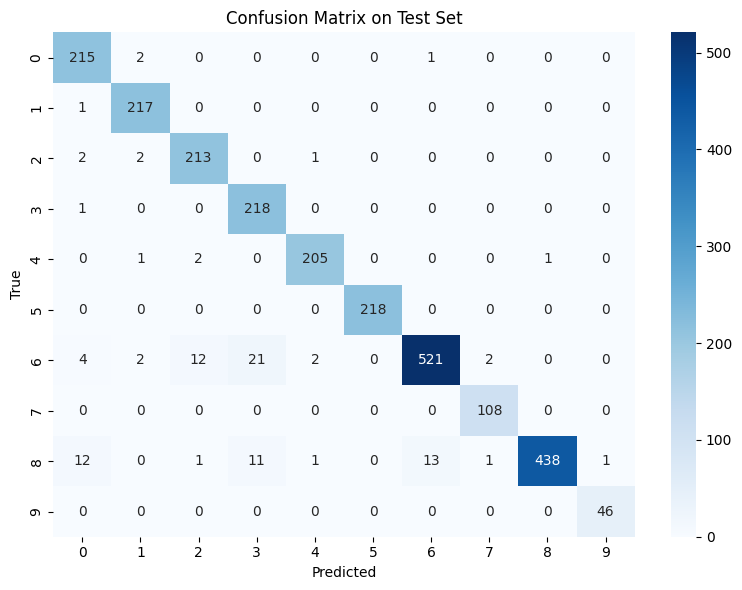

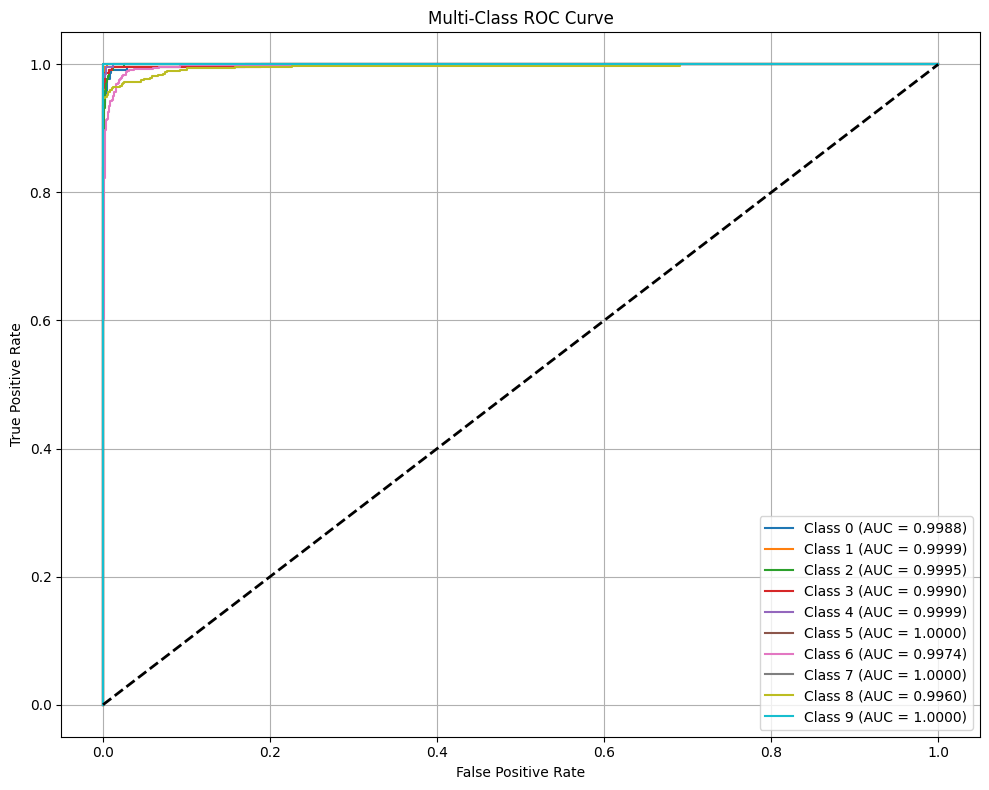

In [18]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = Custom1DCNN_8192(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## ResNet - 1D CNN

In [11]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ResNet1DCNN_8192(nn.Module):
    def __init__(self, input_channels=1, input_length=8192, num_classes=10):
        super().__init__()

        # Initial Conv
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=9, padding=4),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # Residual Blocks + Pooling
        self.block1 = nn.Sequential(
            ResidualBlock1D(32, 32, kernel_size=9, dropout=0.1),
            nn.MaxPool1d(2)
        )
        self.block2 = nn.Sequential(
            ResidualBlock1D(32, 64, kernel_size=7, dropout=0.1),
            nn.MaxPool1d(2)
        )
        self.block3 = nn.Sequential(
            ResidualBlock1D(64, 128, kernel_size=5, dropout=0.2),
            nn.MaxPool1d(2)
        )
        self.block4 = nn.Sequential(
            ResidualBlock1D(128, 256, kernel_size=3, dropout=0.2),
            nn.MaxPool1d(2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock1D(256, 512, kernel_size=3, dropout=0.3),
            nn.MaxPool1d(2)
        )

        # Compute flattened size
        final_length = input_length // (2 ** 5)  # 8192 / 32 = 256
        self.flattened_size = 512 * final_length

        # Fully connected classifier
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        return self.output(x)

# Test run
if __name__ == "__main__":
    model = ResNet1DCNN_8192()
    print(model)

    dummy_input = torch.randn(8, 1, 8192)
    output = model(dummy_input)
    print("Output shape:", output.shape)  # Should be [8, 10]


ResNet1DCNN_8192(
  (initial_conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (skip): Sequential()
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [16]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResNet1DCNN_8192(num_classes=10).to(device)


        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [17]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)



--- Fold 1 ---


Epoch 1: Train Loss=1.1725, Val Loss=0.8041, Train Acc=43.88%, Val Acc=63.76%, Val Macro-F1=0.6571


Epoch 2: Train Loss=0.4120, Val Loss=0.3524, Train Acc=77.25%, Val Acc=85.89%, Val Macro-F1=0.8646


Epoch 3: Train Loss=0.1825, Val Loss=0.1288, Train Acc=89.53%, Val Acc=94.19%, Val Macro-F1=0.9509


Epoch 4: Train Loss=0.0961, Val Loss=0.0857, Train Acc=94.17%, Val Acc=97.00%, Val Macro-F1=0.9749


Epoch 5: Train Loss=0.0667, Val Loss=0.0773, Train Acc=96.06%, Val Acc=96.40%, Val Macro-F1=0.9660


Epoch 6: Train Loss=0.0493, Val Loss=0.0980, Train Acc=97.12%, Val Acc=94.69%, Val Macro-F1=0.9574


Epoch 7: Train Loss=0.0395, Val Loss=0.0576, Train Acc=97.61%, Val Acc=97.40%, Val Macro-F1=0.9772


Epoch 8: Train Loss=0.0353, Val Loss=0.0391, Train Acc=98.03%, Val Acc=98.10%, Val Macro-F1=0.9817


Epoch 9: Train Loss=0.0207, Val Loss=0.0360, Train Acc=98.68%, Val Acc=98.30%, Val Macro-F1=0.9846


Epoch 10: Train Loss=0.0463, Val Loss=0.0554, Train Acc=97.30%, Val Acc=97.90%, Val Macro-F1=0.9791

--- Fold 2 ---


Epoch 1: Train Loss=1.1951, Val Loss=0.8321, Train Acc=42.17%, Val Acc=64.86%, Val Macro-F1=0.6767


Epoch 2: Train Loss=0.4239, Val Loss=0.2844, Train Acc=76.37%, Val Acc=88.19%, Val Macro-F1=0.8921


Epoch 3: Train Loss=0.1787, Val Loss=0.1379, Train Acc=89.19%, Val Acc=92.89%, Val Macro-F1=0.9382


Epoch 4: Train Loss=0.1241, Val Loss=0.1187, Train Acc=92.93%, Val Acc=94.29%, Val Macro-F1=0.9544


Epoch 5: Train Loss=0.0678, Val Loss=0.0790, Train Acc=95.98%, Val Acc=95.30%, Val Macro-F1=0.9587


Epoch 6: Train Loss=0.0477, Val Loss=0.0701, Train Acc=97.12%, Val Acc=96.80%, Val Macro-F1=0.9721


Epoch 7: Train Loss=0.0361, Val Loss=0.0482, Train Acc=97.91%, Val Acc=98.10%, Val Macro-F1=0.9801


Epoch 8: Train Loss=0.0276, Val Loss=0.0517, Train Acc=98.39%, Val Acc=97.70%, Val Macro-F1=0.9822


Epoch 9: Train Loss=0.0250, Val Loss=0.0864, Train Acc=98.52%, Val Acc=97.20%, Val Macro-F1=0.9725


Epoch 10: Train Loss=0.0331, Val Loss=0.0845, Train Acc=98.06%, Val Acc=98.00%, Val Macro-F1=0.9826

--- Fold 3 ---


Epoch 1: Train Loss=1.1905, Val Loss=0.9402, Train Acc=42.46%, Val Acc=59.96%, Val Macro-F1=0.6402


Epoch 2: Train Loss=0.3919, Val Loss=0.3340, Train Acc=77.89%, Val Acc=86.29%, Val Macro-F1=0.8637


Epoch 3: Train Loss=0.1697, Val Loss=0.1633, Train Acc=90.03%, Val Acc=92.99%, Val Macro-F1=0.9345


Epoch 4: Train Loss=0.0907, Val Loss=0.1094, Train Acc=94.80%, Val Acc=94.79%, Val Macro-F1=0.9551


Epoch 5: Train Loss=0.0601, Val Loss=0.0836, Train Acc=96.18%, Val Acc=96.20%, Val Macro-F1=0.9655


Epoch 6: Train Loss=0.0716, Val Loss=0.1631, Train Acc=96.34%, Val Acc=92.29%, Val Macro-F1=0.9286


Epoch 7: Train Loss=0.0389, Val Loss=0.0367, Train Acc=97.62%, Val Acc=98.40%, Val Macro-F1=0.9862


Epoch 8: Train Loss=0.0215, Val Loss=0.0419, Train Acc=98.70%, Val Acc=98.10%, Val Macro-F1=0.9834


Epoch 9: Train Loss=0.0220, Val Loss=0.0608, Train Acc=98.61%, Val Acc=96.80%, Val Macro-F1=0.9709


Epoch 10: Train Loss=0.0209, Val Loss=0.0350, Train Acc=98.66%, Val Acc=98.10%, Val Macro-F1=0.9816

--- Fold 4 ---


Epoch 1: Train Loss=1.1855, Val Loss=0.9407, Train Acc=42.46%, Val Acc=56.56%, Val Macro-F1=0.5918


Epoch 2: Train Loss=0.4198, Val Loss=0.3913, Train Acc=76.29%, Val Acc=83.78%, Val Macro-F1=0.8524


Epoch 3: Train Loss=0.2040, Val Loss=0.1673, Train Acc=88.68%, Val Acc=92.39%, Val Macro-F1=0.9381


Epoch 4: Train Loss=0.0983, Val Loss=0.1002, Train Acc=93.98%, Val Acc=95.40%, Val Macro-F1=0.9610


Epoch 5: Train Loss=0.0691, Val Loss=0.0964, Train Acc=95.58%, Val Acc=95.10%, Val Macro-F1=0.9597


Epoch 6: Train Loss=0.0530, Val Loss=0.1452, Train Acc=96.81%, Val Acc=93.49%, Val Macro-F1=0.9466


Epoch 7: Train Loss=0.0553, Val Loss=0.0699, Train Acc=96.94%, Val Acc=96.70%, Val Macro-F1=0.9705


Epoch 8: Train Loss=0.0294, Val Loss=0.0543, Train Acc=98.05%, Val Acc=97.50%, Val Macro-F1=0.9766


Epoch 9: Train Loss=0.0233, Val Loss=0.0500, Train Acc=98.66%, Val Acc=98.30%, Val Macro-F1=0.9839


Epoch 10: Train Loss=0.0200, Val Loss=0.0908, Train Acc=98.92%, Val Acc=95.80%, Val Macro-F1=0.9644

--- Fold 5 ---


Epoch 1: Train Loss=1.2078, Val Loss=0.9555, Train Acc=41.64%, Val Acc=56.61%, Val Macro-F1=0.5740


Epoch 2: Train Loss=0.4335, Val Loss=0.3189, Train Acc=74.86%, Val Acc=82.46%, Val Macro-F1=0.8529


Epoch 3: Train Loss=0.1875, Val Loss=0.1805, Train Acc=89.03%, Val Acc=90.48%, Val Macro-F1=0.9146


Epoch 4: Train Loss=0.0979, Val Loss=0.0823, Train Acc=93.89%, Val Acc=96.59%, Val Macro-F1=0.9736


Epoch 5: Train Loss=0.0642, Val Loss=0.0569, Train Acc=96.13%, Val Acc=97.29%, Val Macro-F1=0.9743


Epoch 6: Train Loss=0.0413, Val Loss=0.0857, Train Acc=97.25%, Val Acc=96.19%, Val Macro-F1=0.9637


Epoch 7: Train Loss=0.0347, Val Loss=0.0301, Train Acc=97.73%, Val Acc=98.40%, Val Macro-F1=0.9848


Epoch 8: Train Loss=0.0314, Val Loss=0.0657, Train Acc=97.97%, Val Acc=96.89%, Val Macro-F1=0.9747


Epoch 9: Train Loss=0.0459, Val Loss=0.0221, Train Acc=97.50%, Val Acc=98.40%, Val Macro-F1=0.9856


Epoch 10: Train Loss=0.0239, Val Loss=0.0092, Train Acc=98.62%, Val Acc=99.50%, Val Macro-F1=0.9954

--- Fold 6 ---


Epoch 1: Train Loss=1.2098, Val Loss=0.9884, Train Acc=40.90%, Val Acc=56.41%, Val Macro-F1=0.5606


Epoch 2: Train Loss=0.4525, Val Loss=0.3350, Train Acc=74.62%, Val Acc=87.98%, Val Macro-F1=0.8745


Epoch 3: Train Loss=0.1911, Val Loss=0.1994, Train Acc=88.48%, Val Acc=91.48%, Val Macro-F1=0.9230


Epoch 4: Train Loss=0.1027, Val Loss=0.1398, Train Acc=93.73%, Val Acc=93.89%, Val Macro-F1=0.9434


Epoch 5: Train Loss=0.0686, Val Loss=0.0718, Train Acc=95.98%, Val Acc=97.09%, Val Macro-F1=0.9720


Epoch 6: Train Loss=0.0535, Val Loss=0.0815, Train Acc=97.00%, Val Acc=96.79%, Val Macro-F1=0.9710


Epoch 7: Train Loss=0.0498, Val Loss=0.1868, Train Acc=97.38%, Val Acc=94.19%, Val Macro-F1=0.9398


Epoch 8: Train Loss=0.0492, Val Loss=0.0662, Train Acc=97.04%, Val Acc=97.60%, Val Macro-F1=0.9746


Epoch 9: Train Loss=0.0194, Val Loss=0.0606, Train Acc=98.74%, Val Acc=98.10%, Val Macro-F1=0.9785


Epoch 10: Train Loss=0.0278, Val Loss=0.0825, Train Acc=98.28%, Val Acc=97.90%, Val Macro-F1=0.9770

--- Fold 7 ---


Epoch 1: Train Loss=1.2091, Val Loss=0.8587, Train Acc=41.92%, Val Acc=64.13%, Val Macro-F1=0.6564


Epoch 2: Train Loss=0.4203, Val Loss=0.3810, Train Acc=76.77%, Val Acc=81.56%, Val Macro-F1=0.8488


Epoch 3: Train Loss=0.1768, Val Loss=0.2138, Train Acc=89.58%, Val Acc=88.88%, Val Macro-F1=0.9076


Epoch 4: Train Loss=0.1082, Val Loss=0.0918, Train Acc=93.66%, Val Acc=95.69%, Val Macro-F1=0.9645


Epoch 5: Train Loss=0.0679, Val Loss=0.0667, Train Acc=96.03%, Val Acc=95.59%, Val Macro-F1=0.9624


Epoch 6: Train Loss=0.0485, Val Loss=0.0391, Train Acc=97.24%, Val Acc=98.10%, Val Macro-F1=0.9830


Epoch 7: Train Loss=0.0385, Val Loss=0.0398, Train Acc=97.81%, Val Acc=97.70%, Val Macro-F1=0.9804


Epoch 8: Train Loss=0.0332, Val Loss=0.0272, Train Acc=97.92%, Val Acc=98.10%, Val Macro-F1=0.9834


Epoch 9: Train Loss=0.0272, Val Loss=0.0513, Train Acc=98.44%, Val Acc=98.00%, Val Macro-F1=0.9818


Epoch 10: Train Loss=0.0188, Val Loss=0.0285, Train Acc=98.81%, Val Acc=98.20%, Val Macro-F1=0.9858

--- Fold 8 ---


Epoch 1: Train Loss=1.1739, Val Loss=0.8047, Train Acc=44.06%, Val Acc=64.23%, Val Macro-F1=0.6656


Epoch 2: Train Loss=0.4047, Val Loss=0.3768, Train Acc=77.10%, Val Acc=79.56%, Val Macro-F1=0.8362


Epoch 3: Train Loss=0.1590, Val Loss=0.1559, Train Acc=90.23%, Val Acc=91.68%, Val Macro-F1=0.9334


Epoch 4: Train Loss=0.0976, Val Loss=0.1030, Train Acc=94.10%, Val Acc=94.39%, Val Macro-F1=0.9502


Epoch 5: Train Loss=0.0849, Val Loss=0.0997, Train Acc=94.88%, Val Acc=94.19%, Val Macro-F1=0.9521


Epoch 6: Train Loss=0.0603, Val Loss=0.0651, Train Acc=96.39%, Val Acc=96.29%, Val Macro-F1=0.9697


Epoch 7: Train Loss=0.0361, Val Loss=0.0569, Train Acc=97.60%, Val Acc=96.99%, Val Macro-F1=0.9756


Epoch 8: Train Loss=0.0253, Val Loss=0.0426, Train Acc=98.38%, Val Acc=97.80%, Val Macro-F1=0.9792


Epoch 9: Train Loss=0.0282, Val Loss=0.0459, Train Acc=98.50%, Val Acc=97.60%, Val Macro-F1=0.9799


Epoch 10: Train Loss=0.0254, Val Loss=0.0308, Train Acc=98.34%, Val Acc=98.80%, Val Macro-F1=0.9893

--- Fold 9 ---


Epoch 1: Train Loss=1.1642, Val Loss=0.9107, Train Acc=42.68%, Val Acc=64.23%, Val Macro-F1=0.6411


Epoch 2: Train Loss=0.4016, Val Loss=0.3108, Train Acc=77.20%, Val Acc=86.67%, Val Macro-F1=0.8781


Epoch 3: Train Loss=0.1722, Val Loss=0.1423, Train Acc=89.77%, Val Acc=94.19%, Val Macro-F1=0.9507


Epoch 4: Train Loss=0.0975, Val Loss=0.0998, Train Acc=93.98%, Val Acc=95.79%, Val Macro-F1=0.9547


Epoch 5: Train Loss=0.0643, Val Loss=0.0928, Train Acc=96.04%, Val Acc=95.39%, Val Macro-F1=0.9570


Epoch 6: Train Loss=0.0398, Val Loss=0.1207, Train Acc=97.38%, Val Acc=94.89%, Val Macro-F1=0.9569


Epoch 7: Train Loss=0.0721, Val Loss=0.0480, Train Acc=96.42%, Val Acc=98.20%, Val Macro-F1=0.9844


Epoch 8: Train Loss=0.0254, Val Loss=0.0417, Train Acc=98.39%, Val Acc=98.50%, Val Macro-F1=0.9873


Epoch 9: Train Loss=0.0228, Val Loss=0.0427, Train Acc=98.42%, Val Acc=98.40%, Val Macro-F1=0.9852


Epoch 10: Train Loss=0.0216, Val Loss=0.0502, Train Acc=98.68%, Val Acc=99.00%, Val Macro-F1=0.9917

--- Fold 10 ---


Epoch 1: Train Loss=1.2576, Val Loss=0.8675, Train Acc=40.17%, Val Acc=64.83%, Val Macro-F1=0.6592


Epoch 2: Train Loss=0.4408, Val Loss=0.3799, Train Acc=75.87%, Val Acc=82.46%, Val Macro-F1=0.8522


Epoch 3: Train Loss=0.1910, Val Loss=0.1533, Train Acc=88.68%, Val Acc=90.78%, Val Macro-F1=0.9243


Epoch 4: Train Loss=0.0957, Val Loss=0.0955, Train Acc=94.36%, Val Acc=93.99%, Val Macro-F1=0.9524


Epoch 5: Train Loss=0.0780, Val Loss=0.0983, Train Acc=95.43%, Val Acc=94.69%, Val Macro-F1=0.9511


Epoch 6: Train Loss=0.0586, Val Loss=0.0423, Train Acc=96.52%, Val Acc=98.30%, Val Macro-F1=0.9869


Epoch 7: Train Loss=0.0436, Val Loss=0.0378, Train Acc=97.37%, Val Acc=98.10%, Val Macro-F1=0.9843


Epoch 8: Train Loss=0.0312, Val Loss=0.0222, Train Acc=98.22%, Val Acc=98.90%, Val Macro-F1=0.9911


Epoch 9: Train Loss=0.0284, Val Loss=0.0242, Train Acc=98.36%, Val Acc=98.60%, Val Macro-F1=0.9859


Epoch 10: Train Loss=0.0259, Val Loss=0.0118, Train Acc=98.42%, Val Acc=99.40%, Val Macro-F1=0.9951


In [18]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             97.2955           97.8979      0.0463    0.0554   
1   Fold 2             98.0634           97.9980      0.0331    0.0845   
2   Fold 3             98.6644           98.0981      0.0209    0.0350   
3   Fold 4             98.9204           95.7958      0.0200    0.0908   
4   Fold 5             98.6201           99.4990      0.0239    0.0092   
5   Fold 6             98.2751           97.8958      0.0278    0.0825   
6   Fold 7             98.8093           98.1964      0.0188    0.0285   
7   Fold 8             98.3419           98.7976      0.0254    0.0308   
8   Fold 9             98.6757           98.9980      0.0216    0.0502   
9  Fold 10             98.4198           99.3988      0.0259    0.0118   

   Val Macro F1  
0        0.9791  
1        0.9826  
2        0.9816  
3        0.9644  
4        0.9954  
5        0.9770  
6        0.9858  
7        0.9893 

In [19]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1

Best fold is fold 5

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9954    0.9862    0.9908       218
           1     0.9818    0.9908    0.9863       218
           2     0.9600    0.9908    0.9752       218
           3     1.0000    0.9909    0.9954       219
           4     0.9674    0.9952    0.9811       209
           5     0.9954    1.0000    0.9977       218
           6     0.9874    0.9734    0.9804       564
           7     0.9730    1.0000    0.9863       108
           8     0.9958    0.9812    0.9884       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9864      2496
   macro avg     0.9856    0.9909    0.9882      2496
weighted avg     0.9866    0.9864    0.9864      2496



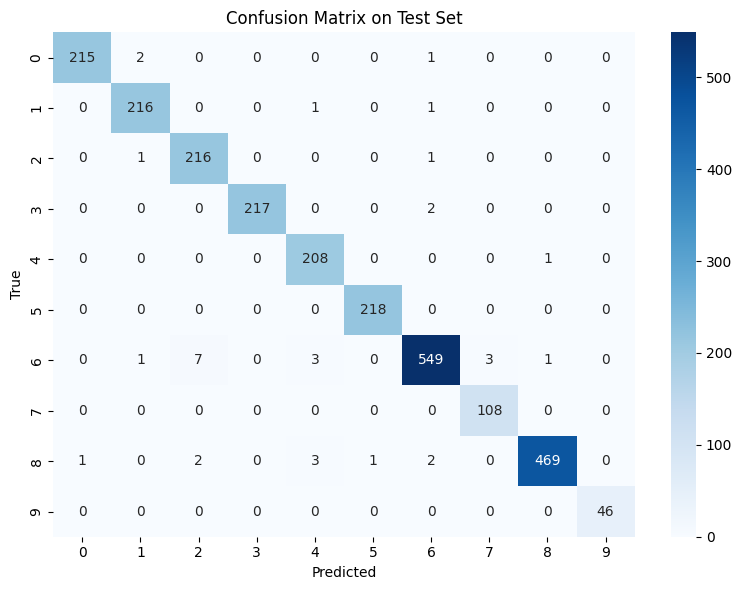

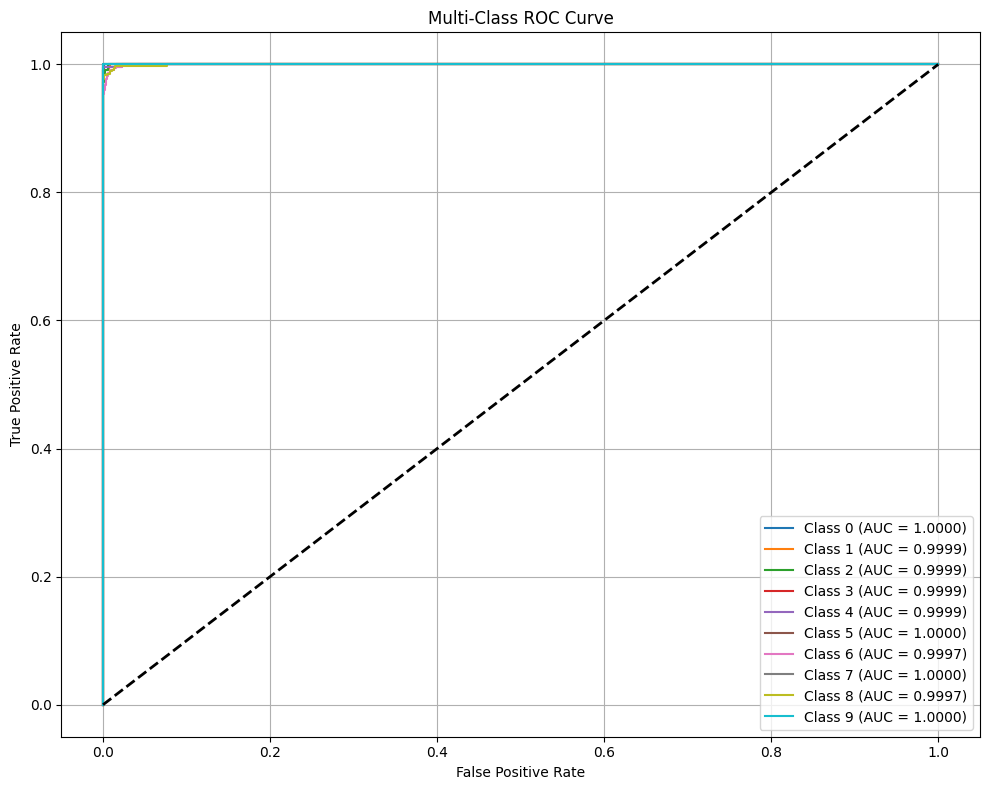

In [21]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = ResNet1DCNN_8192(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## Inception Time

In [24]:
# class InceptionBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_sizes=[9, 19, 39], bottleneck_channels=32):
#         super().__init__()
        
#         self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False) \
#             if in_channels > 1 else nn.Identity()

#         self.conv_layers = nn.ModuleList([
#             nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels, out_channels, kernel_size=k, padding=k//2, bias=False)
#             for k in kernel_sizes
#         ])
        
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
#             nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
#         )

#         self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x_bottleneck = self.bottleneck(x)
#         conv_outputs = [conv(x_bottleneck) for conv in self.conv_layers]
#         maxpool_out = self.maxpool_conv(x)
#         out = torch.cat(conv_outputs + [maxpool_out], dim=1)
#         return self.relu(self.bn(out))


# class InceptionBlockResidual(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.inception = InceptionBlock(in_channels, out_channels)
#         self.shortcut = nn.Sequential(
#             nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False),
#             nn.BatchNorm1d(out_channels * 4)
#         ) if in_channels != out_channels * 4 else nn.Identity()

#         self.relu = nn.ReLU()

#     def forward(self, x):
#         return self.relu(self.inception(x) + self.shortcut(x))


# class InceptionTime(nn.Module):
#     def __init__(self, input_channels=1, input_length=8192, num_classes=10, num_blocks=3):
#         super().__init__()
#         blocks = []
#         in_channels = input_channels
#         for _ in range(num_blocks):
#             block = InceptionBlockResidual(in_channels, out_channels=32)
#             blocks.append(block)
#             in_channels = 128  # After block, out_channels * 4

#         self.blocks = nn.Sequential(*blocks)
#         self.gap = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(in_channels, num_classes)

#     def forward(self, x):
#         x = self.blocks(x)
#         x = self.gap(x).squeeze(-1)
#         return self.fc(x)

# if __name__ == "__main__":
#     model = InceptionTime(input_channels=1, input_length=8192, num_classes=10)
#     x = torch.randn(8, 1, 8192)  # batch of 8
#     y = model(x)
#     print(y.shape)  # Expected: [8, 10]



torch.Size([8, 10])


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionResBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[9, 19, 39], bottleneck_channels=32):
        super().__init__()
        self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1) \
            if in_channels > 1 else nn.Identity()
        
        self.conv_branches = nn.ModuleList([
            nn.Conv1d(bottleneck_channels if in_channels > 1 else in_channels, out_channels, k, padding=k//2)
            for k in kernel_sizes
        ])
        
        self.pool_branch = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
        )

        self.bn = nn.BatchNorm1d(out_channels * (len(kernel_sizes) + 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x_bottleneck = self.bottleneck(x)
        branches = [conv(x_bottleneck) for conv in self.conv_branches]
        branches.append(self.pool_branch(x))
        out = torch.cat(branches, dim=1)
        return self.relu(self.bn(out))

class ResidualInceptionTime1D(nn.Module):
    def __init__(self, input_channels=1, input_length=8192, num_classes=10):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=120, stride=4),  # Large receptive field
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.block1 = InceptionResBlock1D(64, 64)
        self.block2 = InceptionResBlock1D(256, 128)
        self.block3 = InceptionResBlock1D(512, 256)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)  # out: 256
        x = self.block2(x)  # out: 512
        x = self.block3(x)  # out: 1024
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)

# Test it
if __name__ == "__main__":
    model = ResidualInceptionTime1D()
    dummy_input = torch.randn(8, 1, 8192)
    print(model(dummy_input).shape)  # Expected: torch.Size([8, 10])


torch.Size([8, 10])


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [34]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ResidualInceptionTime1D(num_classes=10).to(device)


        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [35]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)



--- Fold 1 ---


Epoch 1: Train Loss=1.4578, Val Loss=1.8815, Train Acc=27.00%, Val Acc=21.22%, Val Macro-F1=0.2485


Epoch 2: Train Loss=0.9673, Val Loss=1.4545, Train Acc=46.82%, Val Acc=39.54%, Val Macro-F1=0.4173


Epoch 3: Train Loss=0.8170, Val Loss=1.1149, Train Acc=53.78%, Val Acc=49.25%, Val Macro-F1=0.4987


Epoch 4: Train Loss=0.7183, Val Loss=1.2531, Train Acc=58.43%, Val Acc=47.15%, Val Macro-F1=0.5086


Epoch 5: Train Loss=0.6061, Val Loss=2.9618, Train Acc=63.36%, Val Acc=25.73%, Val Macro-F1=0.2313


Epoch 6: Train Loss=0.5784, Val Loss=1.1917, Train Acc=65.39%, Val Acc=51.75%, Val Macro-F1=0.5105


Epoch 7: Train Loss=0.5214, Val Loss=1.4647, Train Acc=68.36%, Val Acc=42.24%, Val Macro-F1=0.4545


Epoch 8: Train Loss=0.4546, Val Loss=1.6416, Train Acc=71.89%, Val Acc=42.94%, Val Macro-F1=0.4628


Epoch 9: Train Loss=0.4075, Val Loss=1.1440, Train Acc=74.48%, Val Acc=56.66%, Val Macro-F1=0.5591


Epoch 10: Train Loss=0.4196, Val Loss=2.0263, Train Acc=75.19%, Val Acc=35.34%, Val Macro-F1=0.4150

--- Fold 2 ---


Epoch 1: Train Loss=1.4319, Val Loss=1.9054, Train Acc=28.55%, Val Acc=23.12%, Val Macro-F1=0.2325


Epoch 2: Train Loss=0.9414, Val Loss=2.1612, Train Acc=48.25%, Val Acc=25.43%, Val Macro-F1=0.2379


Epoch 3: Train Loss=0.7967, Val Loss=1.1267, Train Acc=55.24%, Val Acc=47.95%, Val Macro-F1=0.4927


Epoch 4: Train Loss=0.7132, Val Loss=2.5451, Train Acc=60.07%, Val Acc=30.33%, Val Macro-F1=0.3062


Epoch 5: Train Loss=0.6053, Val Loss=0.9013, Train Acc=63.80%, Val Acc=56.66%, Val Macro-F1=0.6002


Epoch 6: Train Loss=0.5621, Val Loss=0.9908, Train Acc=66.30%, Val Acc=55.46%, Val Macro-F1=0.5284


Epoch 7: Train Loss=0.5157, Val Loss=1.3500, Train Acc=69.73%, Val Acc=48.05%, Val Macro-F1=0.5094


Epoch 8: Train Loss=0.4707, Val Loss=0.9744, Train Acc=71.57%, Val Acc=55.56%, Val Macro-F1=0.5815


Epoch 9: Train Loss=0.4405, Val Loss=4.3037, Train Acc=73.37%, Val Acc=18.02%, Val Macro-F1=0.1699


Epoch 10: Train Loss=0.3917, Val Loss=1.9055, Train Acc=75.23%, Val Acc=44.24%, Val Macro-F1=0.4671

--- Fold 3 ---


Epoch 1: Train Loss=1.4368, Val Loss=1.6536, Train Acc=29.72%, Val Acc=34.03%, Val Macro-F1=0.3386


Epoch 2: Train Loss=0.9457, Val Loss=1.4100, Train Acc=49.49%, Val Acc=41.44%, Val Macro-F1=0.4286


Epoch 3: Train Loss=0.7724, Val Loss=1.5660, Train Acc=56.54%, Val Acc=40.84%, Val Macro-F1=0.4168


Epoch 4: Train Loss=0.6627, Val Loss=1.4365, Train Acc=60.22%, Val Acc=45.05%, Val Macro-F1=0.4299


Epoch 5: Train Loss=0.6172, Val Loss=1.4262, Train Acc=62.98%, Val Acc=41.04%, Val Macro-F1=0.4803


Epoch 6: Train Loss=0.5542, Val Loss=1.9354, Train Acc=66.32%, Val Acc=34.03%, Val Macro-F1=0.3624


Epoch 7: Train Loss=0.5237, Val Loss=1.2021, Train Acc=68.19%, Val Acc=51.25%, Val Macro-F1=0.4900


Epoch 8: Train Loss=0.4668, Val Loss=0.7447, Train Acc=70.40%, Val Acc=64.26%, Val Macro-F1=0.6751


Epoch 9: Train Loss=0.4155, Val Loss=1.7833, Train Acc=74.00%, Val Acc=43.74%, Val Macro-F1=0.4484


Epoch 10: Train Loss=0.3690, Val Loss=1.5591, Train Acc=76.87%, Val Acc=52.75%, Val Macro-F1=0.5421

--- Fold 4 ---


Epoch 1: Train Loss=1.4420, Val Loss=2.6114, Train Acc=27.48%, Val Acc=11.41%, Val Macro-F1=0.1272


Epoch 2: Train Loss=0.9268, Val Loss=1.9508, Train Acc=47.62%, Val Acc=31.03%, Val Macro-F1=0.3320


Epoch 3: Train Loss=0.7961, Val Loss=1.7835, Train Acc=55.07%, Val Acc=27.63%, Val Macro-F1=0.2752


Epoch 4: Train Loss=0.7024, Val Loss=1.2288, Train Acc=58.66%, Val Acc=43.04%, Val Macro-F1=0.4557


Epoch 5: Train Loss=0.6245, Val Loss=1.5638, Train Acc=62.23%, Val Acc=40.04%, Val Macro-F1=0.4166


Epoch 6: Train Loss=0.5466, Val Loss=1.0102, Train Acc=65.71%, Val Acc=46.95%, Val Macro-F1=0.4878


Epoch 7: Train Loss=0.5223, Val Loss=0.8632, Train Acc=68.12%, Val Acc=59.96%, Val Macro-F1=0.6384


Epoch 8: Train Loss=0.4655, Val Loss=0.7596, Train Acc=70.92%, Val Acc=62.86%, Val Macro-F1=0.6488


Epoch 9: Train Loss=0.4329, Val Loss=1.1223, Train Acc=72.92%, Val Acc=53.45%, Val Macro-F1=0.5575


Epoch 10: Train Loss=0.4031, Val Loss=1.0954, Train Acc=74.12%, Val Acc=51.95%, Val Macro-F1=0.5114

--- Fold 5 ---


Epoch 1: Train Loss=1.4096, Val Loss=1.8138, Train Acc=29.78%, Val Acc=27.76%, Val Macro-F1=0.2816


Epoch 2: Train Loss=0.9503, Val Loss=1.4725, Train Acc=48.93%, Val Acc=36.97%, Val Macro-F1=0.4058


Epoch 3: Train Loss=0.8043, Val Loss=1.1442, Train Acc=55.44%, Val Acc=44.09%, Val Macro-F1=0.4642


Epoch 4: Train Loss=0.6783, Val Loss=1.0676, Train Acc=60.64%, Val Acc=52.51%, Val Macro-F1=0.5011


Epoch 5: Train Loss=0.5929, Val Loss=1.4285, Train Acc=65.13%, Val Acc=45.29%, Val Macro-F1=0.4794


Epoch 6: Train Loss=0.5288, Val Loss=1.5092, Train Acc=68.57%, Val Acc=47.70%, Val Macro-F1=0.4880


Epoch 7: Train Loss=0.4879, Val Loss=1.1608, Train Acc=70.91%, Val Acc=50.90%, Val Macro-F1=0.5507


Epoch 8: Train Loss=0.4656, Val Loss=1.0932, Train Acc=71.59%, Val Acc=54.61%, Val Macro-F1=0.5739


Epoch 9: Train Loss=0.4048, Val Loss=1.0115, Train Acc=75.55%, Val Acc=58.52%, Val Macro-F1=0.5993


Epoch 10: Train Loss=0.3813, Val Loss=2.2321, Train Acc=75.81%, Val Acc=37.27%, Val Macro-F1=0.3933

--- Fold 6 ---


Epoch 1: Train Loss=1.4648, Val Loss=2.0748, Train Acc=29.11%, Val Acc=18.04%, Val Macro-F1=0.1720


Epoch 2: Train Loss=0.9465, Val Loss=1.8587, Train Acc=48.55%, Val Acc=30.56%, Val Macro-F1=0.3433


Epoch 3: Train Loss=0.7968, Val Loss=1.6247, Train Acc=55.59%, Val Acc=31.36%, Val Macro-F1=0.3305


Epoch 4: Train Loss=0.7163, Val Loss=1.3195, Train Acc=58.39%, Val Acc=43.49%, Val Macro-F1=0.4337


Epoch 5: Train Loss=0.6370, Val Loss=1.3397, Train Acc=61.43%, Val Acc=42.59%, Val Macro-F1=0.4646


Epoch 6: Train Loss=0.5787, Val Loss=1.1456, Train Acc=64.76%, Val Acc=50.80%, Val Macro-F1=0.5335


Epoch 7: Train Loss=0.5209, Val Loss=1.2676, Train Acc=66.88%, Val Acc=46.09%, Val Macro-F1=0.5110


Epoch 8: Train Loss=0.5016, Val Loss=3.3202, Train Acc=69.10%, Val Acc=27.15%, Val Macro-F1=0.2350


Epoch 9: Train Loss=0.4425, Val Loss=1.1765, Train Acc=72.22%, Val Acc=53.71%, Val Macro-F1=0.5603


Epoch 10: Train Loss=0.4135, Val Loss=1.7252, Train Acc=74.25%, Val Acc=44.39%, Val Macro-F1=0.4626

--- Fold 7 ---


Epoch 1: Train Loss=1.4198, Val Loss=1.5224, Train Acc=29.19%, Val Acc=32.67%, Val Macro-F1=0.3586


Epoch 2: Train Loss=0.8993, Val Loss=2.0397, Train Acc=50.24%, Val Acc=32.87%, Val Macro-F1=0.3517


Epoch 3: Train Loss=0.7699, Val Loss=1.9645, Train Acc=56.69%, Val Acc=33.57%, Val Macro-F1=0.3312


Epoch 4: Train Loss=0.6537, Val Loss=2.1189, Train Acc=61.33%, Val Acc=37.27%, Val Macro-F1=0.3656


Epoch 5: Train Loss=0.5837, Val Loss=1.0249, Train Acc=65.77%, Val Acc=51.60%, Val Macro-F1=0.5478


Epoch 6: Train Loss=0.5183, Val Loss=2.3567, Train Acc=68.34%, Val Acc=28.06%, Val Macro-F1=0.3368


Epoch 7: Train Loss=0.4837, Val Loss=1.2541, Train Acc=70.64%, Val Acc=51.00%, Val Macro-F1=0.5633


Epoch 8: Train Loss=0.4232, Val Loss=1.1451, Train Acc=73.36%, Val Acc=57.01%, Val Macro-F1=0.5772


Epoch 9: Train Loss=0.3833, Val Loss=2.0338, Train Acc=76.13%, Val Acc=38.68%, Val Macro-F1=0.3842


Epoch 10: Train Loss=0.3734, Val Loss=1.2499, Train Acc=77.18%, Val Acc=47.09%, Val Macro-F1=0.4739

--- Fold 8 ---


Epoch 1: Train Loss=1.4691, Val Loss=1.8771, Train Acc=27.29%, Val Acc=23.05%, Val Macro-F1=0.2692


Epoch 2: Train Loss=0.9736, Val Loss=2.6734, Train Acc=46.71%, Val Acc=18.34%, Val Macro-F1=0.2492


Epoch 3: Train Loss=0.7978, Val Loss=2.5944, Train Acc=55.48%, Val Acc=24.45%, Val Macro-F1=0.2169


Epoch 4: Train Loss=0.7324, Val Loss=1.0821, Train Acc=58.45%, Val Acc=54.81%, Val Macro-F1=0.5525


Epoch 5: Train Loss=0.6445, Val Loss=0.9885, Train Acc=62.29%, Val Acc=55.51%, Val Macro-F1=0.5635


Epoch 6: Train Loss=0.5823, Val Loss=4.5392, Train Acc=65.76%, Val Acc=16.13%, Val Macro-F1=0.1617


Epoch 7: Train Loss=0.5235, Val Loss=1.1152, Train Acc=68.32%, Val Acc=56.81%, Val Macro-F1=0.5757


Epoch 8: Train Loss=0.4738, Val Loss=1.0733, Train Acc=71.05%, Val Acc=57.01%, Val Macro-F1=0.5781


Epoch 9: Train Loss=0.4761, Val Loss=0.8341, Train Acc=71.53%, Val Acc=61.72%, Val Macro-F1=0.6777


Epoch 10: Train Loss=0.3958, Val Loss=1.7815, Train Acc=75.31%, Val Acc=41.48%, Val Macro-F1=0.4535

--- Fold 9 ---


Epoch 1: Train Loss=1.4412, Val Loss=2.3767, Train Acc=26.70%, Val Acc=14.53%, Val Macro-F1=0.1374


Epoch 2: Train Loss=0.9482, Val Loss=4.7414, Train Acc=46.73%, Val Acc=5.81%, Val Macro-F1=0.0347


Epoch 3: Train Loss=0.8101, Val Loss=1.6895, Train Acc=53.56%, Val Acc=33.67%, Val Macro-F1=0.3680


Epoch 4: Train Loss=0.7180, Val Loss=1.6880, Train Acc=57.67%, Val Acc=34.77%, Val Macro-F1=0.3811


Epoch 5: Train Loss=0.6464, Val Loss=1.9593, Train Acc=61.06%, Val Acc=32.57%, Val Macro-F1=0.3820


Epoch 6: Train Loss=0.6308, Val Loss=2.8475, Train Acc=61.95%, Val Acc=29.16%, Val Macro-F1=0.2905


Epoch 7: Train Loss=0.5536, Val Loss=1.7474, Train Acc=65.88%, Val Acc=42.89%, Val Macro-F1=0.3879


Epoch 8: Train Loss=0.4743, Val Loss=1.0338, Train Acc=69.53%, Val Acc=51.80%, Val Macro-F1=0.5381


Epoch 9: Train Loss=0.4733, Val Loss=1.0561, Train Acc=71.86%, Val Acc=55.81%, Val Macro-F1=0.5734


Epoch 10: Train Loss=0.4294, Val Loss=1.2557, Train Acc=73.24%, Val Acc=53.81%, Val Macro-F1=0.5674

--- Fold 10 ---


Epoch 1: Train Loss=1.4639, Val Loss=2.6310, Train Acc=27.38%, Val Acc=13.93%, Val Macro-F1=0.1693


Epoch 2: Train Loss=0.9603, Val Loss=1.3525, Train Acc=47.33%, Val Acc=39.98%, Val Macro-F1=0.4407


Epoch 3: Train Loss=0.7878, Val Loss=1.0781, Train Acc=54.91%, Val Acc=50.50%, Val Macro-F1=0.5489


Epoch 4: Train Loss=0.7090, Val Loss=1.5685, Train Acc=58.44%, Val Acc=29.26%, Val Macro-F1=0.2773


Epoch 5: Train Loss=0.6424, Val Loss=2.0363, Train Acc=61.58%, Val Acc=35.57%, Val Macro-F1=0.3820


Epoch 6: Train Loss=0.5796, Val Loss=1.1525, Train Acc=65.23%, Val Acc=50.40%, Val Macro-F1=0.5528


Epoch 7: Train Loss=0.5219, Val Loss=2.1580, Train Acc=68.84%, Val Acc=30.76%, Val Macro-F1=0.3900


Epoch 8: Train Loss=0.4787, Val Loss=1.1517, Train Acc=70.91%, Val Acc=52.71%, Val Macro-F1=0.5854


Epoch 9: Train Loss=0.4367, Val Loss=3.0640, Train Acc=72.86%, Val Acc=40.78%, Val Macro-F1=0.3176


Epoch 10: Train Loss=0.4059, Val Loss=1.4884, Train Acc=74.16%, Val Acc=44.29%, Val Macro-F1=0.4542


In [36]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             75.1920           35.3353      0.4196    2.0263   
1   Fold 2             75.2254           44.2442      0.3917    1.9055   
2   Fold 3             76.8726           52.7528      0.3690    1.5591   
3   Fold 4             74.1235           51.9520      0.4031    1.0954   
4   Fold 5             75.8068           37.2745      0.3813    2.2321   
5   Fold 6             74.2488           44.3888      0.4135    1.7252   
6   Fold 7             77.1756           47.0942      0.3734    1.2499   
7   Fold 8             75.3060           41.4830      0.3958    1.7815   
8   Fold 9             73.2361           53.8076      0.4294    1.2557   
9  Fold 10             74.1598           44.2886      0.4059    1.4884   

   Val Macro F1  
0        0.4150  
1        0.4671  
2        0.5421  
3        0.5114  
4        0.3933  
5        0.4626  
6        0.4739  
7        0.4535 

In [37]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1

Best fold is fold 9

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.2743    0.8532    0.4152       218
           1     0.5345    0.8532    0.6572       218
           2     0.4227    0.1881    0.2603       218
           3     0.9533    0.4658    0.6258       219
           4     0.4901    0.7129    0.5809       209
           5     0.5826    0.8899    0.7042       218
           6     0.9839    0.1082    0.1949       564
           7     0.9009    0.9259    0.9132       108
           8     0.8430    0.7301    0.7825       478
           9     0.8095    0.7391    0.7727        46

    accuracy                         0.5617      2496
   macro avg     0.6795    0.6466    0.5907      2496
weighted avg     0.7208    0.5617    0.5291      2496



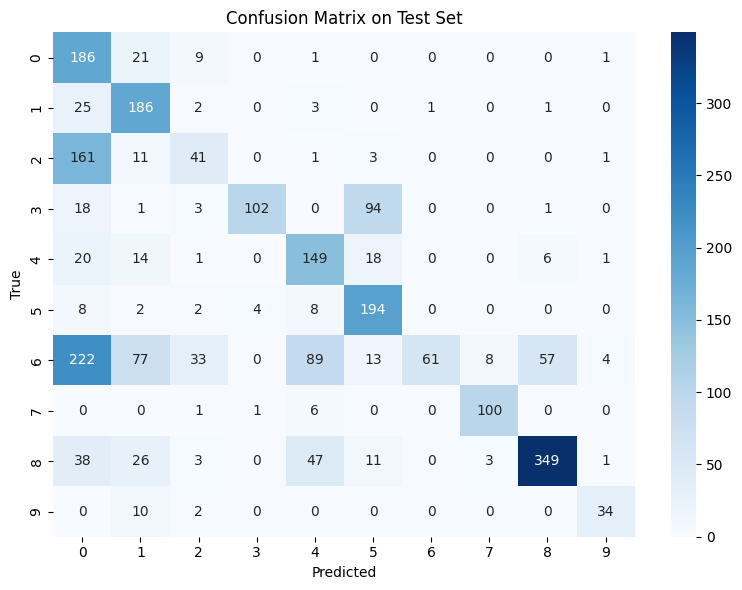

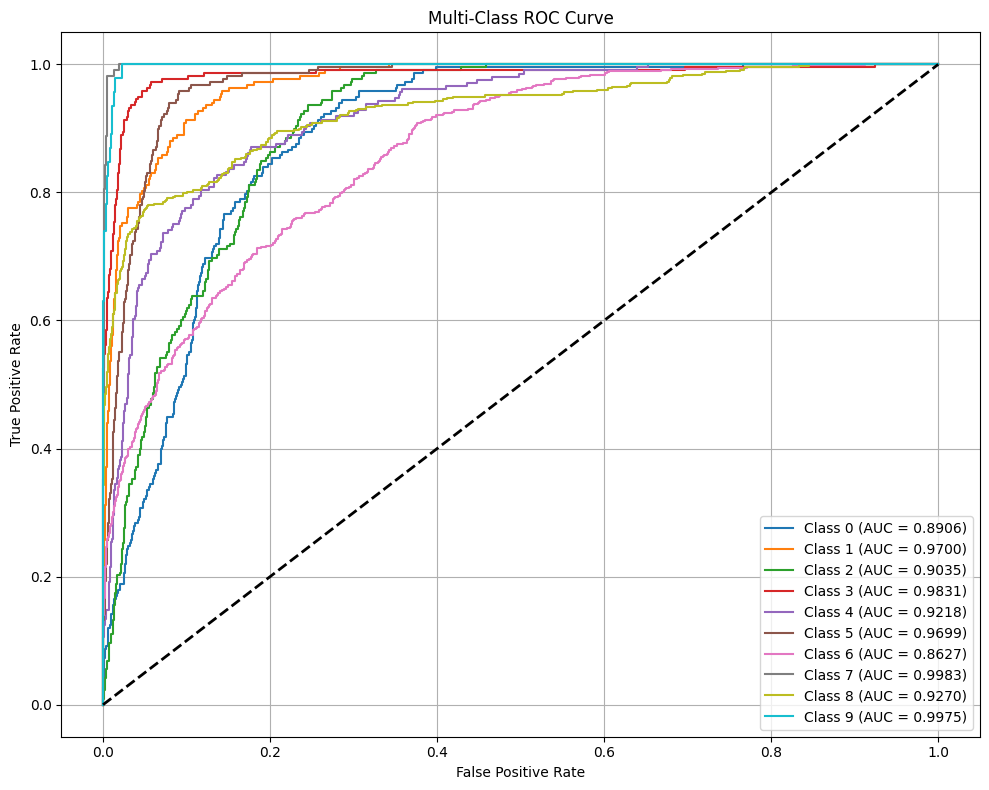

In [38]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = ResidualInceptionTime1D(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## XResNet1D Model 

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock1D, self).__init__()
        self.stride = stride
        self.equal_in_out = in_channels == out_channels and stride == 1

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(out_channels)

        self.downsample = nn.Sequential()
        if not self.equal_in_out:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.equal_in_out:
            residual = self.downsample(x)
        return F.relu(out + residual)

class XResNet1D(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(XResNet1D, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock1D(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):  # x shape: (B, C=1, T=8192)
        x = self.stem(x)             # → (B, 64, ~2048)
        x = self.layer1(x)           # → (B, 128, ~1024)
        x = self.layer2(x)           # → (B, 256, ~512)
        x = self.layer3(x)           # → (B, 512, ~256)
        x = self.global_pool(x)      # → (B, 512, 1)
        x = x.squeeze(-1)            # → (B, 512)
        return self.fc(x)            # → (B, num_classes)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ResidualBlock1D(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super().__init__()
#         self.equal_in_out = in_channels == out_channels and stride == 1

#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm1d(out_channels)

#         self.downsample = nn.Sequential()
#         if not self.equal_in_out:
#             self.downsample = nn.Sequential(
#                 nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm1d(out_channels)
#             )

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))

#         if not self.equal_in_out:
#             identity = self.downsample(x)

#         return self.relu(out + identity)


# class XResNet1D(nn.Module):
#     def __init__(self, num_classes=10, input_channels=1):
#         super().__init__()

#         self.stem = nn.Sequential(
#             nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),  # → (B, 64, ~4096)
#             nn.BatchNorm1d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # → (B, 64, ~2048)
#         )

#         self.layer1 = self._make_layer(64, 128, num_blocks=2, stride=2)   # → (B, 128, ~1024)
#         self.layer2 = self._make_layer(128, 256, num_blocks=2, stride=2)  # → (B, 256, ~512)
#         self.layer3 = self._make_layer(256, 512, num_blocks=2, stride=2)  # → (B, 512, ~256)

#         self.global_pool = nn.AdaptiveAvgPool1d(1)  # → (B, 512, 1)
#         self.fc = nn.Linear(512, num_classes)       # → (B, num_classes)

#     def _make_layer(self, in_channels, out_channels, num_blocks, stride):
#         layers = [ResidualBlock1D(in_channels, out_channels, stride=stride)]
#         for _ in range(1, num_blocks):
#             layers.append(ResidualBlock1D(out_channels, out_channels))
#         return nn.Sequential(*layers)

#     def forward(self, x):  # Input shape: (B, 1, 8192)
#         x = self.stem(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.global_pool(x).squeeze(-1)  # (B, 512)
#         return self.fc(x)


In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
import torch
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        # ======== Training ========
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(1) == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # ======== Validation ========
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == y_batch).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        # ======== Logging & Saving ========
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
              f"Val Macro-F1: {macro_f1:.4f}")

    return history


In [127]:
import torch
import gc
import numpy as np
from collections import defaultdict
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n=== Fold {fold + 1} ===")

        # ======== Split Data ========
        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # ======== Class Weights & Sampler ========
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        # ======== Datasets & Loaders ========
        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset   = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # ======== Model Setup ========
        model = XResNet1D(num_classes=10).to(device)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # ======== Train & Collect History ========
        history = train_model(model, train_loader, val_loader, criterion, optimizer,
                              device, num_epochs=num_epochs, fold=fold)

        for k in history:
            cv_history[k].append(history[k][-1])  # Append last epoch stat

        # ======== Cleanup to Prevent OOM ========
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return cv_history


In [128]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [129]:
import gc
torch.cuda.empty_cache()
gc.collect()


4319

In [130]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)



=== Fold 1 ===


Epoch  1 | Train Loss: 0.9897 | Val Loss: 1.2702 | Train Acc: 51.56% | Val Acc: 43.94% | Val Macro-F1: 0.4621


Epoch  2 | Train Loss: 0.5416 | Val Loss: 1.2679 | Train Acc: 73.29% | Val Acc: 45.95% | Val Macro-F1: 0.4762


Epoch  3 | Train Loss: 0.3370 | Val Loss: 1.0363 | Train Acc: 83.85% | Val Acc: 57.56% | Val Macro-F1: 0.6196


Epoch  4 | Train Loss: 0.2184 | Val Loss: 0.9141 | Train Acc: 88.96% | Val Acc: 66.27% | Val Macro-F1: 0.6849


Epoch  5 | Train Loss: 0.1599 | Val Loss: 0.7430 | Train Acc: 91.55% | Val Acc: 71.17% | Val Macro-F1: 0.7099


Epoch  6 | Train Loss: 0.1347 | Val Loss: 0.8009 | Train Acc: 93.42% | Val Acc: 72.67% | Val Macro-F1: 0.7563


Epoch  7 | Train Loss: 0.1004 | Val Loss: 0.5444 | Train Acc: 94.82% | Val Acc: 78.18% | Val Macro-F1: 0.8040


Epoch  8 | Train Loss: 0.0601 | Val Loss: 0.6888 | Train Acc: 96.86% | Val Acc: 75.78% | Val Macro-F1: 0.7693


Epoch  9 | Train Loss: 0.0465 | Val Loss: 0.9491 | Train Acc: 97.81% | Val Acc: 74.17% | Val Macro-F1: 0.7450


Epoch 10 | Train Loss: 0.0447 | Val Loss: 0.4122 | Train Acc: 97.95% | Val Acc: 85.09% | Val Macro-F1: 0.8532

=== Fold 2 ===


Epoch  1 | Train Loss: 1.0000 | Val Loss: 1.3584 | Train Acc: 49.45% | Val Acc: 43.04% | Val Macro-F1: 0.4092


Epoch  2 | Train Loss: 0.5518 | Val Loss: 1.1693 | Train Acc: 72.68% | Val Acc: 54.05% | Val Macro-F1: 0.5923


Epoch  3 | Train Loss: 0.3381 | Val Loss: 0.7555 | Train Acc: 83.74% | Val Acc: 69.87% | Val Macro-F1: 0.7264


Epoch  4 | Train Loss: 0.2257 | Val Loss: 0.9651 | Train Acc: 88.24% | Val Acc: 65.97% | Val Macro-F1: 0.6595


Epoch  5 | Train Loss: 0.1510 | Val Loss: 0.7558 | Train Acc: 91.70% | Val Acc: 71.17% | Val Macro-F1: 0.7313


Epoch  6 | Train Loss: 0.1257 | Val Loss: 0.4671 | Train Acc: 93.50% | Val Acc: 82.68% | Val Macro-F1: 0.8305


Epoch  7 | Train Loss: 0.0871 | Val Loss: 0.7987 | Train Acc: 95.41% | Val Acc: 73.67% | Val Macro-F1: 0.7348


Epoch  8 | Train Loss: 0.0574 | Val Loss: 0.4052 | Train Acc: 97.05% | Val Acc: 84.88% | Val Macro-F1: 0.8558


Epoch  9 | Train Loss: 0.0517 | Val Loss: 1.0907 | Train Acc: 97.61% | Val Acc: 64.26% | Val Macro-F1: 0.6770


Epoch 10 | Train Loss: 0.0489 | Val Loss: 0.3759 | Train Acc: 97.46% | Val Acc: 85.89% | Val Macro-F1: 0.8551

=== Fold 3 ===


Epoch  1 | Train Loss: 1.0216 | Val Loss: 1.4517 | Train Acc: 47.91% | Val Acc: 36.14% | Val Macro-F1: 0.3886


Epoch  2 | Train Loss: 0.5953 | Val Loss: 1.2863 | Train Acc: 71.14% | Val Acc: 46.25% | Val Macro-F1: 0.4930


Epoch  3 | Train Loss: 0.3626 | Val Loss: 1.0755 | Train Acc: 82.05% | Val Acc: 53.35% | Val Macro-F1: 0.5711


Epoch  4 | Train Loss: 0.2449 | Val Loss: 0.7256 | Train Acc: 87.82% | Val Acc: 74.17% | Val Macro-F1: 0.7332


Epoch  5 | Train Loss: 0.1613 | Val Loss: 0.6390 | Train Acc: 91.52% | Val Acc: 76.68% | Val Macro-F1: 0.7814


Epoch  6 | Train Loss: 0.1343 | Val Loss: 0.5471 | Train Acc: 93.23% | Val Acc: 80.78% | Val Macro-F1: 0.8193


Epoch  7 | Train Loss: 0.0894 | Val Loss: 0.7041 | Train Acc: 95.30% | Val Acc: 72.77% | Val Macro-F1: 0.7534


Epoch  8 | Train Loss: 0.0755 | Val Loss: 0.8484 | Train Acc: 96.00% | Val Acc: 72.97% | Val Macro-F1: 0.7434


Epoch  9 | Train Loss: 0.0568 | Val Loss: 0.4724 | Train Acc: 97.08% | Val Acc: 85.49% | Val Macro-F1: 0.8616


Epoch 10 | Train Loss: 0.0479 | Val Loss: 1.1373 | Train Acc: 97.65% | Val Acc: 61.56% | Val Macro-F1: 0.6811

=== Fold 4 ===


Epoch  1 | Train Loss: 1.0213 | Val Loss: 1.3504 | Train Acc: 48.96% | Val Acc: 39.84% | Val Macro-F1: 0.4458


Epoch  2 | Train Loss: 0.5425 | Val Loss: 1.7890 | Train Acc: 73.63% | Val Acc: 42.04% | Val Macro-F1: 0.4047


Epoch  3 | Train Loss: 0.3563 | Val Loss: 1.2708 | Train Acc: 82.56% | Val Acc: 55.26% | Val Macro-F1: 0.5845


Epoch  4 | Train Loss: 0.2326 | Val Loss: 0.6629 | Train Acc: 88.46% | Val Acc: 71.07% | Val Macro-F1: 0.7603


Epoch  5 | Train Loss: 0.1444 | Val Loss: 1.6768 | Train Acc: 92.64% | Val Acc: 49.65% | Val Macro-F1: 0.5774


Epoch  6 | Train Loss: 0.1241 | Val Loss: 0.6653 | Train Acc: 93.77% | Val Acc: 74.77% | Val Macro-F1: 0.7688


Epoch  7 | Train Loss: 0.0784 | Val Loss: 0.4887 | Train Acc: 95.90% | Val Acc: 83.88% | Val Macro-F1: 0.8563


Epoch  8 | Train Loss: 0.0658 | Val Loss: 0.3510 | Train Acc: 96.91% | Val Acc: 87.29% | Val Macro-F1: 0.8807


Epoch  9 | Train Loss: 0.0618 | Val Loss: 1.7108 | Train Acc: 96.97% | Val Acc: 62.66% | Val Macro-F1: 0.6124


Epoch 10 | Train Loss: 0.0429 | Val Loss: 0.6658 | Train Acc: 97.90% | Val Acc: 71.37% | Val Macro-F1: 0.7325

=== Fold 5 ===


Epoch  1 | Train Loss: 1.0044 | Val Loss: 1.6607 | Train Acc: 49.32% | Val Acc: 30.96% | Val Macro-F1: 0.3405


Epoch  2 | Train Loss: 0.5110 | Val Loss: 0.8876 | Train Acc: 74.86% | Val Acc: 61.52% | Val Macro-F1: 0.6310


Epoch  3 | Train Loss: 0.3504 | Val Loss: 1.5472 | Train Acc: 82.81% | Val Acc: 46.69% | Val Macro-F1: 0.5126


Epoch  4 | Train Loss: 0.2240 | Val Loss: 0.5066 | Train Acc: 88.64% | Val Acc: 81.96% | Val Macro-F1: 0.8363


Epoch  5 | Train Loss: 0.1445 | Val Loss: 0.9165 | Train Acc: 92.24% | Val Acc: 64.33% | Val Macro-F1: 0.6983


Epoch  6 | Train Loss: 0.1090 | Val Loss: 1.1933 | Train Acc: 94.60% | Val Acc: 59.72% | Val Macro-F1: 0.6413


Epoch  7 | Train Loss: 0.0944 | Val Loss: 1.3342 | Train Acc: 95.06% | Val Acc: 55.21% | Val Macro-F1: 0.6159


Epoch  8 | Train Loss: 0.0691 | Val Loss: 0.5168 | Train Acc: 96.42% | Val Acc: 82.46% | Val Macro-F1: 0.8389


Epoch  9 | Train Loss: 0.0646 | Val Loss: 0.3185 | Train Acc: 96.63% | Val Acc: 87.88% | Val Macro-F1: 0.8719


Epoch 10 | Train Loss: 0.0511 | Val Loss: 0.4680 | Train Acc: 97.44% | Val Acc: 82.77% | Val Macro-F1: 0.8433

=== Fold 6 ===


Epoch  1 | Train Loss: 0.9867 | Val Loss: 1.4301 | Train Acc: 50.47% | Val Acc: 44.89% | Val Macro-F1: 0.4321


Epoch  2 | Train Loss: 0.5311 | Val Loss: 1.6105 | Train Acc: 73.16% | Val Acc: 42.38% | Val Macro-F1: 0.4646


Epoch  3 | Train Loss: 0.3434 | Val Loss: 0.8373 | Train Acc: 83.02% | Val Acc: 69.24% | Val Macro-F1: 0.6989


Epoch  4 | Train Loss: 0.2189 | Val Loss: 0.7910 | Train Acc: 89.17% | Val Acc: 72.24% | Val Macro-F1: 0.7504


Epoch  5 | Train Loss: 0.1801 | Val Loss: 1.1077 | Train Acc: 90.87% | Val Acc: 64.73% | Val Macro-F1: 0.6182


Epoch  6 | Train Loss: 0.1122 | Val Loss: 0.5682 | Train Acc: 94.16% | Val Acc: 77.56% | Val Macro-F1: 0.7915


Epoch  7 | Train Loss: 0.0817 | Val Loss: 0.6834 | Train Acc: 95.73% | Val Acc: 79.26% | Val Macro-F1: 0.8113


Epoch  8 | Train Loss: 0.0723 | Val Loss: 0.5161 | Train Acc: 96.25% | Val Acc: 82.87% | Val Macro-F1: 0.8327


Epoch  9 | Train Loss: 0.0613 | Val Loss: 0.7576 | Train Acc: 96.97% | Val Acc: 79.76% | Val Macro-F1: 0.7961


Epoch 10 | Train Loss: 0.0429 | Val Loss: 0.4164 | Train Acc: 98.16% | Val Acc: 87.47% | Val Macro-F1: 0.8731

=== Fold 7 ===


Epoch  1 | Train Loss: 0.9989 | Val Loss: 1.7653 | Train Acc: 51.01% | Val Acc: 37.88% | Val Macro-F1: 0.3870


Epoch  2 | Train Loss: 0.5444 | Val Loss: 0.8526 | Train Acc: 73.39% | Val Acc: 63.63% | Val Macro-F1: 0.6646


Epoch  3 | Train Loss: 0.3432 | Val Loss: 0.8556 | Train Acc: 83.77% | Val Acc: 61.82% | Val Macro-F1: 0.6928


Epoch  4 | Train Loss: 0.2552 | Val Loss: 0.7058 | Train Acc: 87.51% | Val Acc: 68.64% | Val Macro-F1: 0.7297


Epoch  5 | Train Loss: 0.1651 | Val Loss: 0.8425 | Train Acc: 91.14% | Val Acc: 67.23% | Val Macro-F1: 0.6630


Epoch  6 | Train Loss: 0.1213 | Val Loss: 0.7417 | Train Acc: 93.50% | Val Acc: 73.35% | Val Macro-F1: 0.7318


Epoch  7 | Train Loss: 0.0888 | Val Loss: 1.1777 | Train Acc: 95.27% | Val Acc: 61.52% | Val Macro-F1: 0.6349


Epoch  8 | Train Loss: 0.0614 | Val Loss: 0.4296 | Train Acc: 97.16% | Val Acc: 85.57% | Val Macro-F1: 0.8365


Epoch  9 | Train Loss: 0.0490 | Val Loss: 0.4529 | Train Acc: 97.67% | Val Acc: 84.77% | Val Macro-F1: 0.8298


Epoch 10 | Train Loss: 0.0509 | Val Loss: 0.6424 | Train Acc: 97.48% | Val Acc: 74.65% | Val Macro-F1: 0.7850

=== Fold 8 ===


Epoch  1 | Train Loss: 1.0268 | Val Loss: 1.6067 | Train Acc: 49.47% | Val Acc: 31.46% | Val Macro-F1: 0.3371


Epoch  2 | Train Loss: 0.5575 | Val Loss: 1.1435 | Train Acc: 73.02% | Val Acc: 51.80% | Val Macro-F1: 0.5343


Epoch  3 | Train Loss: 0.3335 | Val Loss: 1.0835 | Train Acc: 83.92% | Val Acc: 57.31% | Val Macro-F1: 0.6363


Epoch  4 | Train Loss: 0.2373 | Val Loss: 1.1631 | Train Acc: 87.75% | Val Acc: 56.01% | Val Macro-F1: 0.5566


Epoch  5 | Train Loss: 0.1528 | Val Loss: 0.7093 | Train Acc: 91.90% | Val Acc: 72.14% | Val Macro-F1: 0.7151


Epoch  6 | Train Loss: 0.1089 | Val Loss: 0.4780 | Train Acc: 94.12% | Val Acc: 82.46% | Val Macro-F1: 0.8412


Epoch  7 | Train Loss: 0.0789 | Val Loss: 1.4862 | Train Acc: 96.13% | Val Acc: 50.10% | Val Macro-F1: 0.5677


Epoch  8 | Train Loss: 0.0705 | Val Loss: 1.6905 | Train Acc: 96.31% | Val Acc: 47.39% | Val Macro-F1: 0.5900


Epoch  9 | Train Loss: 0.0490 | Val Loss: 0.4631 | Train Acc: 97.52% | Val Acc: 84.37% | Val Macro-F1: 0.8528


Epoch 10 | Train Loss: 0.0529 | Val Loss: 0.5398 | Train Acc: 97.64% | Val Acc: 80.46% | Val Macro-F1: 0.8093

=== Fold 9 ===


Epoch  1 | Train Loss: 0.9932 | Val Loss: 1.6105 | Train Acc: 51.00% | Val Acc: 35.87% | Val Macro-F1: 0.3455


Epoch  2 | Train Loss: 0.5317 | Val Loss: 1.9042 | Train Acc: 74.23% | Val Acc: 38.08% | Val Macro-F1: 0.4253


Epoch  3 | Train Loss: 0.3460 | Val Loss: 1.0650 | Train Acc: 83.22% | Val Acc: 60.02% | Val Macro-F1: 0.5863


Epoch  4 | Train Loss: 0.2362 | Val Loss: 0.8648 | Train Acc: 88.01% | Val Acc: 62.32% | Val Macro-F1: 0.6477


Epoch  5 | Train Loss: 0.1731 | Val Loss: 1.0459 | Train Acc: 91.38% | Val Acc: 58.32% | Val Macro-F1: 0.6317


Epoch  6 | Train Loss: 0.1168 | Val Loss: 0.9376 | Train Acc: 93.94% | Val Acc: 70.54% | Val Macro-F1: 0.7348


Epoch  7 | Train Loss: 0.0827 | Val Loss: 0.4506 | Train Acc: 95.50% | Val Acc: 84.47% | Val Macro-F1: 0.8489


Epoch  8 | Train Loss: 0.0594 | Val Loss: 1.0380 | Train Acc: 96.97% | Val Acc: 73.65% | Val Macro-F1: 0.7135


Epoch  9 | Train Loss: 0.0481 | Val Loss: 0.5494 | Train Acc: 97.76% | Val Acc: 82.77% | Val Macro-F1: 0.8594


Epoch 10 | Train Loss: 0.0581 | Val Loss: 0.7199 | Train Acc: 97.28% | Val Acc: 79.76% | Val Macro-F1: 0.7670

=== Fold 10 ===


Epoch  1 | Train Loss: 1.0028 | Val Loss: 1.4344 | Train Acc: 49.17% | Val Acc: 41.08% | Val Macro-F1: 0.3870


Epoch  2 | Train Loss: 0.5474 | Val Loss: 1.3135 | Train Acc: 73.34% | Val Acc: 47.09% | Val Macro-F1: 0.5368


Epoch  3 | Train Loss: 0.3699 | Val Loss: 0.8427 | Train Acc: 82.63% | Val Acc: 65.63% | Val Macro-F1: 0.6670


Epoch  4 | Train Loss: 0.2078 | Val Loss: 0.8431 | Train Acc: 89.43% | Val Acc: 70.44% | Val Macro-F1: 0.7229


Epoch  5 | Train Loss: 0.1530 | Val Loss: 1.1919 | Train Acc: 92.22% | Val Acc: 53.31% | Val Macro-F1: 0.5734


Epoch  6 | Train Loss: 0.1191 | Val Loss: 0.6481 | Train Acc: 94.14% | Val Acc: 70.24% | Val Macro-F1: 0.7232


Epoch  7 | Train Loss: 0.0762 | Val Loss: 0.6307 | Train Acc: 95.84% | Val Acc: 80.76% | Val Macro-F1: 0.8159


Epoch  8 | Train Loss: 0.0616 | Val Loss: 1.1466 | Train Acc: 97.20% | Val Acc: 65.33% | Val Macro-F1: 0.6374


Epoch  9 | Train Loss: 0.0535 | Val Loss: 0.6250 | Train Acc: 97.36% | Val Acc: 82.97% | Val Macro-F1: 0.8042


Epoch 10 | Train Loss: 0.0421 | Val Loss: 0.3659 | Train Acc: 98.02% | Val Acc: 86.87% | Val Macro-F1: 0.8685


In [131]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             97.9521           85.0851      0.0447    0.4122   
1   Fold 2             97.4624           85.8859      0.0489    0.3759   
2   Fold 3             97.6516           61.5616      0.0479    1.1373   
3   Fold 4             97.8965           71.3714      0.0429    0.6658   
4   Fold 5             97.4405           82.7655      0.0511    0.4680   
5   Fold 6             98.1638           87.4749      0.0429    0.4164   
6   Fold 7             97.4850           74.6493      0.0509    0.6424   
7   Fold 8             97.6408           80.4609      0.0529    0.5398   
8   Fold 9             97.2847           79.7595      0.0581    0.7199   
9  Fold 10             98.0191           86.8737      0.0421    0.3659   

   Val Macro F1  
0        0.8532  
1        0.8551  
2        0.6811  
3        0.7325  
4        0.8433  
5        0.8731  
6        0.7850  
7        0.8093 

In [132]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1

Best fold is fold 6

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8477    0.7661    0.8048       218
           1     0.9216    0.8624    0.8910       218
           2     0.7097    0.9083    0.7968       218
           3     1.0000    0.8721    0.9317       219
           4     0.9282    0.8660    0.8960       209
           5     1.0000    0.6789    0.8087       218
           6     0.8250    0.9025    0.8620       564
           7     0.9636    0.9815    0.9725       108
           8     0.9247    0.9247    0.9247       478
           9     0.5844    0.9783    0.7317        46

    accuracy                         0.8714      2496
   macro avg     0.8705    0.8741    0.8620      2496
weighted avg     0.8853    0.8714    0.8725      2496



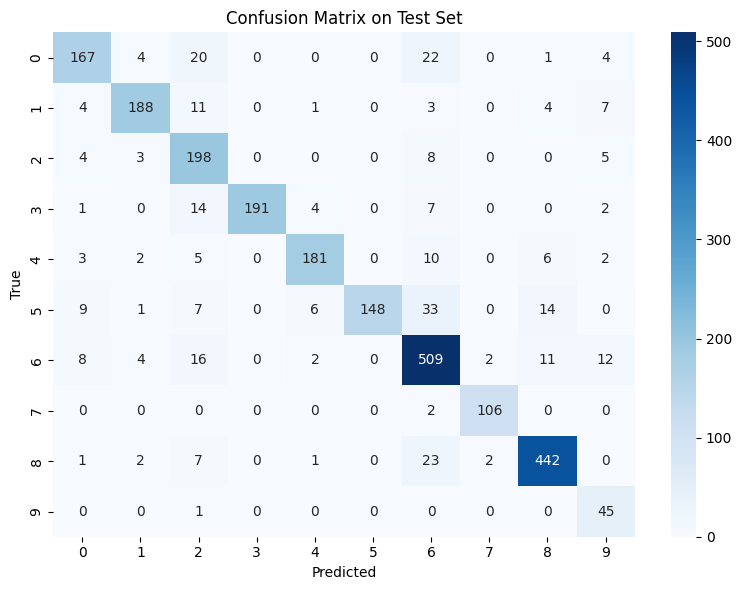

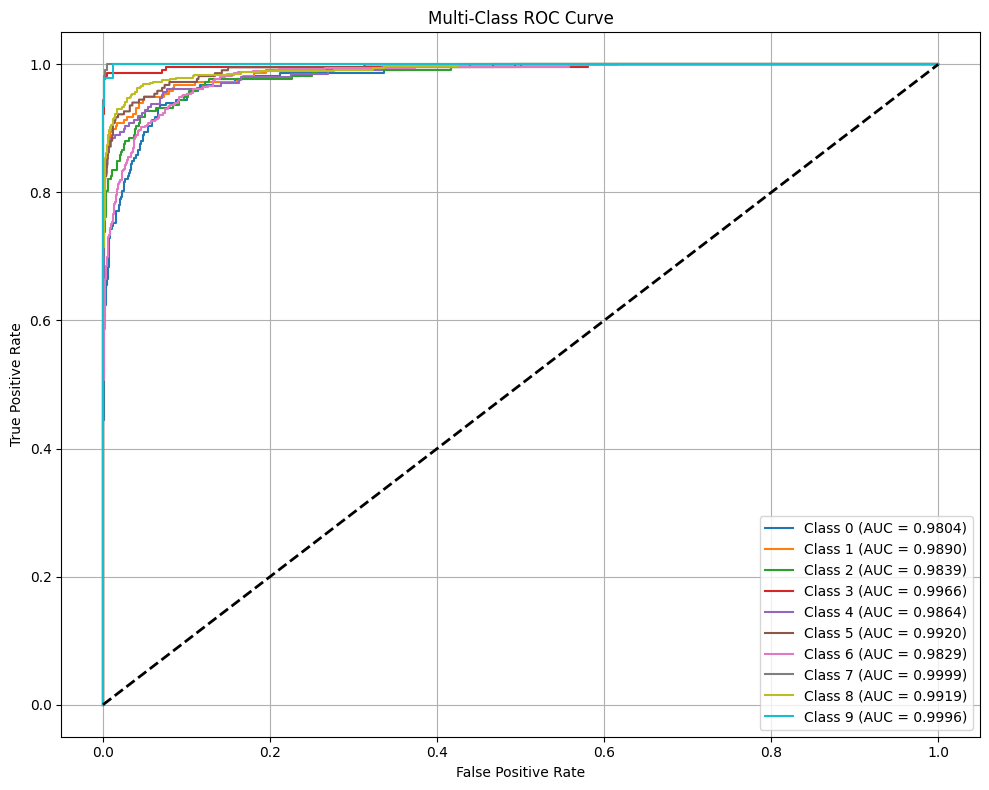

In [133]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = XResNet1D(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## WaveNet Model

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveletInspired1DCNN(nn.Module):
    def __init__(self, input_channels=1, input_length=8192, num_classes=10):
        super().__init__()

        # First Conv Block - 3 branches
        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.branch3 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # Second Conv Block - 3 branches again
        self.branch1_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.branch2_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.branch3_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # Compute output size after 2 poolings: 8192 / 2 / 2 = 2048
        final_length = input_length // 4
        self.flattened_size = 64 * 3 * final_length

        self.bn = nn.BatchNorm1d(64 * 3)

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # First 3 branches
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        # Second 3 branches
        x1 = self.branch1_2(x1)
        x2 = self.branch2_2(x2)
        x3 = self.branch3_2(x3)

        # Concatenate along channel dim
        x_cat = torch.cat((x1, x2, x3), dim=1)  # Shape: (B, 64×3, L)

        x_cat = self.bn(x_cat)
        x_flat = x_cat.view(x_cat.size(0), -1)  # Flatten
        return self.fc(x_flat)


In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [143]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [144]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = WaveletInspired1DCNN(num_classes=10).to(device)

        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [145]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)



--- Fold 1 ---


Epoch 1: Train Loss=0.5049, Val Loss=0.3004, Train Acc=79.44%, Val Acc=89.59%, Val Macro-F1=0.9036


Epoch 2: Train Loss=0.0670, Val Loss=0.1774, Train Acc=96.49%, Val Acc=93.69%, Val Macro-F1=0.9454


Epoch 3: Train Loss=0.0273, Val Loss=0.1635, Train Acc=98.68%, Val Acc=93.99%, Val Macro-F1=0.9396


Epoch 4: Train Loss=0.0173, Val Loss=0.2662, Train Acc=99.11%, Val Acc=90.79%, Val Macro-F1=0.9132


Epoch 5: Train Loss=0.0315, Val Loss=0.1622, Train Acc=98.26%, Val Acc=95.70%, Val Macro-F1=0.9590


Epoch 6: Train Loss=0.0141, Val Loss=0.1741, Train Acc=99.34%, Val Acc=95.10%, Val Macro-F1=0.9478


Epoch 7: Train Loss=0.0186, Val Loss=0.2400, Train Acc=99.18%, Val Acc=93.69%, Val Macro-F1=0.9362


Epoch 8: Train Loss=0.0040, Val Loss=0.1270, Train Acc=99.82%, Val Acc=96.80%, Val Macro-F1=0.9690


Epoch 9: Train Loss=0.0049, Val Loss=0.1881, Train Acc=99.69%, Val Acc=94.09%, Val Macro-F1=0.9366


Epoch 10: Train Loss=0.0141, Val Loss=0.1786, Train Acc=99.37%, Val Acc=94.59%, Val Macro-F1=0.9498

--- Fold 2 ---


Epoch 1: Train Loss=0.4636, Val Loss=0.3067, Train Acc=81.98%, Val Acc=88.29%, Val Macro-F1=0.8833


Epoch 2: Train Loss=0.0767, Val Loss=0.1434, Train Acc=96.29%, Val Acc=93.99%, Val Macro-F1=0.9447


Epoch 3: Train Loss=0.0203, Val Loss=0.0993, Train Acc=99.09%, Val Acc=94.89%, Val Macro-F1=0.9520


Epoch 4: Train Loss=0.0363, Val Loss=0.1596, Train Acc=98.50%, Val Acc=95.50%, Val Macro-F1=0.9565


Epoch 5: Train Loss=0.0177, Val Loss=0.1759, Train Acc=99.23%, Val Acc=93.89%, Val Macro-F1=0.9481


Epoch 6: Train Loss=0.0084, Val Loss=0.0997, Train Acc=99.53%, Val Acc=97.80%, Val Macro-F1=0.9794


Epoch 7: Train Loss=0.0112, Val Loss=0.1058, Train Acc=99.61%, Val Acc=96.70%, Val Macro-F1=0.9711


Epoch 8: Train Loss=0.0077, Val Loss=0.1275, Train Acc=99.59%, Val Acc=97.20%, Val Macro-F1=0.9742


Epoch 9: Train Loss=0.0223, Val Loss=0.2570, Train Acc=98.84%, Val Acc=91.09%, Val Macro-F1=0.9130


Epoch 10: Train Loss=0.0577, Val Loss=0.2414, Train Acc=97.46%, Val Acc=93.49%, Val Macro-F1=0.9377

--- Fold 3 ---


Epoch 1: Train Loss=0.4788, Val Loss=0.2632, Train Acc=80.63%, Val Acc=88.79%, Val Macro-F1=0.8997


Epoch 2: Train Loss=0.0584, Val Loss=0.1622, Train Acc=96.89%, Val Acc=93.69%, Val Macro-F1=0.9418


Epoch 3: Train Loss=0.0456, Val Loss=0.1312, Train Acc=98.14%, Val Acc=95.20%, Val Macro-F1=0.9553


Epoch 4: Train Loss=0.0191, Val Loss=0.1129, Train Acc=99.12%, Val Acc=95.30%, Val Macro-F1=0.9586


Epoch 5: Train Loss=0.0103, Val Loss=0.1012, Train Acc=99.52%, Val Acc=96.10%, Val Macro-F1=0.9640


Epoch 6: Train Loss=0.0023, Val Loss=0.0851, Train Acc=99.89%, Val Acc=96.90%, Val Macro-F1=0.9730


Epoch 7: Train Loss=0.0026, Val Loss=0.0746, Train Acc=99.91%, Val Acc=97.60%, Val Macro-F1=0.9773


Epoch 8: Train Loss=0.0313, Val Loss=0.4090, Train Acc=98.52%, Val Acc=85.19%, Val Macro-F1=0.8523


Epoch 9: Train Loss=0.0284, Val Loss=0.1543, Train Acc=98.38%, Val Acc=94.39%, Val Macro-F1=0.9506


Epoch 10: Train Loss=0.0146, Val Loss=0.1208, Train Acc=99.20%, Val Acc=96.20%, Val Macro-F1=0.9625

--- Fold 4 ---


Epoch 1: Train Loss=0.4611, Val Loss=0.3204, Train Acc=80.47%, Val Acc=86.09%, Val Macro-F1=0.8692


Epoch 2: Train Loss=0.0559, Val Loss=0.1509, Train Acc=96.74%, Val Acc=92.89%, Val Macro-F1=0.9392


Epoch 3: Train Loss=0.0631, Val Loss=0.1551, Train Acc=97.43%, Val Acc=95.30%, Val Macro-F1=0.9494


Epoch 4: Train Loss=0.0157, Val Loss=0.1190, Train Acc=99.23%, Val Acc=95.90%, Val Macro-F1=0.9608


Epoch 5: Train Loss=0.0156, Val Loss=0.0993, Train Acc=99.25%, Val Acc=96.80%, Val Macro-F1=0.9625


Epoch 6: Train Loss=0.0034, Val Loss=0.0728, Train Acc=99.81%, Val Acc=97.30%, Val Macro-F1=0.9714


Epoch 7: Train Loss=0.0029, Val Loss=0.1071, Train Acc=99.88%, Val Acc=97.20%, Val Macro-F1=0.9680


Epoch 8: Train Loss=0.0011, Val Loss=0.0767, Train Acc=99.97%, Val Acc=97.60%, Val Macro-F1=0.9712


Epoch 9: Train Loss=0.0144, Val Loss=0.2342, Train Acc=99.29%, Val Acc=94.09%, Val Macro-F1=0.9398


Epoch 10: Train Loss=0.0567, Val Loss=0.2208, Train Acc=97.16%, Val Acc=93.39%, Val Macro-F1=0.9325

--- Fold 5 ---


Epoch 1: Train Loss=0.5582, Val Loss=0.2728, Train Acc=78.99%, Val Acc=86.87%, Val Macro-F1=0.8836


Epoch 2: Train Loss=0.0717, Val Loss=0.2240, Train Acc=96.22%, Val Acc=90.78%, Val Macro-F1=0.9232


Epoch 3: Train Loss=0.0260, Val Loss=0.1447, Train Acc=98.64%, Val Acc=94.89%, Val Macro-F1=0.9517


Epoch 4: Train Loss=0.0138, Val Loss=0.1127, Train Acc=99.34%, Val Acc=96.59%, Val Macro-F1=0.9653


Epoch 5: Train Loss=0.0091, Val Loss=0.2300, Train Acc=99.49%, Val Acc=91.58%, Val Macro-F1=0.9311


Epoch 6: Train Loss=0.0292, Val Loss=0.4471, Train Acc=98.73%, Val Acc=90.58%, Val Macro-F1=0.8848


Epoch 7: Train Loss=0.1022, Val Loss=0.1569, Train Acc=96.65%, Val Acc=95.89%, Val Macro-F1=0.9602


Epoch 8: Train Loss=0.0185, Val Loss=0.0956, Train Acc=99.14%, Val Acc=96.69%, Val Macro-F1=0.9666


Epoch 9: Train Loss=0.0207, Val Loss=0.1368, Train Acc=99.15%, Val Acc=95.49%, Val Macro-F1=0.9614


Epoch 10: Train Loss=0.0127, Val Loss=0.1080, Train Acc=99.60%, Val Acc=96.69%, Val Macro-F1=0.9683

--- Fold 6 ---


Epoch 1: Train Loss=0.5140, Val Loss=0.3000, Train Acc=78.69%, Val Acc=88.28%, Val Macro-F1=0.8938


Epoch 2: Train Loss=0.0757, Val Loss=0.1873, Train Acc=96.15%, Val Acc=95.49%, Val Macro-F1=0.9564


Epoch 3: Train Loss=0.0274, Val Loss=0.2040, Train Acc=98.62%, Val Acc=92.79%, Val Macro-F1=0.9292


Epoch 4: Train Loss=0.0151, Val Loss=0.1767, Train Acc=99.29%, Val Acc=96.79%, Val Macro-F1=0.9673


Epoch 5: Train Loss=0.0115, Val Loss=0.1571, Train Acc=99.40%, Val Acc=96.99%, Val Macro-F1=0.9656


Epoch 6: Train Loss=0.0058, Val Loss=0.1211, Train Acc=99.68%, Val Acc=97.49%, Val Macro-F1=0.9724


Epoch 7: Train Loss=0.0152, Val Loss=0.1592, Train Acc=99.33%, Val Acc=95.99%, Val Macro-F1=0.9605


Epoch 8: Train Loss=0.0461, Val Loss=0.2105, Train Acc=97.99%, Val Acc=94.89%, Val Macro-F1=0.9352


Epoch 9: Train Loss=0.0180, Val Loss=0.1876, Train Acc=99.12%, Val Acc=97.39%, Val Macro-F1=0.9689


Epoch 10: Train Loss=0.0025, Val Loss=0.1728, Train Acc=99.84%, Val Acc=97.70%, Val Macro-F1=0.9762

--- Fold 7 ---


Epoch 1: Train Loss=0.5060, Val Loss=0.3254, Train Acc=79.66%, Val Acc=86.67%, Val Macro-F1=0.8855


Epoch 2: Train Loss=0.0831, Val Loss=0.1834, Train Acc=95.70%, Val Acc=92.99%, Val Macro-F1=0.9379


Epoch 3: Train Loss=0.0405, Val Loss=0.1347, Train Acc=97.87%, Val Acc=94.59%, Val Macro-F1=0.9495


Epoch 4: Train Loss=0.0148, Val Loss=0.1742, Train Acc=99.14%, Val Acc=94.69%, Val Macro-F1=0.9512


Epoch 5: Train Loss=0.0163, Val Loss=0.1221, Train Acc=99.40%, Val Acc=95.79%, Val Macro-F1=0.9595


Epoch 6: Train Loss=0.0173, Val Loss=0.2520, Train Acc=99.07%, Val Acc=92.89%, Val Macro-F1=0.9360


Epoch 7: Train Loss=0.0865, Val Loss=0.1894, Train Acc=96.75%, Val Acc=93.99%, Val Macro-F1=0.9430


Epoch 8: Train Loss=0.0116, Val Loss=0.1437, Train Acc=99.43%, Val Acc=95.29%, Val Macro-F1=0.9474


Epoch 9: Train Loss=0.0117, Val Loss=0.1863, Train Acc=99.34%, Val Acc=95.79%, Val Macro-F1=0.9590


Epoch 10: Train Loss=0.0057, Val Loss=0.1097, Train Acc=99.71%, Val Acc=97.19%, Val Macro-F1=0.9724

--- Fold 8 ---


Epoch 1: Train Loss=0.4504, Val Loss=0.3180, Train Acc=80.77%, Val Acc=88.78%, Val Macro-F1=0.8872


Epoch 2: Train Loss=0.0750, Val Loss=0.2088, Train Acc=95.95%, Val Acc=92.89%, Val Macro-F1=0.9304


Epoch 3: Train Loss=0.0345, Val Loss=0.1710, Train Acc=98.28%, Val Acc=93.99%, Val Macro-F1=0.9464


Epoch 4: Train Loss=0.0202, Val Loss=0.1670, Train Acc=99.03%, Val Acc=94.39%, Val Macro-F1=0.9497


Epoch 5: Train Loss=0.0067, Val Loss=0.1459, Train Acc=99.61%, Val Acc=93.79%, Val Macro-F1=0.9424


Epoch 6: Train Loss=0.0038, Val Loss=0.1174, Train Acc=99.78%, Val Acc=96.99%, Val Macro-F1=0.9695


Epoch 7: Train Loss=0.0018, Val Loss=0.1123, Train Acc=99.93%, Val Acc=96.89%, Val Macro-F1=0.9650


Epoch 8: Train Loss=0.0028, Val Loss=0.1650, Train Acc=99.89%, Val Acc=94.69%, Val Macro-F1=0.9472


Epoch 9: Train Loss=0.0818, Val Loss=0.5844, Train Acc=96.32%, Val Acc=84.67%, Val Macro-F1=0.8441


Epoch 10: Train Loss=0.0407, Val Loss=0.1955, Train Acc=97.91%, Val Acc=92.99%, Val Macro-F1=0.9335

--- Fold 9 ---


Epoch 1: Train Loss=0.5191, Val Loss=0.3306, Train Acc=79.30%, Val Acc=87.58%, Val Macro-F1=0.8824


Epoch 2: Train Loss=0.0605, Val Loss=0.1548, Train Acc=96.69%, Val Acc=94.59%, Val Macro-F1=0.9493


Epoch 3: Train Loss=0.0221, Val Loss=0.1381, Train Acc=98.95%, Val Acc=94.89%, Val Macro-F1=0.9549


Epoch 4: Train Loss=0.0299, Val Loss=0.1398, Train Acc=98.94%, Val Acc=95.99%, Val Macro-F1=0.9617


Epoch 5: Train Loss=0.0067, Val Loss=0.1558, Train Acc=99.76%, Val Acc=96.19%, Val Macro-F1=0.9638


Epoch 6: Train Loss=0.0155, Val Loss=0.1451, Train Acc=99.29%, Val Acc=95.99%, Val Macro-F1=0.9612


Epoch 7: Train Loss=0.0087, Val Loss=0.2077, Train Acc=99.69%, Val Acc=94.89%, Val Macro-F1=0.9446


Epoch 8: Train Loss=0.0599, Val Loss=0.5087, Train Acc=97.38%, Val Acc=87.37%, Val Macro-F1=0.8516


Epoch 9: Train Loss=0.0275, Val Loss=0.1738, Train Acc=98.66%, Val Acc=93.89%, Val Macro-F1=0.9456


Epoch 10: Train Loss=0.0141, Val Loss=0.1716, Train Acc=99.30%, Val Acc=96.19%, Val Macro-F1=0.9646

--- Fold 10 ---


Epoch 1: Train Loss=0.5208, Val Loss=0.2873, Train Acc=79.86%, Val Acc=88.28%, Val Macro-F1=0.8968


Epoch 2: Train Loss=0.0677, Val Loss=0.1376, Train Acc=96.73%, Val Acc=94.39%, Val Macro-F1=0.9423


Epoch 3: Train Loss=0.0233, Val Loss=0.1202, Train Acc=98.81%, Val Acc=95.09%, Val Macro-F1=0.9505


Epoch 4: Train Loss=0.0195, Val Loss=0.1187, Train Acc=99.07%, Val Acc=96.29%, Val Macro-F1=0.9553


Epoch 5: Train Loss=0.0165, Val Loss=0.1159, Train Acc=99.23%, Val Acc=95.19%, Val Macro-F1=0.9477


Epoch 6: Train Loss=0.0054, Val Loss=0.1239, Train Acc=99.74%, Val Acc=96.39%, Val Macro-F1=0.9659


Epoch 7: Train Loss=0.0035, Val Loss=0.0871, Train Acc=99.83%, Val Acc=96.59%, Val Macro-F1=0.9650


Epoch 8: Train Loss=0.0549, Val Loss=0.2814, Train Acc=97.25%, Val Acc=91.08%, Val Macro-F1=0.9017


Epoch 9: Train Loss=0.0353, Val Loss=0.1786, Train Acc=98.42%, Val Acc=95.99%, Val Macro-F1=0.9610


Epoch 10: Train Loss=0.0665, Val Loss=0.2162, Train Acc=97.97%, Val Acc=92.69%, Val Macro-F1=0.9277


In [146]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.3656           94.5946      0.0141    0.1786   
1   Fold 2             97.4624           93.4935      0.0577    0.2414   
2   Fold 3             99.1987           96.1962      0.0146    0.1208   
3   Fold 4             97.1619           93.3934      0.0567    0.2208   
4   Fold 5             99.5994           96.6934      0.0127    0.1080   
5   Fold 6             99.8442           97.6954      0.0025    0.1728   
6   Fold 7             99.7107           97.1944      0.0057    0.1097   
7   Fold 8             97.9079           92.9860      0.0407    0.1955   
8   Fold 9             99.2989           96.1924      0.0141    0.1716   
9  Fold 10             97.9746           92.6854      0.0665    0.2162   

   Val Macro F1  
0        0.9498  
1        0.9377  
2        0.9625  
3        0.9325  
4        0.9683  
5        0.9762  
6        0.9724  
7        0.9335 

In [147]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1

Best fold is fold 6

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9464    0.9725    0.9593       218
           1     0.9815    0.9725    0.9770       218
           2     0.9500    0.9587    0.9543       218
           3     0.9861    0.9726    0.9793       219
           4     0.9949    0.9330    0.9630       209
           5     0.9860    0.9679    0.9769       218
           6     0.9535    0.9823    0.9677       564
           7     0.9904    0.9537    0.9717       108
           8     0.9666    0.9686    0.9676       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9688      2496
   macro avg     0.9755    0.9682    0.9717      2496
weighted avg     0.9692    0.9688    0.9688      2496



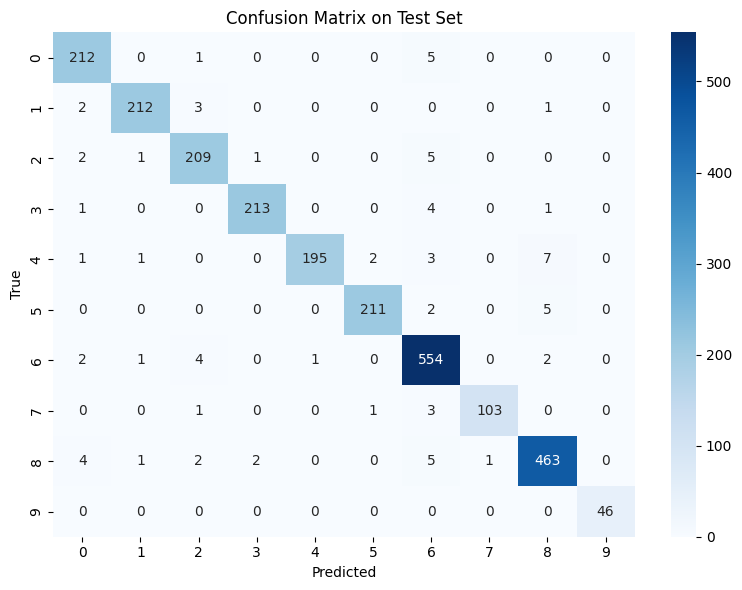

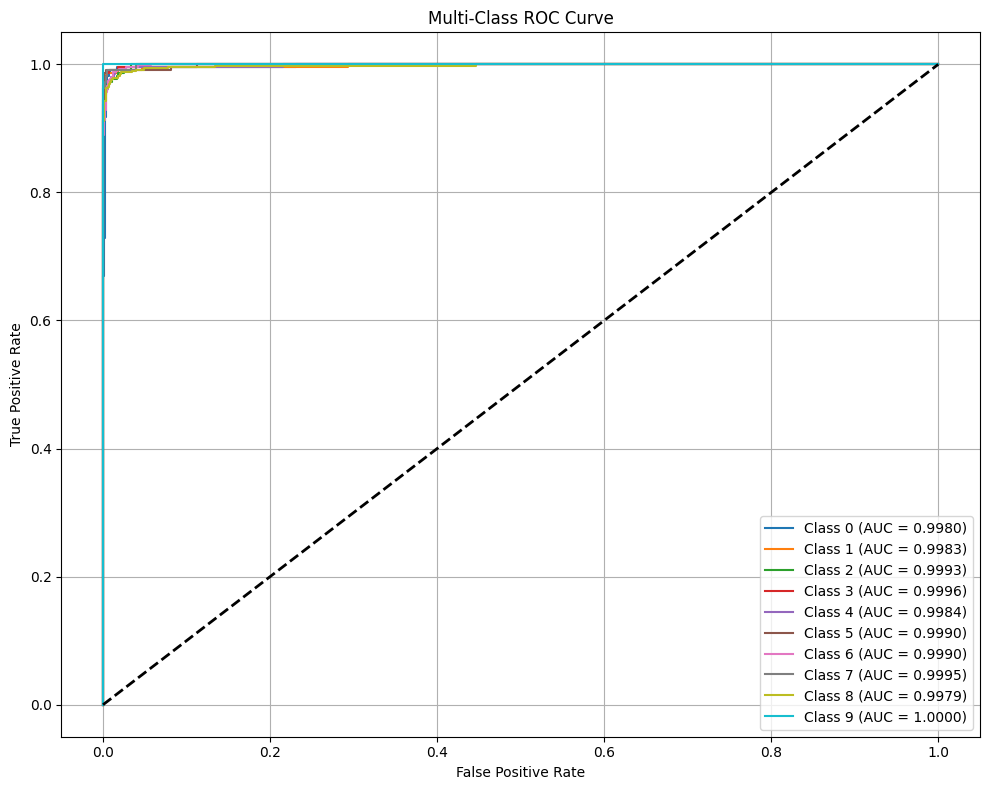

In [148]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = WaveletInspired1DCNN(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## TCN Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2, n_convs=3):
        super().__init__()
        self.n_convs = n_convs
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.relu = nn.ReLU()
        
        for i in range(n_convs):
            in_ch = in_channels if i == 0 else out_channels
            padding = (kernel_size - 1) * dilation
            conv = weight_norm(nn.Conv1d(in_ch, out_channels, kernel_size,
                                         padding=padding, dilation=dilation))
            norm = nn.LayerNorm(out_channels)
            dropout_layer = nn.Dropout(dropout)
            self.convs.append(conv)
            self.norms.append(norm)
            self.dropouts.append(dropout_layer)
        
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        out = x
        for i in range(self.n_convs):
            out = self.convs[i](out)
            out = out[:, :, :-self.convs[i].padding[0]]  # chomp for causality
            # transpose for layer norm: (batch, channels, length) -> (batch, length, channels)
            out = out.transpose(1, 2)
            out = self.norms[i](out)
            out = out.transpose(1, 2)
            out = self.relu(out)
            out = self.dropouts[i](out)
        
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size=3, dropout=0.3, n_convs=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = input_channels if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers.append(ResidualBlock(in_ch, out_ch, kernel_size, dilation, dropout, n_convs))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class AttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.scale = input_dim ** 0.5
    
    def forward(self, x):
        # x shape: (batch, seq_len, dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale
        attn = torch.softmax(scores, dim=-1)
        out = torch.bmm(attn, V)
        out = out.mean(dim=1)  # pool across seq_len dimension
        return out

class TCNClassifier(nn.Module):
    def __init__(self, num_classes, input_size=8192,
                 num_channels=[64, 128, 256, 512], kernel_size=3,
                 dropout=0.3, n_convs=3):
        super().__init__()
        self.tcn = TCN(input_channels=1, num_channels=num_channels,
                       kernel_size=kernel_size, dropout=dropout, n_convs=n_convs)
        
        self.attention_pool = AttentionPooling(num_channels[-1])
        self.fc = nn.Sequential(
            nn.Linear(num_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
    # def forward(self, x):
    #     # x shape (batch, 1, input_size)
    #     x = self.tcn(x)  # (batch, channels, seq_len)
    #     x = x.transpose(1, 2)  # (batch, seq_len, channels)
    #     x = self.attention_pool(x)  # (batch, channels)
    #     x = self.fc(x)  # (batch, num_classes)
    #     return x
    def forward(self, x):
        x = self.tcn(x)               # (batch, channels, seq_len)
        x = x.mean(dim=2)             # Global average pooling over seq_len dimension
        out = self.fc(x)              # (batch, num_classes)
        return out


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [21]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = TCNClassifier(num_classes=10).to(device)

        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [22]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()


3078

In [24]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=16)


/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



--- Fold 1 ---


Epoch 1: Train Loss=2.1118, Val Loss=2.5155, Train Acc=9.95%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=2.0546, Val Loss=2.5156, Train Acc=11.04%, Val Acc=3.70%, Val Macro-F1=0.0348


KeyboardInterrupt: 

## FCN Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dropout=0.2):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_ch)
        self.dropout2 = nn.Dropout(dropout)

        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out += residual
        return self.relu(out)

class FCN1DEnhanced(nn.Module):
    def __init__(self, num_classes, input_channels=1, dropout=0.2):
        super().__init__()
        self.block1 = ResidualConvBlock(input_channels, 64, kernel_size=7, dropout=dropout)
        self.block2 = ResidualConvBlock(64, 128, kernel_size=5, dropout=dropout)
        self.block3 = ResidualConvBlock(128, 256, kernel_size=3, dropout=dropout)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [14]:

# Cross-validation loop
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = FCN1DEnhanced(num_classes=10).to(device)

        # Criterion with class weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        cv_history['train_acc'].append(history['train_acc'][-1])
        cv_history['val_acc'].append(history['val_acc'][-1])
        cv_history['train_loss'].append(history['train_loss'][-1])
        cv_history['val_loss'].append(history['val_loss'][-1])
        cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
        cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    return cv_history

In [16]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=15, batch_size=32)



--- Fold 1 ---


Epoch 1: Train Loss=1.7546, Val Loss=2.0743, Train Acc=18.40%, Val Acc=15.52%, Val Macro-F1=0.1588


Epoch 2: Train Loss=1.4533, Val Loss=1.9723, Train Acc=28.89%, Val Acc=19.72%, Val Macro-F1=0.2176


Epoch 3: Train Loss=1.2748, Val Loss=1.7451, Train Acc=37.62%, Val Acc=28.73%, Val Macro-F1=0.2922


Epoch 4: Train Loss=1.1852, Val Loss=1.7184, Train Acc=43.98%, Val Acc=28.33%, Val Macro-F1=0.2867


Epoch 5: Train Loss=1.0860, Val Loss=1.5314, Train Acc=47.00%, Val Acc=39.44%, Val Macro-F1=0.3826


Epoch 6: Train Loss=1.0278, Val Loss=1.4998, Train Acc=49.72%, Val Acc=36.74%, Val Macro-F1=0.3535


Epoch 7: Train Loss=1.0140, Val Loss=1.4807, Train Acc=52.22%, Val Acc=41.04%, Val Macro-F1=0.4108


Epoch 8: Train Loss=0.9564, Val Loss=1.8320, Train Acc=53.33%, Val Acc=29.43%, Val Macro-F1=0.3247


Epoch 9: Train Loss=0.9351, Val Loss=1.3335, Train Acc=53.98%, Val Acc=43.94%, Val Macro-F1=0.4220


Epoch 10: Train Loss=0.9219, Val Loss=1.4631, Train Acc=55.53%, Val Acc=43.64%, Val Macro-F1=0.4240


Epoch 11: Train Loss=0.8869, Val Loss=1.4099, Train Acc=57.16%, Val Acc=42.04%, Val Macro-F1=0.4176


Epoch 12: Train Loss=0.8560, Val Loss=1.3035, Train Acc=57.40%, Val Acc=48.15%, Val Macro-F1=0.4539


Epoch 13: Train Loss=0.8638, Val Loss=1.4953, Train Acc=57.90%, Val Acc=38.84%, Val Macro-F1=0.3874


Epoch 14: Train Loss=0.8244, Val Loss=1.3041, Train Acc=60.52%, Val Acc=49.25%, Val Macro-F1=0.5111


KeyboardInterrupt: 

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from collections import defaultdict
from tqdm import tqdm
import numpy as np

# Your ResidualConvBlock and FCN1DEnhanced classes remain as you defined

class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dropout=0.2):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_ch)
        self.dropout2 = nn.Dropout(dropout)

        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out += residual
        return self.relu(out)

class FCN1DEnhanced(nn.Module):
    def __init__(self, num_classes, input_channels=1, dropout=0.2):
        super().__init__()
        self.block1 = ResidualConvBlock(input_channels, 64, kernel_size=7, dropout=dropout)
        self.block2 = ResidualConvBlock(64, 128, kernel_size=5, dropout=dropout)
        self.block3 = ResidualConvBlock(128, 256, kernel_size=3, dropout=dropout)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)
        return x


In [139]:
import torch
torch.cuda.empty_cache()


In [140]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                with autocast(enabled=torch.cuda.is_available()):
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [144]:
import torch
torch.cuda.empty_cache()

def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n--- Fold {fold + 1} ---")

        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # Compute class weights for weighted sampler and loss
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        weight_map = {cls: w for cls, w in zip(classes, class_weights)}
        sample_weights = [weight_map[y] for y in y_train]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

        model = FCN1DEnhanced(num_classes=len(classes)).to(device)

        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

        for k in history:
            cv_history[k].append(history[k][-1])

    return cv_history

In [145]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
import torch
torch.cuda.empty_cache()

# Run cross-validation training
cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32)


/tmp/ipykernel_144486/3331542784.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



--- Fold 1 ---


[Train] Epoch 1/10:   0%|          | 0/281 [00:00<?, ?it/s]

/tmp/ipykernel_144486/3331542784.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 7.67 GiB of which 40.06 MiB is free. Process 2499 has 132.68 MiB memory in use. Including non-PyTorch memory, this process has 7.21 GiB memory in use. Of the allocated memory 6.99 GiB is allocated by PyTorch, and 42.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Dilated 1d cnn

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Dilated1DCNN(nn.Module):
    def __init__(self, input_channels=1, input_length=8192, num_classes=10):
        super().__init__()

        # Dilation rates per block (increasing)
        dilations = [1, 2, 4, 8, 16]

        # Block 1
        self.block1_conv1 = nn.Conv1d(input_channels, 32, kernel_size=9, 
                                     padding=dilations[0]*4, dilation=dilations[0])
        self.block1_conv2 = nn.Conv1d(32, 32, kernel_size=9, 
                                     padding=dilations[0]*4, dilation=dilations[0])
        self.block1_pool = nn.MaxPool1d(kernel_size=2, stride=2)  # halve length

        # Block 2
        self.block2_conv1 = nn.Conv1d(32, 64, kernel_size=7, 
                                     padding=dilations[1]*3, dilation=dilations[1])
        self.block2_conv2 = nn.Conv1d(64, 64, kernel_size=7, 
                                     padding=dilations[1]*3, dilation=dilations[1])
        self.block2_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 3
        self.block3_conv1 = nn.Conv1d(64, 128, kernel_size=5, 
                                     padding=dilations[2]*2, dilation=dilations[2])
        self.block3_conv2 = nn.Conv1d(128, 128, kernel_size=5, 
                                     padding=dilations[2]*2, dilation=dilations[2])
        self.block3_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 4
        self.block4_conv1 = nn.Conv1d(128, 256, kernel_size=3, 
                                     padding=dilations[3]*1, dilation=dilations[3])
        self.block4_conv2 = nn.Conv1d(256, 256, kernel_size=3, 
                                     padding=dilations[3]*1, dilation=dilations[3])
        self.block4_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 5
        self.block5_conv1 = nn.Conv1d(256, 512, kernel_size=3, 
                                     padding=dilations[4]*1, dilation=dilations[4])
        self.block5_conv2 = nn.Conv1d(512, 512, kernel_size=3, 
                                     padding=dilations[4]*1, dilation=dilations[4])
        self.block5_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate final length after pooling (halving 5 times)
        final_length = input_length // (2 ** 5)  # 8192 / 32 = 256
        self.flattened_size = 512 * final_length

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)

        # Output layer
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.block1_conv1(x))
        x = F.relu(self.block1_conv2(x))
        x = self.block1_pool(x)

        x = F.relu(self.block2_conv1(x))
        x = F.relu(self.block2_conv2(x))
        x = self.block2_pool(x)

        x = F.relu(self.block3_conv1(x))
        x = F.relu(self.block3_conv2(x))
        x = self.block3_pool(x)

        x = F.relu(self.block4_conv1(x))
        x = F.relu(self.block4_conv2(x))
        x = self.block4_pool(x)

        x = F.relu(self.block5_conv1(x))
        x = F.relu(self.block5_conv2(x))
        x = self.block5_pool(x)

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.output(x)
        return x

# Test the model
if __name__ == "__main__":
    model = Dilated1DCNN()
    print(model)

    dummy_input = torch.randn(8, 1, 8192)
    output = model(dummy_input)
    print(output.shape)  # should be [8, 10]


Dilated1DCNN(
  (block1_conv1): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
  (block1_conv2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
  (block1_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
  (block2_conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
  (block2_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3_conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
  (block3_conv2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
  (block3_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4_conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
  (block4_conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(8,), dilat

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history


In [16]:
def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
    cv_history = defaultdict(list)
    summary_table = []
    fold_predictions = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n=== Fold {fold + 1} ===")

        # ======== Split Data ========
        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val   = [X_trainval[i] for i in val_idx]
        y_val   = [y_trainval[i] for i in val_idx]

        # ======== Class Weights & Sampler ========
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        # ======== Datasets & Loaders ========
        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset   = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # ======== Model Setup ========
        model = Dilated1DCNN(num_classes=10).to(device)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # ======== Train the Model (no change) ========
        history = train_model(model, train_loader, val_loader, criterion, optimizer,
                              device, num_epochs=num_epochs, fold=fold)

        for k in history:
            cv_history[k].append(history[k])

        # ======== Recompute Val Predictions After Training ========
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds.cpu().numpy())

        # ======== Store Fold Summary ========
        summary_table.append({
            "Fold": f"Fold {fold+1}",
            "Train Accuracy (%)": history['train_acc'][-1],
            "Val Accuracy (%)": history['val_acc'][-1],
            "Train Loss": history['train_loss'][-1],
            "Val Loss": history['val_loss'][-1],
            "Val Macro F1": f1_score(y_true, y_pred, average='macro')
        })

        fold_predictions.append((y_true, y_pred, fold))

        # ======== Cleanup ========
        del model
        torch.cuda.empty_cache()
        gc.collect()

    summary_df = pd.DataFrame(summary_table)
    return cv_history, summary_df, fold_predictions


In [ ]:
# # code used for the train curves 

# import torch
# import gc
# import numpy as np
# from collections import defaultdict
# from torch.utils.data import DataLoader, WeightedRandomSampler
# from sklearn.utils.class_weight import compute_class_weight

# def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
#     cv_history = defaultdict(list)

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#         print(f"\n=== Fold {fold + 1} ===")

#         # ======== Split Data ========
#         X_train = [X_trainval[i] for i in train_idx]
#         y_train = [y_trainval[i] for i in train_idx]
#         X_val   = [X_trainval[i] for i in val_idx]
#         y_val   = [y_trainval[i] for i in val_idx]

#         # ======== Class Weights & Sampler ========
#         class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#         weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#         sample_weights = [weight_map[y] for y in y_train]
#         sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#         # ======== Datasets & Loaders ========
#         train_dataset = STFTFlattenedDataset(X_train, y_train)
#         val_dataset   = STFTFlattenedDataset(X_val, y_val)

#         train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
#         val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         # ======== Model Setup ========
#         model = Dilated1DCNN_8192(num_classes=10).to(device)
#         class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#         criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
#         optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#         # ======== Train & Collect History ========
#         history = train_model(model, train_loader, val_loader, criterion, optimizer,
#                               device, num_epochs=num_epochs, fold=fold)

#         for k in history:
#             cv_history[k].append(history[k])  # Append last epoch stat

#         # ======== Cleanup to Prevent OOM ========
#         del model
#         torch.cuda.empty_cache()
#         gc.collect()

#     return cv_history


In [ ]:

# # Cross-validation loop
# def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
#     cv_history = defaultdict(list)

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#         print(f"\n--- Fold {fold + 1} ---")

#         X_train = [X_trainval[i] for i in train_idx]
#         y_train = [y_trainval[i] for i in train_idx]
#         X_val   = [X_trainval[i] for i in val_idx]
#         y_val   = [y_trainval[i] for i in val_idx]

#         # Compute class weights for weighted sampler and loss
#         class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#         weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#         sample_weights = [weight_map[y] for y in y_train]

#         sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#         train_dataset = STFTFlattenedDataset(X_train, y_train)
#         val_dataset = STFTFlattenedDataset(X_val, y_val)

#         train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         model = Dilated1DCNN_8192(num_classes=10).to(device)

#         # Criterion with class weights
#         class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#         criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
#         optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#         history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, fold=fold)

#         cv_history['train_acc'].append(history['train_acc'][-1])
#         cv_history['val_acc'].append(history['val_acc'][-1])
#         cv_history['train_loss'].append(history['train_loss'][-1])
#         cv_history['val_loss'].append(history['val_loss'][-1])
#         cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
#         cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

#     return cv_history

In [17]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()


38

In [19]:
import torch
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [20]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"


In [21]:
# from sklearn.model_selection import StratifiedKFold

# # Step 1: Define Stratified K-Fold splitter
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Step 2: Run cross-validation training
# cv_history, summary_df, fold_preds = cross_validate_and_train(
#     X_trainval, y_trainval, skf, num_epochs=10, batch_size=16
# )

from sklearn.model_selection import StratifiedKFold

# Step 1: Define Stratified K-Fold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 2: Run cross-validation training with safer batch size
cv_history, summary_df, fold_preds = cross_validate_and_train(
    X_trainval, y_trainval, skf, num_epochs=10, batch_size=8
)



=== Fold 1 ===


Epoch 1: Train Loss=1.9747, Val Loss=1.8916, Train Acc=15.39%, Val Acc=19.12%, Val Macro-F1=0.2047


Epoch 2: Train Loss=0.8171, Val Loss=0.3787, Train Acc=59.77%, Val Acc=81.28%, Val Macro-F1=0.8315


Epoch 3: Train Loss=0.2198, Val Loss=0.2267, Train Acc=88.32%, Val Acc=91.99%, Val Macro-F1=0.9331


Epoch 4: Train Loss=0.1178, Val Loss=0.1063, Train Acc=93.88%, Val Acc=95.30%, Val Macro-F1=0.9550


Epoch 5: Train Loss=0.0657, Val Loss=0.0549, Train Acc=96.55%, Val Acc=97.10%, Val Macro-F1=0.9750


Epoch 6: Train Loss=0.0483, Val Loss=0.0473, Train Acc=97.40%, Val Acc=98.30%, Val Macro-F1=0.9874


Epoch 7: Train Loss=0.0359, Val Loss=0.0362, Train Acc=97.94%, Val Acc=98.00%, Val Macro-F1=0.9846


Epoch 8: Train Loss=0.0388, Val Loss=0.0594, Train Acc=98.15%, Val Acc=97.00%, Val Macro-F1=0.9743


Epoch 9: Train Loss=0.0205, Val Loss=0.0137, Train Acc=98.94%, Val Acc=99.60%, Val Macro-F1=0.9967


Epoch 10: Train Loss=0.0243, Val Loss=0.0115, Train Acc=98.81%, Val Acc=99.30%, Val Macro-F1=0.9946

=== Fold 2 ===


Epoch 1: Train Loss=2.0981, Val Loss=2.0095, Train Acc=11.85%, Val Acc=16.02%, Val Macro-F1=0.1014


Epoch 2: Train Loss=0.8801, Val Loss=0.4167, Train Acc=56.86%, Val Acc=81.38%, Val Macro-F1=0.8383


Epoch 3: Train Loss=0.2456, Val Loss=0.2137, Train Acc=86.47%, Val Acc=89.29%, Val Macro-F1=0.9134


Epoch 4: Train Loss=0.1140, Val Loss=0.1014, Train Acc=93.51%, Val Acc=95.30%, Val Macro-F1=0.9586


Epoch 5: Train Loss=0.0715, Val Loss=0.0798, Train Acc=95.85%, Val Acc=96.50%, Val Macro-F1=0.9718


Epoch 6: Train Loss=0.0738, Val Loss=0.0466, Train Acc=96.27%, Val Acc=98.30%, Val Macro-F1=0.9859


Epoch 7: Train Loss=0.0413, Val Loss=0.0299, Train Acc=97.92%, Val Acc=98.90%, Val Macro-F1=0.9910


Epoch 8: Train Loss=0.0358, Val Loss=0.0315, Train Acc=98.05%, Val Acc=98.90%, Val Macro-F1=0.9913


Epoch 9: Train Loss=0.0253, Val Loss=0.0563, Train Acc=98.79%, Val Acc=98.20%, Val Macro-F1=0.9813


Epoch 10: Train Loss=0.0254, Val Loss=0.0254, Train Acc=98.72%, Val Acc=98.80%, Val Macro-F1=0.9901

=== Fold 3 ===


Epoch 1: Train Loss=2.1565, Val Loss=2.5313, Train Acc=10.01%, Val Acc=1.90%, Val Macro-F1=0.0037


Epoch 2: Train Loss=1.5676, Val Loss=1.2002, Train Acc=29.95%, Val Acc=47.55%, Val Macro-F1=0.4930


Epoch 3: Train Loss=0.4460, Val Loss=0.3910, Train Acc=75.33%, Val Acc=79.18%, Val Macro-F1=0.8285


Epoch 4: Train Loss=0.2031, Val Loss=0.2007, Train Acc=89.03%, Val Acc=88.49%, Val Macro-F1=0.9014


Epoch 5: Train Loss=0.1098, Val Loss=0.0959, Train Acc=93.70%, Val Acc=95.30%, Val Macro-F1=0.9582


Epoch 6: Train Loss=0.0824, Val Loss=0.1118, Train Acc=95.66%, Val Acc=94.99%, Val Macro-F1=0.9518


Epoch 7: Train Loss=0.0652, Val Loss=0.0538, Train Acc=96.83%, Val Acc=97.30%, Val Macro-F1=0.9765


Epoch 8: Train Loss=0.0455, Val Loss=0.0624, Train Acc=97.72%, Val Acc=96.70%, Val Macro-F1=0.9673


Epoch 9: Train Loss=0.0338, Val Loss=0.0432, Train Acc=98.24%, Val Acc=97.80%, Val Macro-F1=0.9820


Epoch 10: Train Loss=0.0300, Val Loss=0.0243, Train Acc=98.65%, Val Acc=98.70%, Val Macro-F1=0.9884

=== Fold 4 ===


Epoch 1: Train Loss=1.7080, Val Loss=1.2037, Train Acc=26.07%, Val Acc=53.75%, Val Macro-F1=0.5470


Epoch 2: Train Loss=0.4420, Val Loss=0.2853, Train Acc=77.53%, Val Acc=85.29%, Val Macro-F1=0.8776


Epoch 3: Train Loss=0.1586, Val Loss=0.1140, Train Acc=91.70%, Val Acc=94.69%, Val Macro-F1=0.9539


Epoch 4: Train Loss=0.0784, Val Loss=0.0654, Train Acc=95.90%, Val Acc=97.40%, Val Macro-F1=0.9790


Epoch 5: Train Loss=0.0649, Val Loss=0.0426, Train Acc=96.83%, Val Acc=98.30%, Val Macro-F1=0.9827


Epoch 6: Train Loss=0.0454, Val Loss=0.0356, Train Acc=97.58%, Val Acc=98.20%, Val Macro-F1=0.9828


Epoch 7: Train Loss=0.0335, Val Loss=0.0621, Train Acc=98.31%, Val Acc=97.70%, Val Macro-F1=0.9764


Epoch 8: Train Loss=0.0320, Val Loss=0.0163, Train Acc=98.49%, Val Acc=99.30%, Val Macro-F1=0.9930


Epoch 9: Train Loss=0.0225, Val Loss=0.0288, Train Acc=98.94%, Val Acc=98.60%, Val Macro-F1=0.9852


Epoch 10: Train Loss=0.0136, Val Loss=0.0360, Train Acc=99.27%, Val Acc=98.70%, Val Macro-F1=0.9881

=== Fold 5 ===


Epoch 1: Train Loss=2.1622, Val Loss=2.4005, Train Acc=9.63%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.2945, Val Loss=0.6609, Train Acc=40.26%, Val Acc=73.05%, Val Macro-F1=0.7389


Epoch 3: Train Loss=0.3020, Val Loss=0.1908, Train Acc=84.43%, Val Acc=89.68%, Val Macro-F1=0.9112


Epoch 4: Train Loss=0.1345, Val Loss=0.0761, Train Acc=92.67%, Val Acc=96.89%, Val Macro-F1=0.9739


Epoch 5: Train Loss=0.0886, Val Loss=0.0679, Train Acc=95.49%, Val Acc=97.39%, Val Macro-F1=0.9703


Epoch 6: Train Loss=0.0579, Val Loss=0.0715, Train Acc=96.80%, Val Acc=97.49%, Val Macro-F1=0.9778


Epoch 7: Train Loss=0.0552, Val Loss=0.0363, Train Acc=97.21%, Val Acc=98.40%, Val Macro-F1=0.9866


Epoch 8: Train Loss=0.0374, Val Loss=0.0543, Train Acc=98.11%, Val Acc=97.29%, Val Macro-F1=0.9777


Epoch 9: Train Loss=0.0420, Val Loss=0.0266, Train Acc=98.01%, Val Acc=99.00%, Val Macro-F1=0.9917


Epoch 10: Train Loss=0.0306, Val Loss=0.0275, Train Acc=98.58%, Val Acc=98.80%, Val Macro-F1=0.9909

=== Fold 6 ===


Epoch 1: Train Loss=1.9081, Val Loss=1.7272, Train Acc=18.51%, Val Acc=26.15%, Val Macro-F1=0.2540


Epoch 2: Train Loss=0.5763, Val Loss=0.3653, Train Acc=70.40%, Val Acc=82.46%, Val Macro-F1=0.8283


Epoch 3: Train Loss=0.1802, Val Loss=0.1710, Train Acc=90.13%, Val Acc=92.79%, Val Macro-F1=0.9333


Epoch 4: Train Loss=0.1012, Val Loss=0.1273, Train Acc=94.54%, Val Acc=94.09%, Val Macro-F1=0.9488


Epoch 5: Train Loss=0.0689, Val Loss=0.0829, Train Acc=96.54%, Val Acc=97.39%, Val Macro-F1=0.9711


Epoch 6: Train Loss=0.0466, Val Loss=0.0694, Train Acc=97.52%, Val Acc=97.90%, Val Macro-F1=0.9789


Epoch 7: Train Loss=0.0419, Val Loss=0.0933, Train Acc=97.90%, Val Acc=96.69%, Val Macro-F1=0.9673


Epoch 8: Train Loss=0.0342, Val Loss=0.0410, Train Acc=98.39%, Val Acc=99.10%, Val Macro-F1=0.9907


Epoch 9: Train Loss=0.0299, Val Loss=0.0385, Train Acc=98.64%, Val Acc=99.00%, Val Macro-F1=0.9890


Epoch 10: Train Loss=0.0270, Val Loss=0.0446, Train Acc=98.89%, Val Acc=99.00%, Val Macro-F1=0.9892

=== Fold 7 ===


Epoch 1: Train Loss=1.9442, Val Loss=1.7340, Train Acc=17.42%, Val Acc=25.15%, Val Macro-F1=0.2563


Epoch 2: Train Loss=0.6004, Val Loss=0.3061, Train Acc=69.12%, Val Acc=83.97%, Val Macro-F1=0.8511


Epoch 3: Train Loss=0.1886, Val Loss=0.1139, Train Acc=89.65%, Val Acc=94.69%, Val Macro-F1=0.9530


Epoch 4: Train Loss=0.0917, Val Loss=0.0832, Train Acc=94.84%, Val Acc=97.09%, Val Macro-F1=0.9770


Epoch 5: Train Loss=0.0716, Val Loss=0.0492, Train Acc=95.90%, Val Acc=97.19%, Val Macro-F1=0.9782


Epoch 6: Train Loss=0.0513, Val Loss=0.0742, Train Acc=97.41%, Val Acc=97.70%, Val Macro-F1=0.9756


Epoch 7: Train Loss=0.0444, Val Loss=0.0358, Train Acc=98.07%, Val Acc=98.00%, Val Macro-F1=0.9848


Epoch 8: Train Loss=0.0359, Val Loss=0.0204, Train Acc=98.31%, Val Acc=98.70%, Val Macro-F1=0.9899


Epoch 9: Train Loss=0.0305, Val Loss=0.0235, Train Acc=98.52%, Val Acc=98.20%, Val Macro-F1=0.9856


Epoch 10: Train Loss=0.0225, Val Loss=0.0173, Train Acc=98.90%, Val Acc=99.00%, Val Macro-F1=0.9904

=== Fold 8 ===


Epoch 1: Train Loss=1.7853, Val Loss=1.4285, Train Acc=22.51%, Val Acc=37.68%, Val Macro-F1=0.3906


Epoch 2: Train Loss=0.5336, Val Loss=0.3284, Train Acc=72.75%, Val Acc=83.67%, Val Macro-F1=0.8515


Epoch 3: Train Loss=0.1793, Val Loss=0.1340, Train Acc=90.44%, Val Acc=93.79%, Val Macro-F1=0.9472


Epoch 4: Train Loss=0.0915, Val Loss=0.0707, Train Acc=94.80%, Val Acc=96.69%, Val Macro-F1=0.9697


Epoch 5: Train Loss=0.0612, Val Loss=0.0436, Train Acc=96.73%, Val Acc=97.19%, Val Macro-F1=0.9744


Epoch 6: Train Loss=0.0550, Val Loss=0.0266, Train Acc=97.25%, Val Acc=98.80%, Val Macro-F1=0.9912


Epoch 7: Train Loss=0.0385, Val Loss=0.0327, Train Acc=98.11%, Val Acc=98.70%, Val Macro-F1=0.9893


Epoch 8: Train Loss=0.0407, Val Loss=0.0280, Train Acc=97.90%, Val Acc=98.80%, Val Macro-F1=0.9904


Epoch 9: Train Loss=0.0306, Val Loss=0.0221, Train Acc=98.53%, Val Acc=99.00%, Val Macro-F1=0.9927


Epoch 10: Train Loss=0.0202, Val Loss=0.0140, Train Acc=98.98%, Val Acc=99.10%, Val Macro-F1=0.9923

=== Fold 9 ===


Epoch 1: Train Loss=1.9064, Val Loss=1.5800, Train Acc=18.85%, Val Acc=36.57%, Val Macro-F1=0.3753


Epoch 2: Train Loss=0.5638, Val Loss=0.4400, Train Acc=71.67%, Val Acc=79.16%, Val Macro-F1=0.8142


Epoch 3: Train Loss=0.1823, Val Loss=0.2482, Train Acc=90.07%, Val Acc=88.78%, Val Macro-F1=0.8988


Epoch 4: Train Loss=0.1075, Val Loss=0.1608, Train Acc=94.46%, Val Acc=93.39%, Val Macro-F1=0.9366


Epoch 5: Train Loss=0.0717, Val Loss=0.0920, Train Acc=95.97%, Val Acc=95.99%, Val Macro-F1=0.9627


Epoch 6: Train Loss=0.0477, Val Loss=0.0665, Train Acc=97.47%, Val Acc=96.99%, Val Macro-F1=0.9693


Epoch 7: Train Loss=0.0330, Val Loss=0.0910, Train Acc=98.29%, Val Acc=97.70%, Val Macro-F1=0.9754


Epoch 8: Train Loss=0.0333, Val Loss=0.0554, Train Acc=98.24%, Val Acc=98.20%, Val Macro-F1=0.9835


Epoch 9: Train Loss=0.0247, Val Loss=0.0432, Train Acc=98.78%, Val Acc=98.40%, Val Macro-F1=0.9830


Epoch 10: Train Loss=0.0209, Val Loss=0.0451, Train Acc=98.89%, Val Acc=97.90%, Val Macro-F1=0.9857

=== Fold 10 ===


Epoch 1: Train Loss=2.1543, Val Loss=2.5352, Train Acc=10.17%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.8139, Val Loss=1.4139, Train Acc=21.16%, Val Acc=36.27%, Val Macro-F1=0.3813


Epoch 3: Train Loss=0.5859, Val Loss=0.3628, Train Acc=70.23%, Val Acc=80.36%, Val Macro-F1=0.8261


Epoch 4: Train Loss=0.2316, Val Loss=0.1506, Train Acc=87.84%, Val Acc=92.08%, Val Macro-F1=0.9343


Epoch 5: Train Loss=0.1309, Val Loss=0.1193, Train Acc=92.89%, Val Acc=92.89%, Val Macro-F1=0.9444


Epoch 6: Train Loss=0.0892, Val Loss=0.0676, Train Acc=95.14%, Val Acc=96.19%, Val Macro-F1=0.9711


Epoch 7: Train Loss=0.0649, Val Loss=0.0433, Train Acc=96.21%, Val Acc=96.69%, Val Macro-F1=0.9743


Epoch 8: Train Loss=0.0547, Val Loss=0.0734, Train Acc=97.24%, Val Acc=95.99%, Val Macro-F1=0.9714


Epoch 9: Train Loss=0.0470, Val Loss=0.0386, Train Acc=97.69%, Val Acc=97.90%, Val Macro-F1=0.9840


Epoch 10: Train Loss=0.0371, Val Loss=0.0318, Train Acc=98.21%, Val Acc=98.20%, Val Macro-F1=0.9868


In [22]:
best_model_path = f"best_model_fold{fold+1}.pth"
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
model = Dilated1DCNN(num_classes=10).to(device)
model.load_state_dict(torch.load("best_model_fold5.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.cpu().numpy())


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_test_confusion_and_roc(y_true, y_pred, num_classes=10):
    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=True,  # ✅ Enables the side bar
        square=True,
        annot_kws={"size": 14}
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)




    #plt.title('Test Set Confusion Matrix', fontsize=50)
    plt.xlabel('Predicted Label', fontsize=50)
    plt.ylabel('True Label', fontsize=50)
    plt.xticks(fontsize=50)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title('Test Set Multi-class ROC', fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


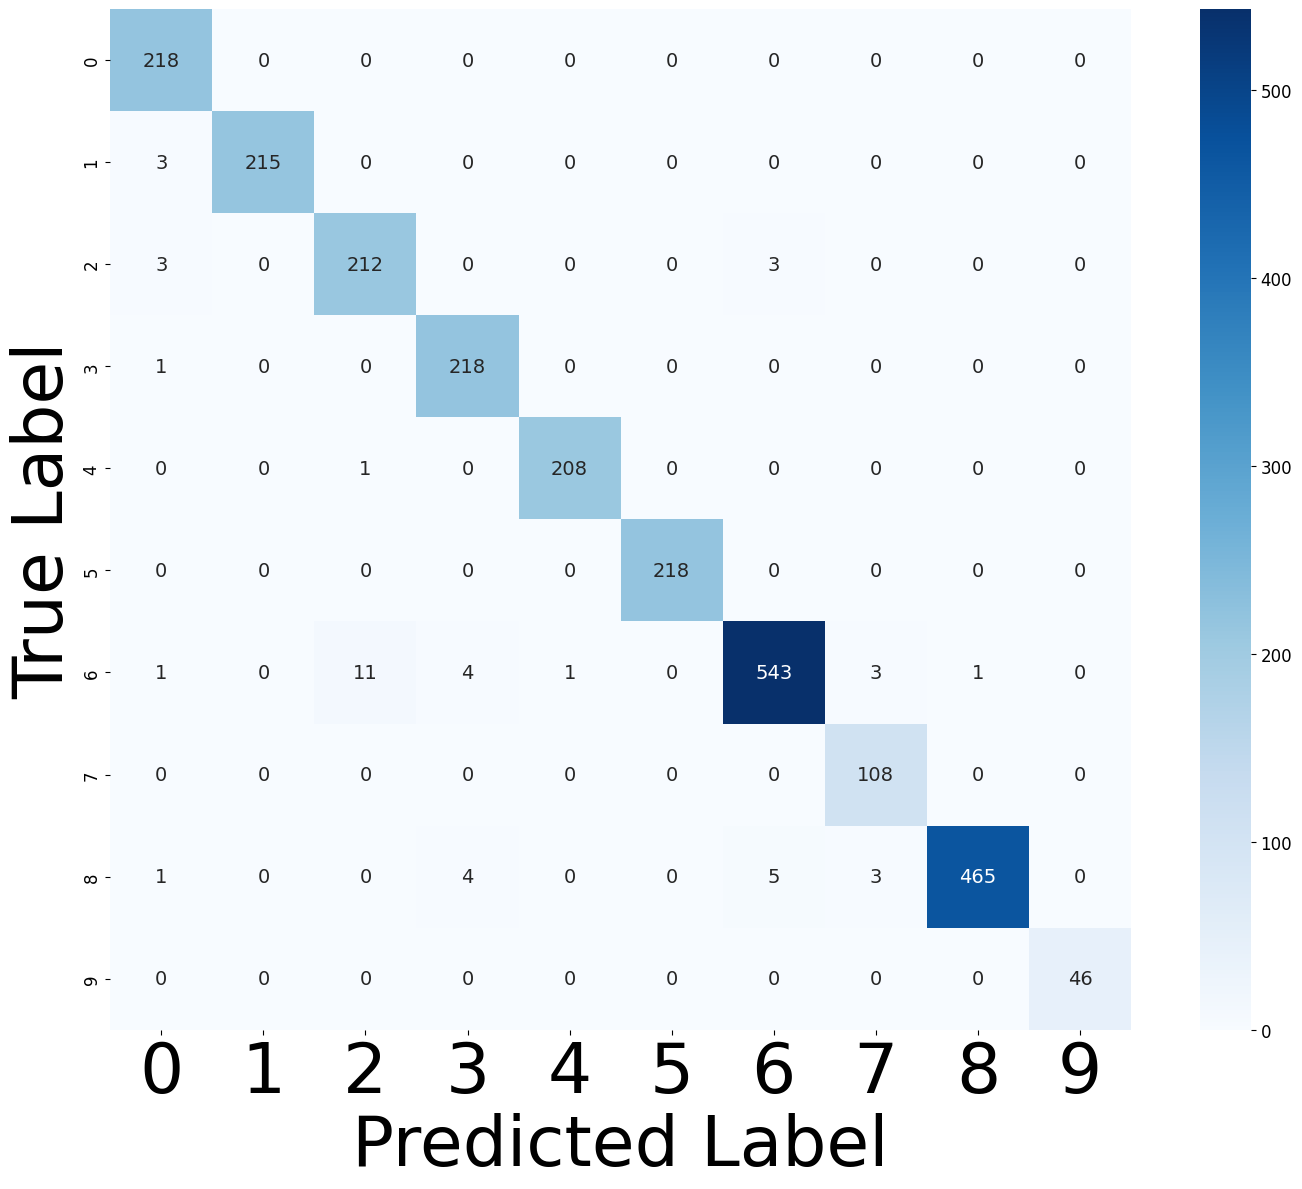

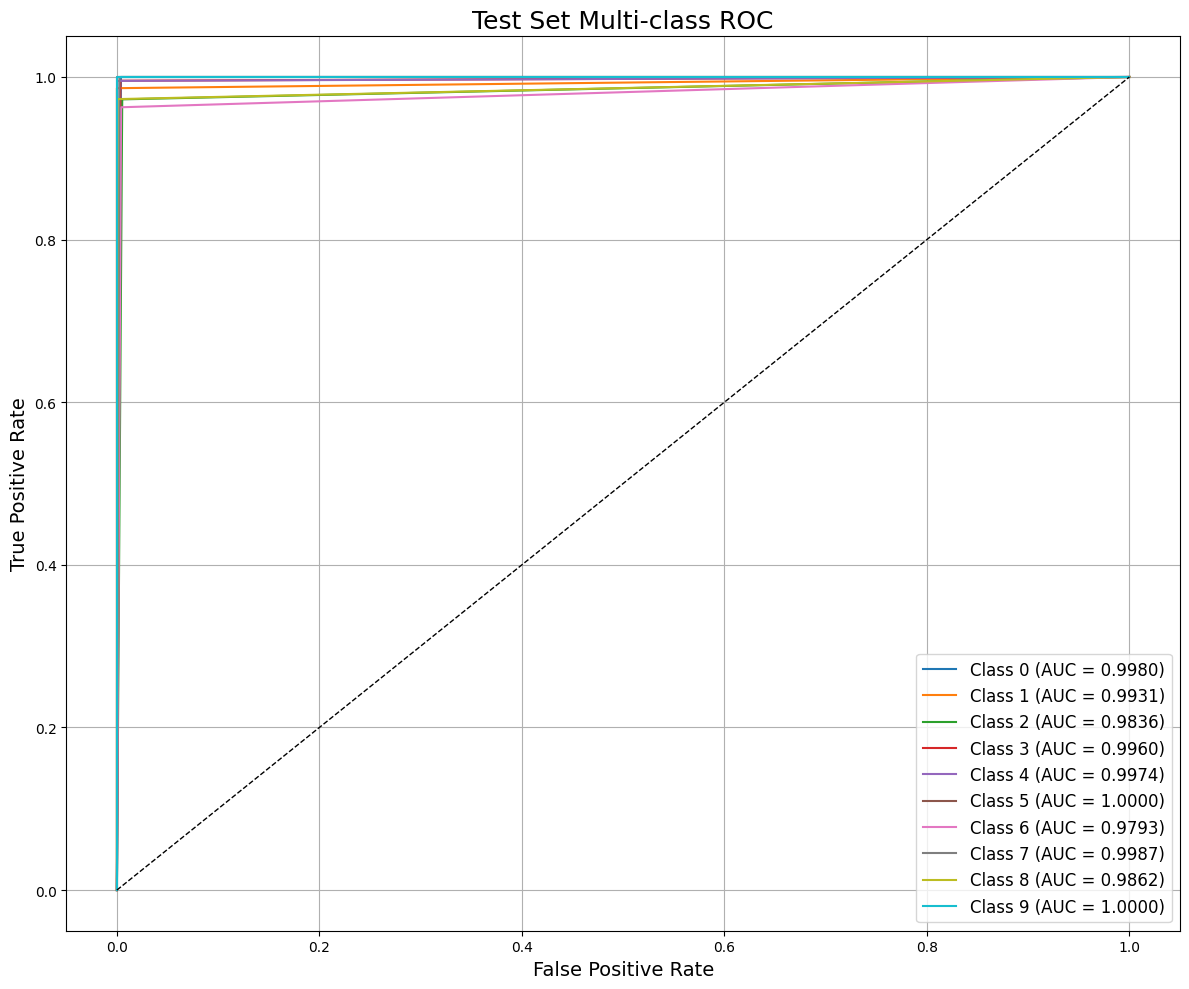

In [26]:
plot_test_confusion_and_roc(y_true, y_pred, num_classes=10)


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_test_confusion_and_roc(y_true, y_pred, num_classes=10):
    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    square=True,
    annot_kws={"size":20},  # Larger numbers inside cells
    cbar_kws={
        'shrink': 0.5,       # Resize the colorbar height
        'aspect': 10         # Controls colorbar thickness
    }
)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)  # Resize tick labels on the sidebar


    plt.xlabel('Predicted Label', fontsize=30)
    plt.ylabel('True Label', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 8))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=30)
    plt.ylabel('True Positive Rate', fontsize=30)
    plt.xticks(fontsize=27)
    plt.yticks(fontsize=27)
    plt.legend(loc='lower right', fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [60]:
def plot_confusion_and_roc_side_by_side(y_true, y_pred, num_classes=10):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred)

    # Make the confusion matrix panel wider
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=150, gridspec_kw={'width_ratios': [1.5, 1]})

    # === Confusion Matrix Plot ===
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=axes[0],
        annot_kws={"size": 18},  # Bigger numbers
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    axes[0].set_xlabel('Predicted Label', fontsize=18)
    axes[0].set_ylabel('True Label', fontsize=18)
    axes[0].tick_params(labelsize=16)
    axes[0].set_title('Confusion Matrix', fontsize=20)

    # === ROC Curve Plot ===
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1].set_xlabel('False Positive Rate', fontsize=18)
    axes[1].set_ylabel('True Positive Rate', fontsize=18)
    axes[1].tick_params(labelsize=16)
    axes[1].set_title('ROC Curve', fontsize=20)
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


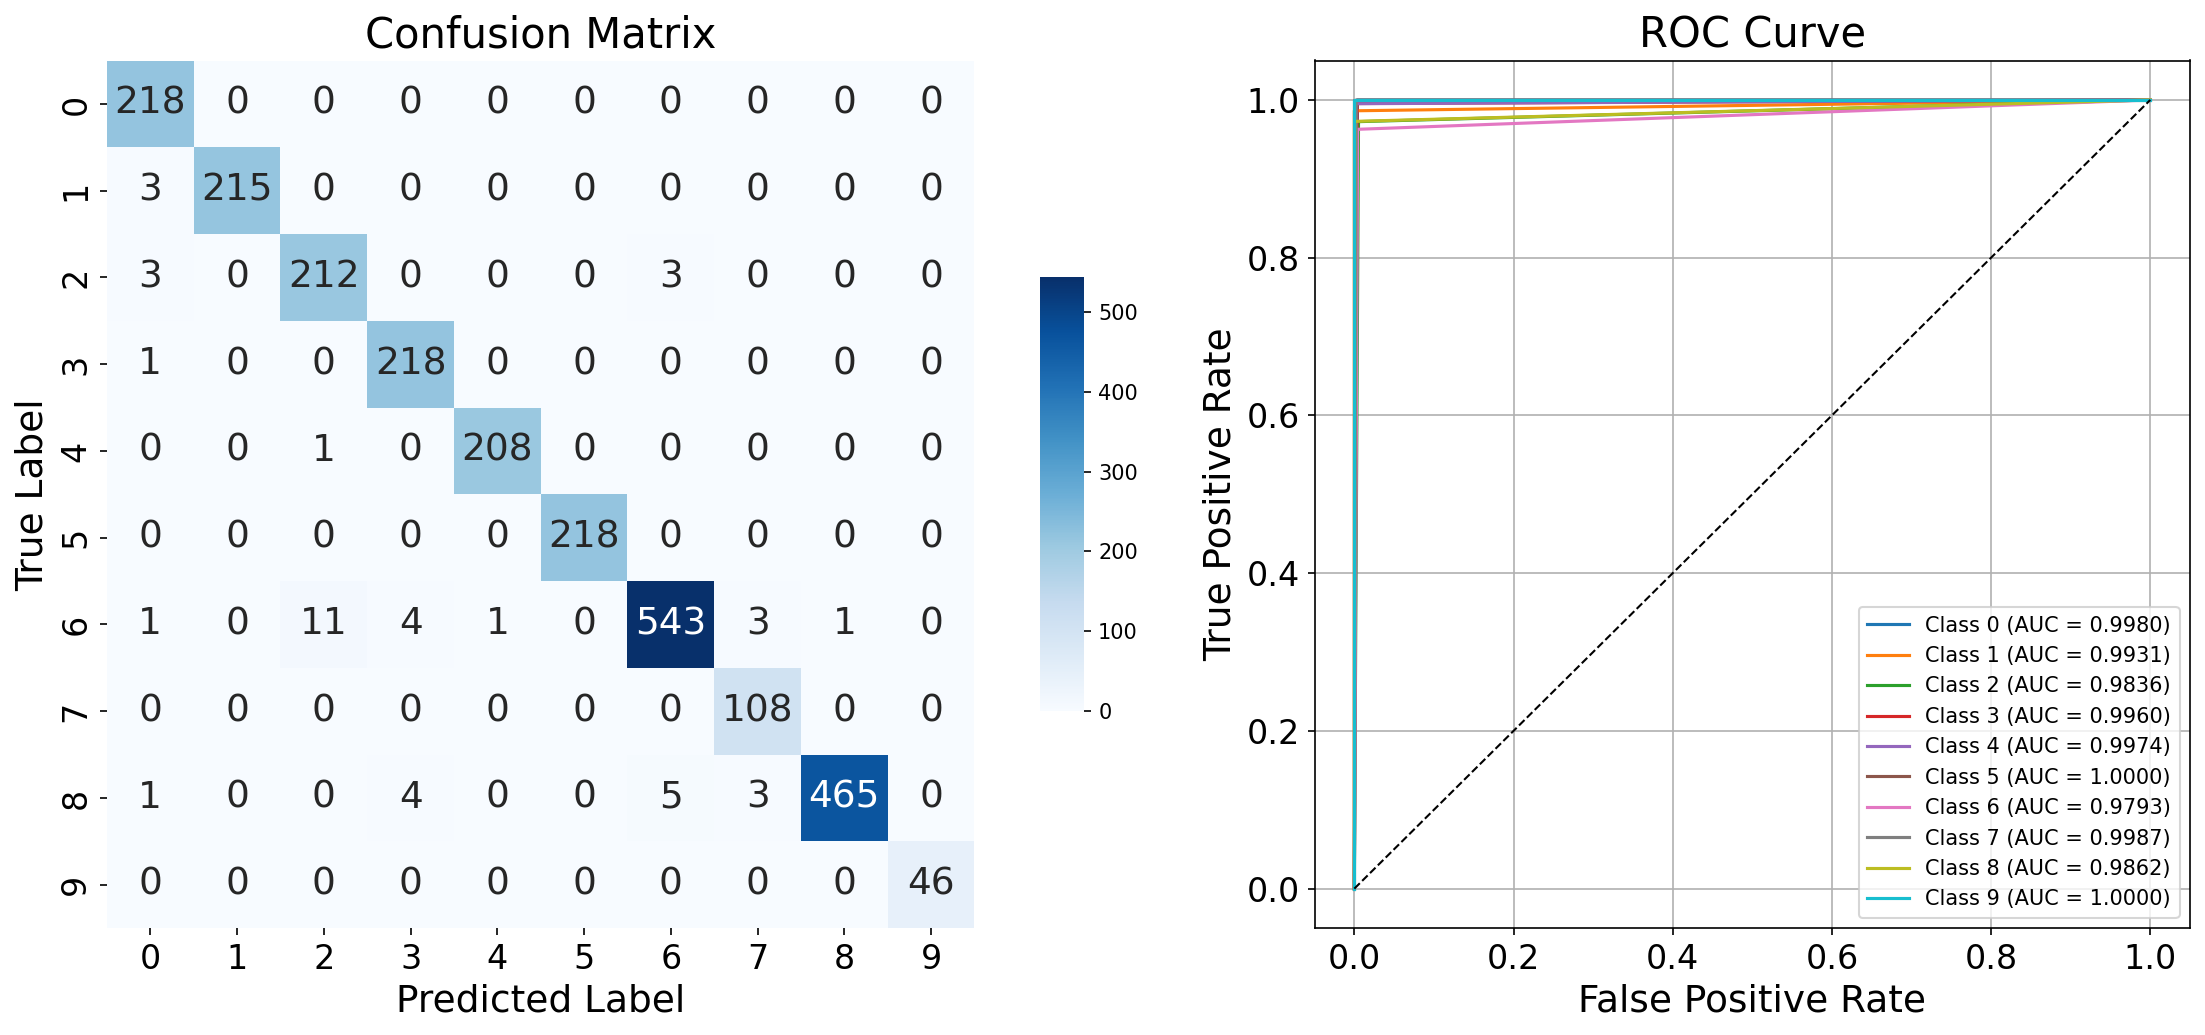

In [61]:
plot_confusion_and_roc_side_by_side(y_true, y_pred, num_classes=10)


In [62]:
def plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10):
    # same as your code above...
    
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred)

    # Make the confusion matrix panel wider
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=150, gridspec_kw={'width_ratios': [1.5, 1]})

    # === Confusion Matrix Plot ===
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=axes[0],
        annot_kws={"size": 18},  # Bigger numbers
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    axes[0].set_xlabel('Predicted Label', fontsize=18)
    axes[0].set_ylabel('True Label', fontsize=18)
    axes[0].tick_params(labelsize=16)
    axes[0].set_title('Confusion Matrix', fontsize=20)

    # === ROC Curve Plot ===
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1].set_xlabel('False Positive Rate', fontsize=18)
    axes[1].set_ylabel('True Positive Rate', fontsize=18)
    axes[1].tick_params(labelsize=16)
    axes[1].set_title('ROC Curve', fontsize=20)
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



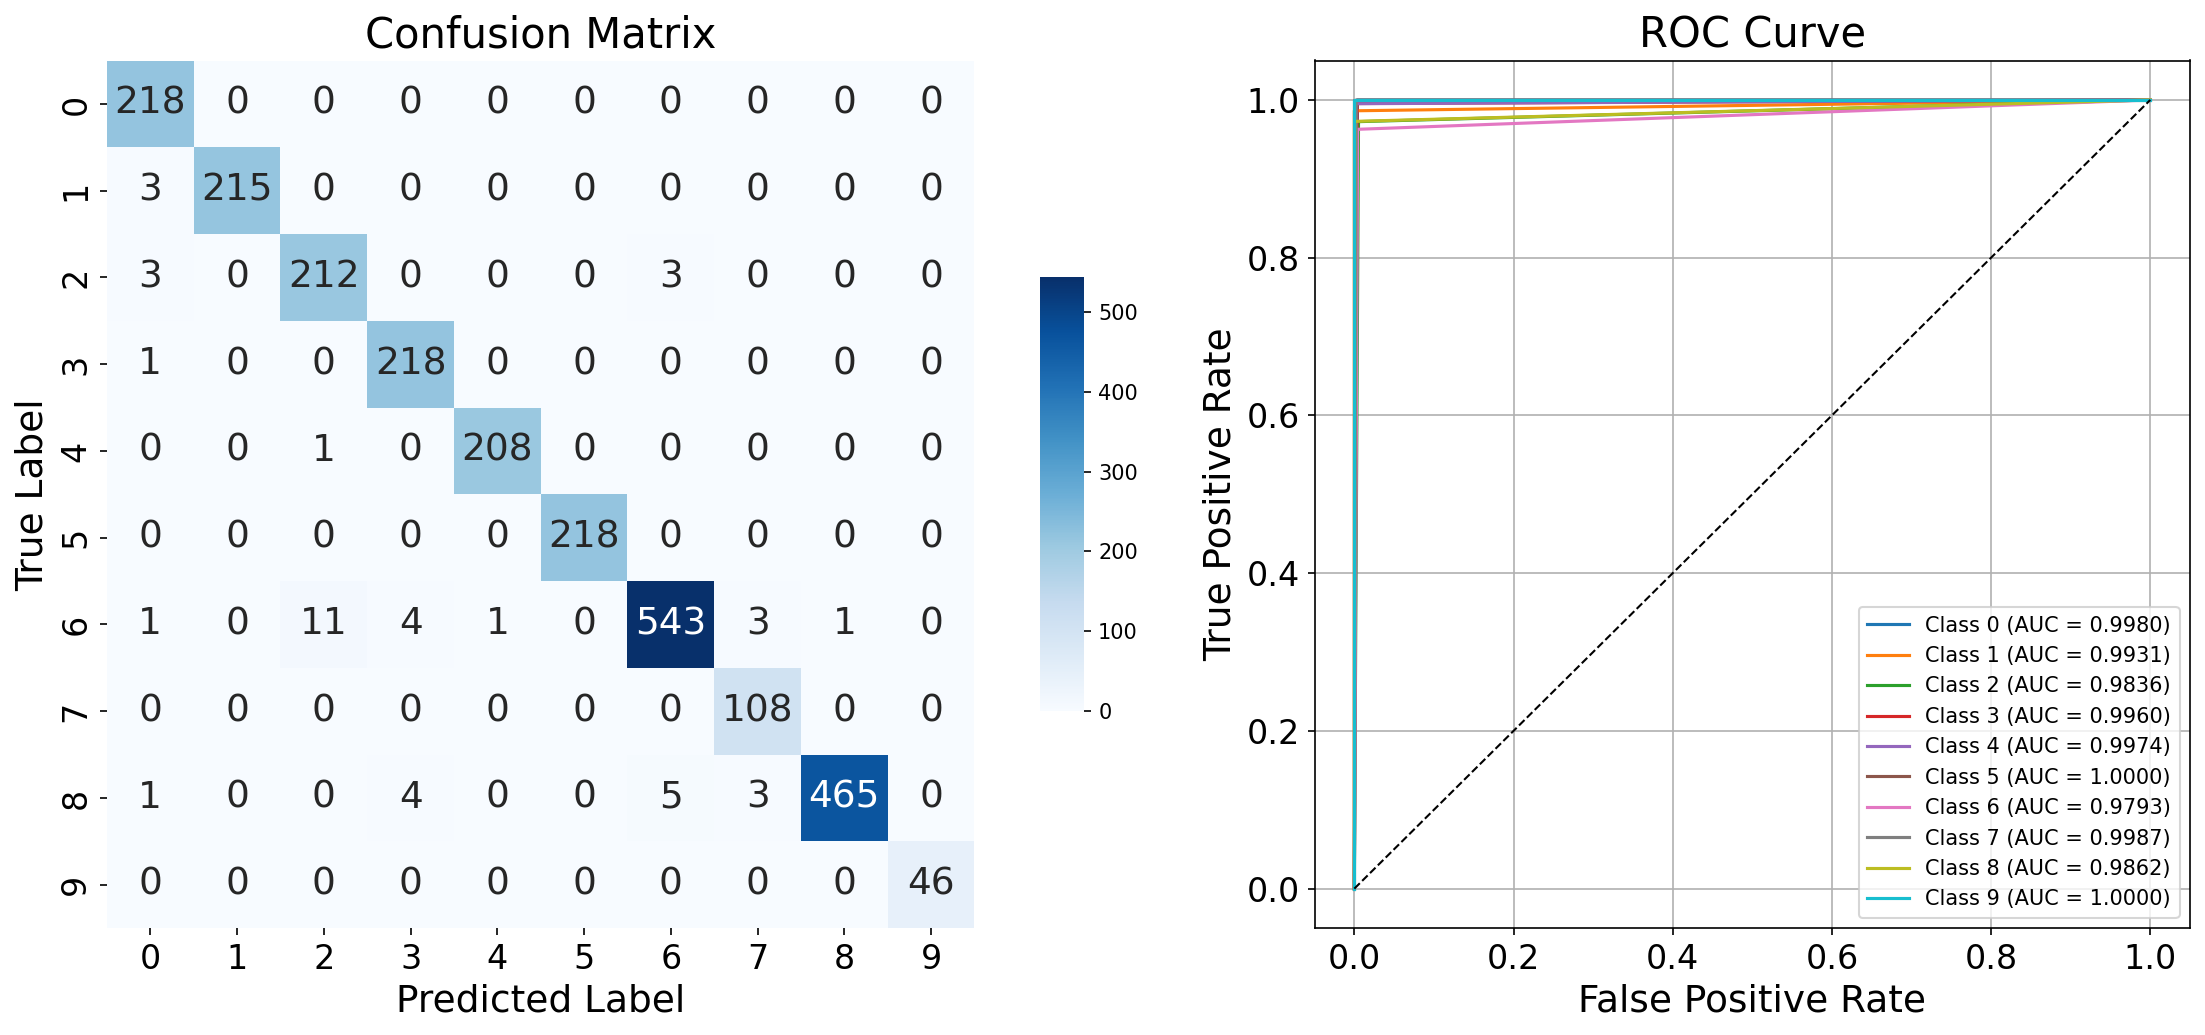

In [64]:
plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10)


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred)

    # === Confusion Matrix ===
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7), dpi=150)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=ax_cm,
        annot_kws={"size": 18},
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    ax_cm.set_xlabel('Predicted Label', fontsize=18)
    ax_cm.set_ylabel('True Label', fontsize=18)
    ax_cm.tick_params(labelsize=16)
    #ax_cm.set_title('Confusion Matrix', fontsize=20)
    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    fig_roc, ax_roc = plt.subplots(figsize=(8, 7), dpi=150)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax_roc.set_xlabel('False Positive Rate', fontsize=18)
    ax_roc.set_ylabel('True Positive Rate', fontsize=18)
    ax_roc.tick_params(labelsize=16)
    #ax_roc.set_title('ROC Curve', fontsize=20)
    ax_roc.legend(loc='lower right', fontsize=10)
    ax_roc.grid(True)
    plt.tight_layout()
    plt.show()


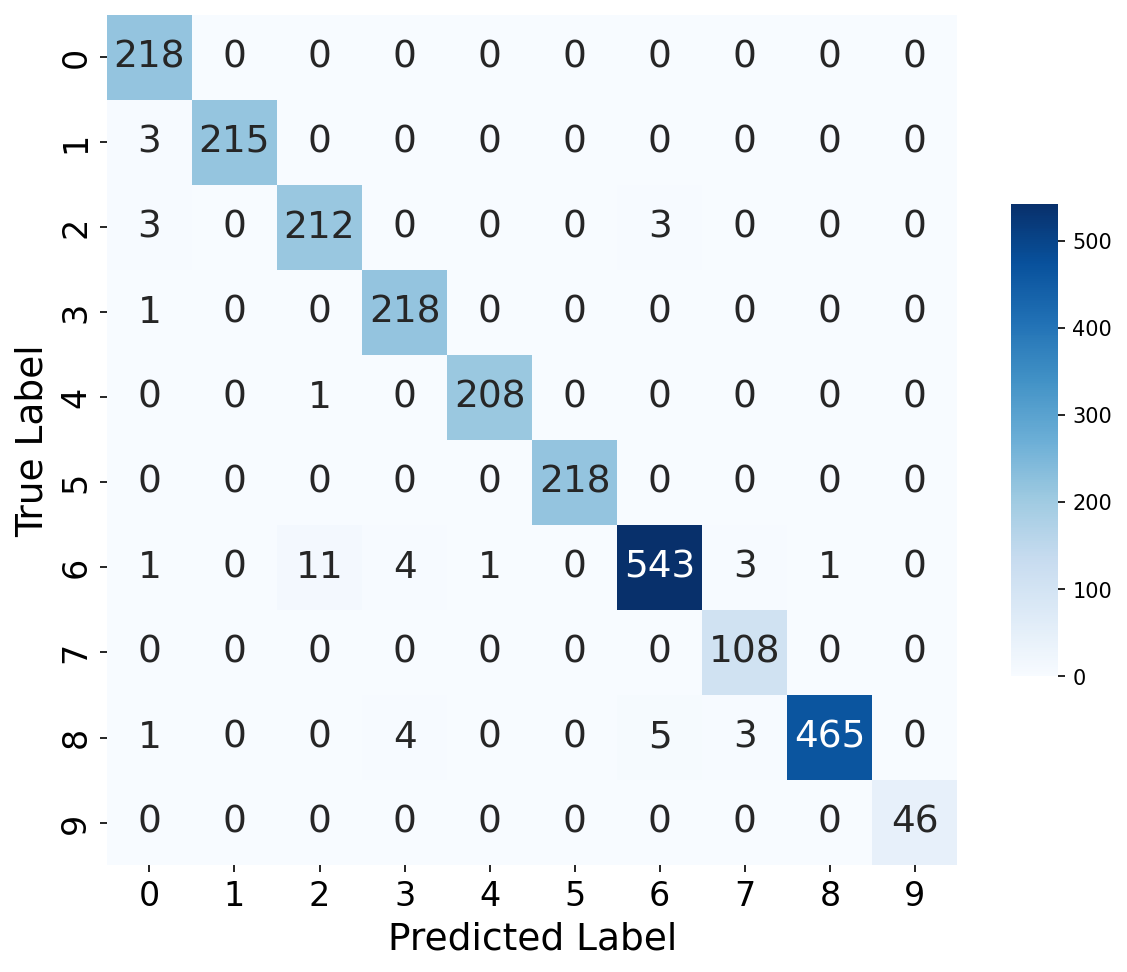

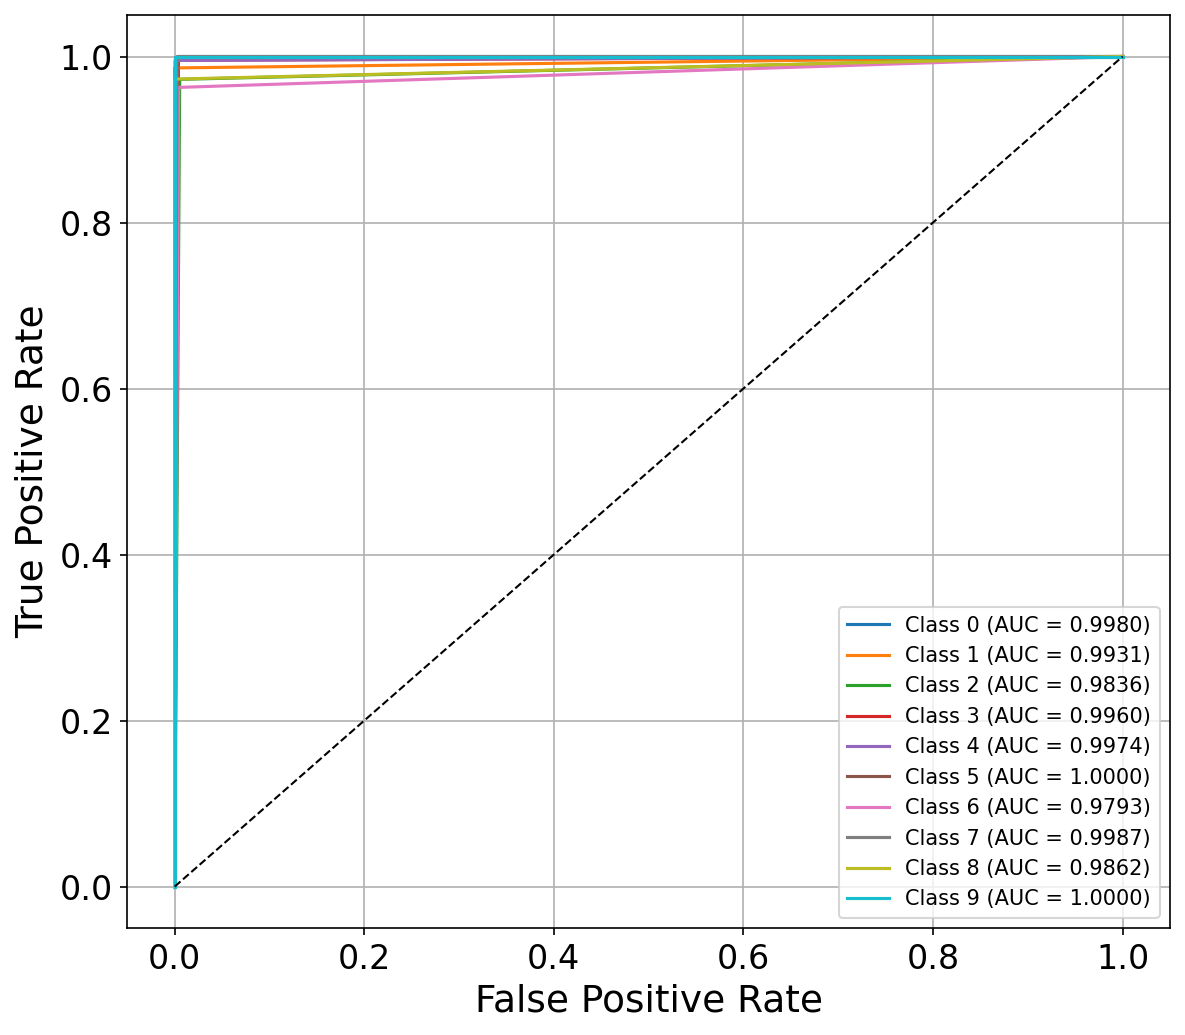

In [72]:
plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10)


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred)

    # === Confusion Matrix ===
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7), dpi=150)
    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=ax_cm,
        annot_kws={"size": 22},  # Bigger numbers inside cells
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    ax_cm.set_xlabel('Predicted Label', fontsize=30)
    ax_cm.set_ylabel('True Label', fontsize=30)
    ax_cm.tick_params(labelsize=30)

    # ✅ Increase the sidebar tick font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)


    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    fig_roc, ax_roc = plt.subplots(figsize=(8, 7), dpi=150)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax_roc.set_xlabel('False Positive Rate', fontsize=30)
    ax_roc.set_ylabel('True Positive Rate', fontsize=30)
    ax_roc.tick_params(labelsize=30)
    ax_roc.legend(loc='lower right', fontsize=23)
    # Place the legend outside the plot to the right
#     ax_roc.legend(
#     loc='center left',
#     bbox_to_anchor=(1.02, 0.5),
#     fontsize=22,
#     borderaxespad=0,
#     frameon=True
# )

    ax_roc.grid(True)
    plt.tight_layout()
    plt.show()


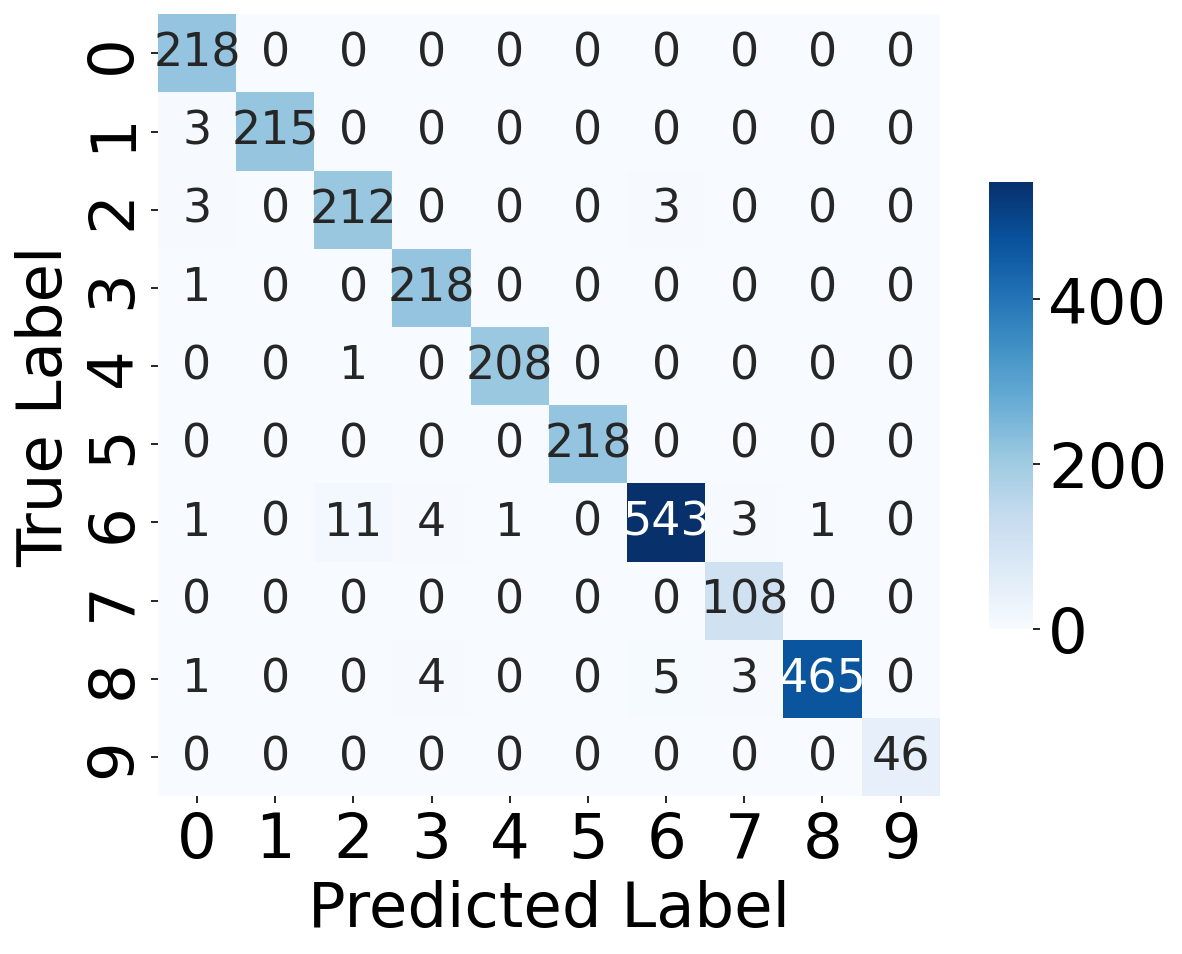

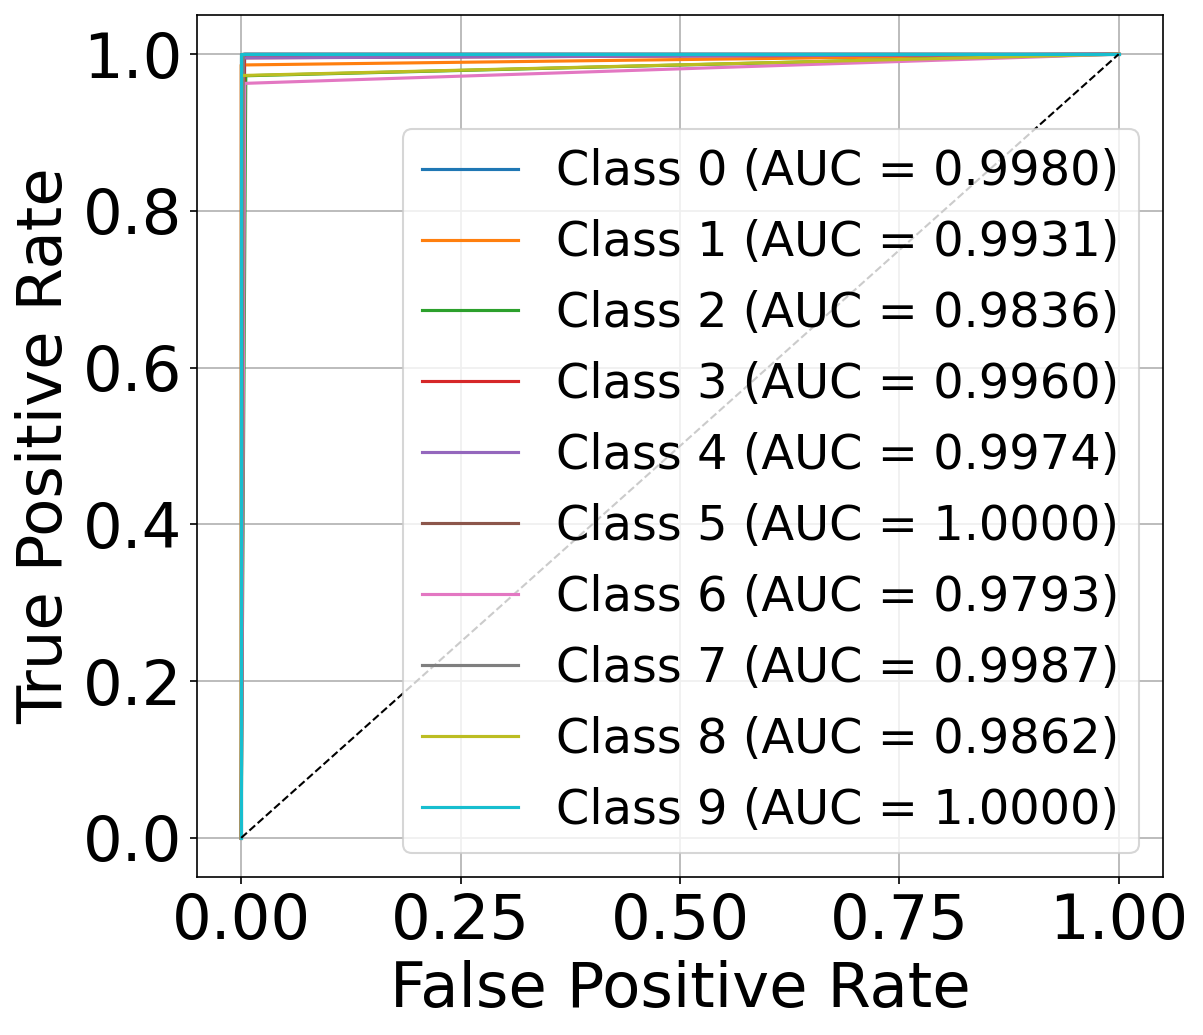

In [143]:
plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10)


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_confusion_and_roc_side_by_side(y_true, y_pred, num_classes=10):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))
    cm = confusion_matrix(y_true, y_pred)

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

     # === Confusion Matrix Plot ===
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=axes[0],
        annot_kws={"size": 14},
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    axes[0].set_xlabel('Predicted Label', fontsize=16)
    axes[0].set_ylabel('True Label', fontsize=16)
    axes[0].tick_params(labelsize=13)
    axes[0].set_title('Confusion Matrix', fontsize=18)


    # === ROC Curve Plot ===
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1].set_xlabel('False Positive Rate', fontsize=14)
    axes[1].set_ylabel('True Positive Rate', fontsize=14)
    axes[1].tick_params(labelsize=12)
    axes[1].set_title('ROC Curve', fontsize=16)
    axes[1].legend(loc='lower right', fontsize=8)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


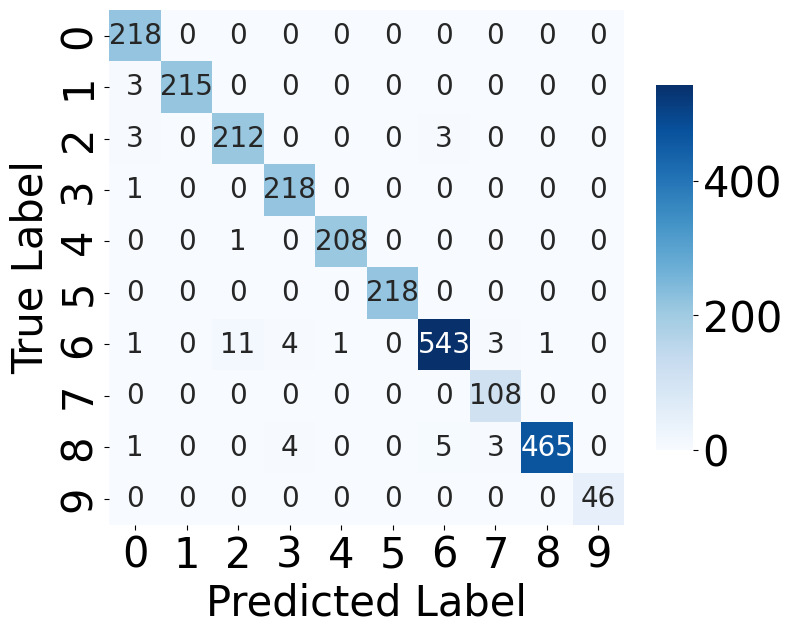

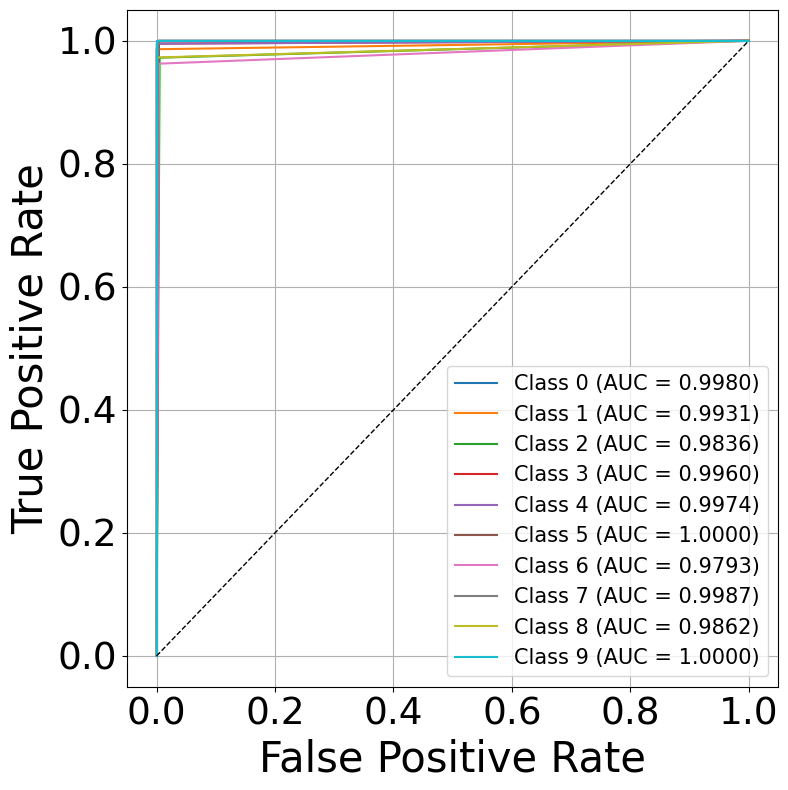

In [59]:
plot_test_confusion_and_roc(y_true, y_pred, num_classes=10)


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_loss_accuracy(cv_history, num_epochs):
    train_loss_all = np.array(cv_history['train_loss'])  # Shape: (folds, epochs)
    val_loss_all   = np.array(cv_history['val_loss'])
    train_acc_all  = np.array(cv_history['train_acc'])
    val_acc_all    = np.array(cv_history['val_acc'])

    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss   = np.mean(val_loss_all, axis=0)
    avg_train_acc  = np.mean(train_acc_all, axis=0)
    avg_val_acc    = np.mean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Average Accuracy Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_loss_accuracy(cv_history, num_epochs):
    train_loss_all = np.array(cv_history['train_loss'])  # Shape: (folds, epochs)
    val_loss_all   = np.array(cv_history['val_loss'])
    train_acc_all  = np.array(cv_history['train_acc'])
    val_acc_all    = np.array(cv_history['val_acc'])

    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss   = np.mean(val_loss_all, axis=0)
    avg_train_acc  = np.mean(train_acc_all, axis=0)
    avg_val_acc    = np.mean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(8, 9))  # Square figure
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title("Average Loss Over Epochs (Across Folds)", fontsize=20)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(8, 9))  # Square figure
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy (%)", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title("Average Accuracy Over Epochs (Across Folds)", fontsize=20)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


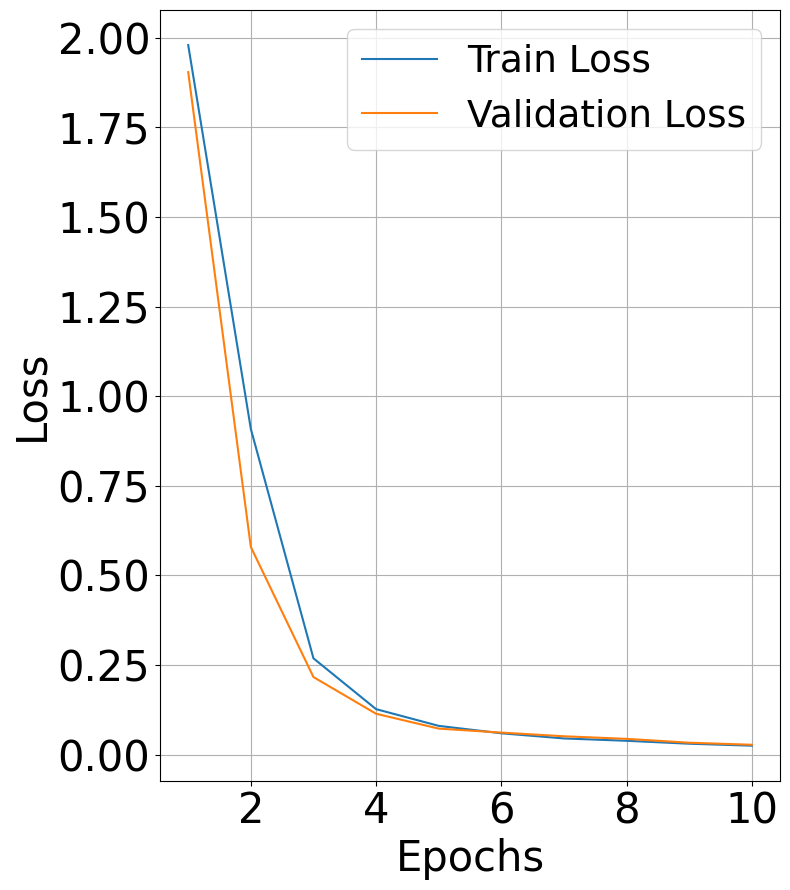

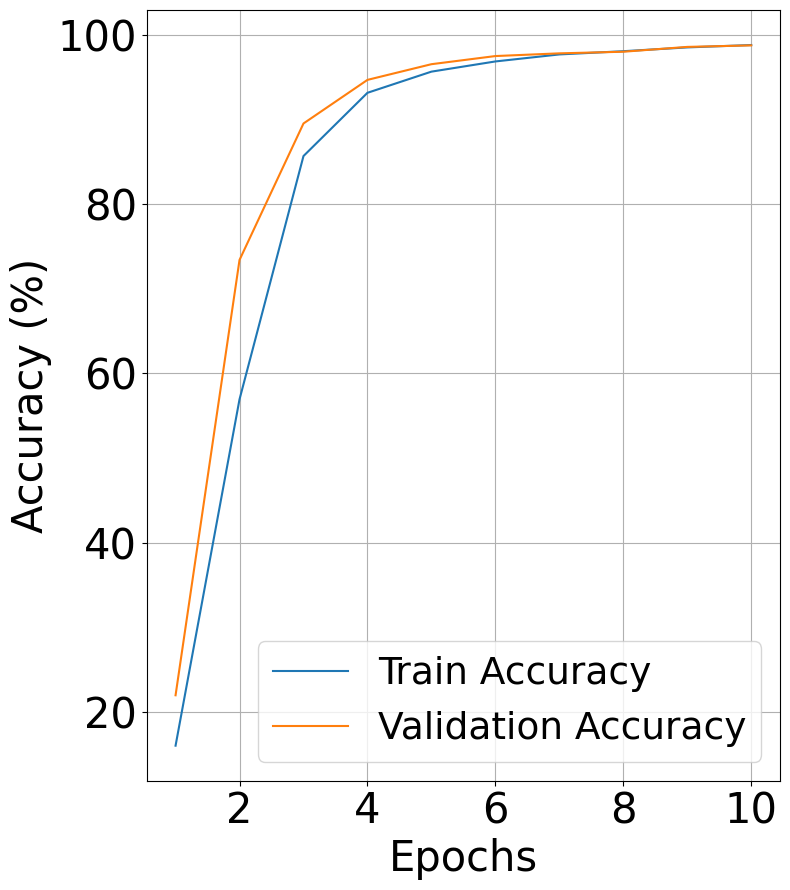

=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.8091           99.2993      0.0243    0.0115   
1   Fold 2             98.7201           98.7988      0.0254    0.0254   
2   Fold 3             98.6533           98.6987      0.0300    0.0243   
3   Fold 4             99.2654           98.6987      0.0136    0.0360   
4   Fold 5             98.5756           98.7976      0.0306    0.0275   
5   Fold 6             98.8872           98.9980      0.0270    0.0446   
6   Fold 7             98.8983           98.9980      0.0225    0.0173   
7   Fold 8             98.9762           99.0982      0.0202    0.0140   
8   Fold 9             98.8872           97.8958      0.0209    0.0451   
9  Fold 10             98.2083           98.1964      0.0371    0.0318   

   Val Macro F1  
0        0.9946  
1        0.9901  
2        0.9884  
3        0.9881  
4        0.9909  
5        0.9892  
6        0.9904  
7        0.9923 

In [54]:
# Step 3: Plot average loss and accuracy over epochs
plot_avg_loss_accuracy(cv_history, num_epochs=10)

# Step 4: Plot confusion matrix and ROC for best fold only
best_fold_idx = summary_df['Val Macro F1'].idxmax()
best_fold_preds = fold_preds[best_fold_idx]  # (y_true, y_pred, fold)


# Step 5: Print summary
print("=== Per-Fold Summary ===")
print(summary_df.round(4))


In [55]:
from sklearn.metrics import classification_report

# Step 1: Get index of best fold (highest macro F1)
best_fold_idx = summary_df['Val Macro F1'].idxmax()
best_y_true, best_y_pred, best_fold = fold_preds[best_fold_idx]

# Step 2: Print best fold number
print(f"\nBest fold is Fold {best_fold + 1}\n")

# Step 3: Print classification report
print("=== Classification Report ===")
print(classification_report(best_y_true, best_y_pred, digits=4))



Best fold is Fold 1

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9886    1.0000    0.9943        87
           1     0.9888    1.0000    0.9944        88
           2     0.9885    0.9885    0.9885        87
           3     0.9778    1.0000    0.9888        88
           4     1.0000    1.0000    1.0000        84
           5     1.0000    1.0000    1.0000        87
           6     0.9912    0.9912    0.9912       226
           7     1.0000    1.0000    1.0000        43
           8     1.0000    0.9791    0.9894       191
           9     1.0000    1.0000    1.0000        18

    accuracy                         0.9930       999
   macro avg     0.9935    0.9959    0.9946       999
weighted avg     0.9931    0.9930    0.9930       999



In [ ]:
# # Define Stratified KFold splitter
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Run cross-validation training
# cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=16)



=== Fold 1 ===


Epoch 1: Train Loss=2.1125, Val Loss=2.4868, Train Acc=9.91%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.1206, Val Loss=0.6927, Train Acc=44.30%, Val Acc=66.87%, Val Macro-F1=0.6821


Epoch 3: Train Loss=0.3252, Val Loss=0.2324, Train Acc=81.26%, Val Acc=86.59%, Val Macro-F1=0.8877


Epoch 4: Train Loss=0.1266, Val Loss=0.1484, Train Acc=92.43%, Val Acc=93.19%, Val Macro-F1=0.9388


Epoch 5: Train Loss=0.0762, Val Loss=0.0658, Train Acc=95.60%, Val Acc=95.70%, Val Macro-F1=0.9654


Epoch 6: Train Loss=0.0509, Val Loss=0.0631, Train Acc=96.89%, Val Acc=96.20%, Val Macro-F1=0.9689


Epoch 7: Train Loss=0.0429, Val Loss=0.0498, Train Acc=97.58%, Val Acc=96.90%, Val Macro-F1=0.9716


Epoch 8: Train Loss=0.0504, Val Loss=0.0385, Train Acc=97.41%, Val Acc=98.00%, Val Macro-F1=0.9848


Epoch 9: Train Loss=0.0220, Val Loss=0.0283, Train Acc=98.62%, Val Acc=98.40%, Val Macro-F1=0.9877


Epoch 10: Train Loss=0.0253, Val Loss=0.0226, Train Acc=98.74%, Val Acc=98.80%, Val Macro-F1=0.9891

=== Fold 2 ===


Epoch 1: Train Loss=1.9521, Val Loss=1.9359, Train Acc=14.66%, Val Acc=18.52%, Val Macro-F1=0.1461


Epoch 2: Train Loss=0.8794, Val Loss=0.4561, Train Acc=54.30%, Val Acc=76.28%, Val Macro-F1=0.7816


Epoch 3: Train Loss=0.2710, Val Loss=0.1637, Train Acc=84.35%, Val Acc=90.79%, Val Macro-F1=0.9201


Epoch 4: Train Loss=0.1169, Val Loss=0.0994, Train Acc=93.03%, Val Acc=94.39%, Val Macro-F1=0.9545


Epoch 5: Train Loss=0.0916, Val Loss=0.0773, Train Acc=94.92%, Val Acc=96.70%, Val Macro-F1=0.9714


Epoch 6: Train Loss=0.0512, Val Loss=0.0444, Train Acc=96.82%, Val Acc=97.40%, Val Macro-F1=0.9775


Epoch 7: Train Loss=0.0450, Val Loss=0.0371, Train Acc=97.30%, Val Acc=97.90%, Val Macro-F1=0.9809


Epoch 8: Train Loss=0.0326, Val Loss=0.0614, Train Acc=97.87%, Val Acc=98.50%, Val Macro-F1=0.9834


Epoch 9: Train Loss=0.0272, Val Loss=0.0389, Train Acc=98.54%, Val Acc=99.00%, Val Macro-F1=0.9920


Epoch 10: Train Loss=0.0330, Val Loss=0.2814, Train Acc=98.21%, Val Acc=91.89%, Val Macro-F1=0.8921

=== Fold 3 ===


Epoch 1: Train Loss=2.0538, Val Loss=2.1534, Train Acc=11.07%, Val Acc=9.71%, Val Macro-F1=0.0711


Epoch 2: Train Loss=0.9382, Val Loss=0.5882, Train Acc=50.32%, Val Acc=71.67%, Val Macro-F1=0.7466


Epoch 3: Train Loss=0.3122, Val Loss=0.2592, Train Acc=82.30%, Val Acc=87.99%, Val Macro-F1=0.8910


Epoch 4: Train Loss=0.1573, Val Loss=0.1753, Train Acc=90.65%, Val Acc=91.39%, Val Macro-F1=0.9232


Epoch 5: Train Loss=0.1040, Val Loss=0.1892, Train Acc=93.75%, Val Acc=92.49%, Val Macro-F1=0.9222


Epoch 6: Train Loss=0.0759, Val Loss=0.0748, Train Acc=95.36%, Val Acc=95.40%, Val Macro-F1=0.9642


Epoch 7: Train Loss=0.0502, Val Loss=0.0595, Train Acc=96.95%, Val Acc=97.30%, Val Macro-F1=0.9774


Epoch 8: Train Loss=0.0409, Val Loss=0.0487, Train Acc=97.54%, Val Acc=97.50%, Val Macro-F1=0.9770


Epoch 9: Train Loss=0.0450, Val Loss=0.0521, Train Acc=97.52%, Val Acc=97.60%, Val Macro-F1=0.9802


Epoch 10: Train Loss=0.0332, Val Loss=0.0319, Train Acc=98.22%, Val Acc=98.80%, Val Macro-F1=0.9888

=== Fold 4 ===


Epoch 1: Train Loss=1.7569, Val Loss=1.5259, Train Acc=21.37%, Val Acc=38.14%, Val Macro-F1=0.4247


Epoch 2: Train Loss=0.5141, Val Loss=0.2570, Train Acc=71.94%, Val Acc=85.89%, Val Macro-F1=0.8795


Epoch 3: Train Loss=0.1643, Val Loss=0.1269, Train Acc=90.02%, Val Acc=93.19%, Val Macro-F1=0.9430


Epoch 4: Train Loss=0.0882, Val Loss=0.0665, Train Acc=94.39%, Val Acc=96.60%, Val Macro-F1=0.9691


Epoch 5: Train Loss=0.0720, Val Loss=0.0300, Train Acc=96.26%, Val Acc=98.60%, Val Macro-F1=0.9888


Epoch 6: Train Loss=0.0448, Val Loss=0.0328, Train Acc=97.42%, Val Acc=98.40%, Val Macro-F1=0.9852


Epoch 7: Train Loss=0.0337, Val Loss=0.1140, Train Acc=98.11%, Val Acc=96.20%, Val Macro-F1=0.9487


Epoch 8: Train Loss=0.0348, Val Loss=0.0175, Train Acc=98.35%, Val Acc=99.10%, Val Macro-F1=0.9927


Epoch 9: Train Loss=0.0217, Val Loss=0.0228, Train Acc=98.76%, Val Acc=98.80%, Val Macro-F1=0.9894


Epoch 10: Train Loss=0.0212, Val Loss=0.0246, Train Acc=98.92%, Val Acc=98.70%, Val Macro-F1=0.9889

=== Fold 5 ===


Epoch 1: Train Loss=2.1278, Val Loss=2.4615, Train Acc=9.43%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=2.0841, Val Loss=2.5247, Train Acc=10.41%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 3: Train Loss=2.0984, Val Loss=2.4927, Train Acc=10.13%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 4: Train Loss=2.1148, Val Loss=2.5300, Train Acc=9.13%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 5: Train Loss=2.0900, Val Loss=2.4784, Train Acc=9.99%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 6: Train Loss=2.0607, Val Loss=2.3462, Train Acc=10.57%, Val Acc=13.43%, Val Macro-F1=0.0688


Epoch 7: Train Loss=1.0323, Val Loss=0.6936, Train Acc=47.30%, Val Acc=67.13%, Val Macro-F1=0.6852


Epoch 8: Train Loss=0.3468, Val Loss=0.2727, Train Acc=79.50%, Val Acc=85.27%, Val Macro-F1=0.8710


Epoch 9: Train Loss=0.1954, Val Loss=0.1484, Train Acc=88.22%, Val Acc=92.08%, Val Macro-F1=0.9308


Epoch 10: Train Loss=0.1325, Val Loss=0.1148, Train Acc=92.25%, Val Acc=92.79%, Val Macro-F1=0.9360

=== Fold 6 ===


Epoch 1: Train Loss=1.9804, Val Loss=1.9050, Train Acc=13.94%, Val Acc=18.44%, Val Macro-F1=0.1475


Epoch 2: Train Loss=0.8001, Val Loss=0.4747, Train Acc=57.76%, Val Acc=77.45%, Val Macro-F1=0.7951


Epoch 3: Train Loss=0.2690, Val Loss=0.3439, Train Acc=85.07%, Val Acc=84.07%, Val Macro-F1=0.8577


Epoch 4: Train Loss=0.1326, Val Loss=0.1196, Train Acc=92.22%, Val Acc=94.39%, Val Macro-F1=0.9504


Epoch 5: Train Loss=0.0765, Val Loss=0.0971, Train Acc=95.43%, Val Acc=95.69%, Val Macro-F1=0.9605


Epoch 6: Train Loss=0.0688, Val Loss=0.0981, Train Acc=96.23%, Val Acc=96.59%, Val Macro-F1=0.9688


Epoch 7: Train Loss=0.0437, Val Loss=0.0610, Train Acc=97.37%, Val Acc=98.10%, Val Macro-F1=0.9820


Epoch 8: Train Loss=0.0400, Val Loss=0.0670, Train Acc=97.60%, Val Acc=97.90%, Val Macro-F1=0.9816


Epoch 9: Train Loss=0.0329, Val Loss=0.0463, Train Acc=98.07%, Val Acc=98.50%, Val Macro-F1=0.9847


Epoch 10: Train Loss=0.0252, Val Loss=0.0407, Train Acc=98.75%, Val Acc=98.80%, Val Macro-F1=0.9879

=== Fold 7 ===


Epoch 1: Train Loss=2.1012, Val Loss=2.4434, Train Acc=10.17%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.0572, Val Loss=0.5894, Train Acc=47.32%, Val Acc=74.05%, Val Macro-F1=0.7427


Epoch 3: Train Loss=0.2962, Val Loss=0.1905, Train Acc=83.80%, Val Acc=90.18%, Val Macro-F1=0.9217


Epoch 4: Train Loss=0.1442, Val Loss=0.1541, Train Acc=91.71%, Val Acc=91.28%, Val Macro-F1=0.9282


Epoch 5: Train Loss=0.0905, Val Loss=0.0664, Train Acc=94.51%, Val Acc=95.99%, Val Macro-F1=0.9671


Epoch 6: Train Loss=0.0608, Val Loss=0.0492, Train Acc=96.48%, Val Acc=98.10%, Val Macro-F1=0.9837


Epoch 7: Train Loss=0.0455, Val Loss=0.0360, Train Acc=97.37%, Val Acc=97.70%, Val Macro-F1=0.9824


Epoch 8: Train Loss=0.0315, Val Loss=0.0274, Train Acc=98.13%, Val Acc=98.40%, Val Macro-F1=0.9872


Epoch 9: Train Loss=0.0408, Val Loss=0.0290, Train Acc=97.85%, Val Acc=98.30%, Val Macro-F1=0.9870


Epoch 10: Train Loss=0.0370, Val Loss=0.0131, Train Acc=98.31%, Val Acc=99.40%, Val Macro-F1=0.9958

=== Fold 8 ===


Epoch 1: Train Loss=2.1251, Val Loss=2.4365, Train Acc=9.77%, Val Acc=1.80%, Val Macro-F1=0.0035


Epoch 2: Train Loss=1.2213, Val Loss=0.7530, Train Acc=41.66%, Val Acc=65.93%, Val Macro-F1=0.6898


Epoch 3: Train Loss=0.3259, Val Loss=0.1934, Train Acc=81.58%, Val Acc=89.28%, Val Macro-F1=0.9097


Epoch 4: Train Loss=0.1446, Val Loss=0.0876, Train Acc=91.80%, Val Acc=95.09%, Val Macro-F1=0.9543


Epoch 5: Train Loss=0.0771, Val Loss=0.0964, Train Acc=95.58%, Val Acc=95.59%, Val Macro-F1=0.9574


Epoch 6: Train Loss=0.0584, Val Loss=0.0491, Train Acc=96.67%, Val Acc=97.70%, Val Macro-F1=0.9813


Epoch 7: Train Loss=0.0419, Val Loss=0.0272, Train Acc=97.73%, Val Acc=98.50%, Val Macro-F1=0.9873


Epoch 8: Train Loss=0.0341, Val Loss=0.0254, Train Acc=98.02%, Val Acc=98.60%, Val Macro-F1=0.9888


Epoch 9: Train Loss=0.0256, Val Loss=0.0218, Train Acc=98.56%, Val Acc=98.40%, Val Macro-F1=0.9841


Epoch 10: Train Loss=0.0282, Val Loss=0.0219, Train Acc=98.34%, Val Acc=99.10%, Val Macro-F1=0.9931

=== Fold 9 ===


Epoch 1: Train Loss=1.8317, Val Loss=1.7375, Train Acc=18.71%, Val Acc=26.15%, Val Macro-F1=0.2695


Epoch 2: Train Loss=0.6192, Val Loss=0.4365, Train Acc=67.74%, Val Acc=77.86%, Val Macro-F1=0.8059


Epoch 3: Train Loss=0.2122, Val Loss=0.2358, Train Acc=87.67%, Val Acc=86.77%, Val Macro-F1=0.8824


Epoch 4: Train Loss=0.1199, Val Loss=0.1278, Train Acc=92.79%, Val Acc=93.49%, Val Macro-F1=0.9413


Epoch 5: Train Loss=0.0690, Val Loss=0.0694, Train Acc=95.64%, Val Acc=96.39%, Val Macro-F1=0.9720


Epoch 6: Train Loss=0.0567, Val Loss=0.0837, Train Acc=96.80%, Val Acc=96.69%, Val Macro-F1=0.9713


Epoch 7: Train Loss=0.0464, Val Loss=0.0703, Train Acc=97.15%, Val Acc=97.39%, Val Macro-F1=0.9734


Epoch 8: Train Loss=0.0312, Val Loss=0.0755, Train Acc=98.12%, Val Acc=97.60%, Val Macro-F1=0.9756


Epoch 9: Train Loss=0.0279, Val Loss=0.0342, Train Acc=98.35%, Val Acc=98.80%, Val Macro-F1=0.9876


Epoch 10: Train Loss=0.0403, Val Loss=0.0427, Train Acc=98.19%, Val Acc=98.70%, Val Macro-F1=0.9883

=== Fold 10 ===


Epoch 1: Train Loss=2.0082, Val Loss=1.9887, Train Acc=12.96%, Val Acc=16.33%, Val Macro-F1=0.1196


Epoch 2: Train Loss=0.8808, Val Loss=0.5441, Train Acc=54.71%, Val Acc=73.65%, Val Macro-F1=0.7576


Epoch 3: Train Loss=0.2816, Val Loss=0.2139, Train Acc=84.58%, Val Acc=87.88%, Val Macro-F1=0.9000


Epoch 4: Train Loss=0.1482, Val Loss=0.1039, Train Acc=91.63%, Val Acc=94.49%, Val Macro-F1=0.9573


Epoch 5: Train Loss=0.0960, Val Loss=0.0808, Train Acc=94.51%, Val Acc=95.79%, Val Macro-F1=0.9658


Epoch 6: Train Loss=0.0618, Val Loss=0.0608, Train Acc=96.36%, Val Acc=97.70%, Val Macro-F1=0.9820


Epoch 7: Train Loss=0.0628, Val Loss=0.0487, Train Acc=96.47%, Val Acc=96.99%, Val Macro-F1=0.9754


Epoch 8: Train Loss=0.0395, Val Loss=0.0286, Train Acc=97.83%, Val Acc=98.20%, Val Macro-F1=0.9885


Epoch 9: Train Loss=0.0318, Val Loss=0.0318, Train Acc=98.32%, Val Acc=98.00%, Val Macro-F1=0.9853


Epoch 10: Train Loss=0.0299, Val Loss=0.0248, Train Acc=98.43%, Val Acc=98.70%, Val Macro-F1=0.9892


In [22]:
import matplotlib.pyplot as plt

def plot_cv_loss_accuracy(cv_history, num_epochs):
    num_folds = len(cv_history['train_loss'])

    # Plot Loss Over Epochs
    plt.figure(figsize=(10, 5))
    for i in range(num_folds):
        plt.plot(range(1, num_epochs + 1), cv_history['train_loss'][i], label=f'Train Fold {i+1}')
        plt.plot(range(1, num_epochs + 1), cv_history['val_loss'][i], '--', label=f'Val Fold {i+1}')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Over Epochs
    plt.figure(figsize=(10, 5))
    for i in range(num_folds):
        plt.plot(range(1, num_epochs + 1), cv_history['train_acc'][i], label=f'Train Fold {i+1}')
        plt.plot(range(1, num_epochs + 1), cv_history['val_acc'][i], '--', label=f'Val Fold {i+1}')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


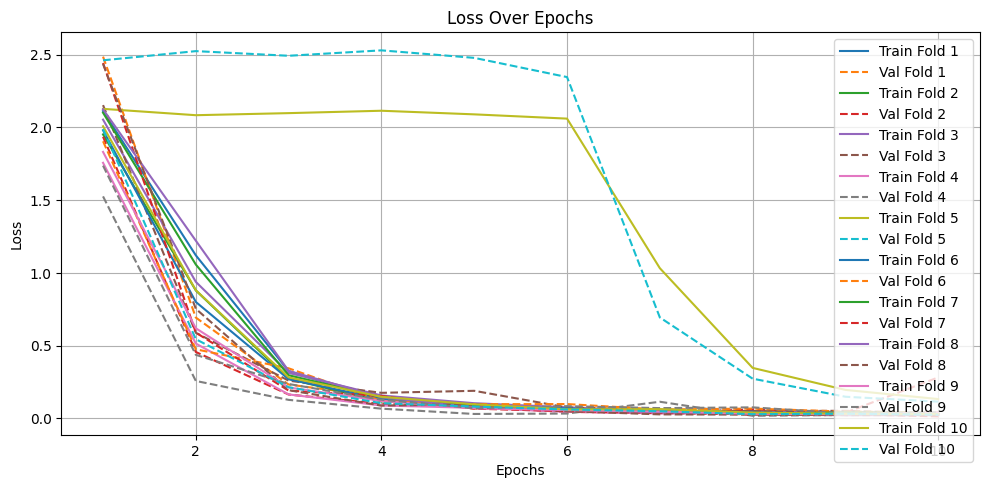

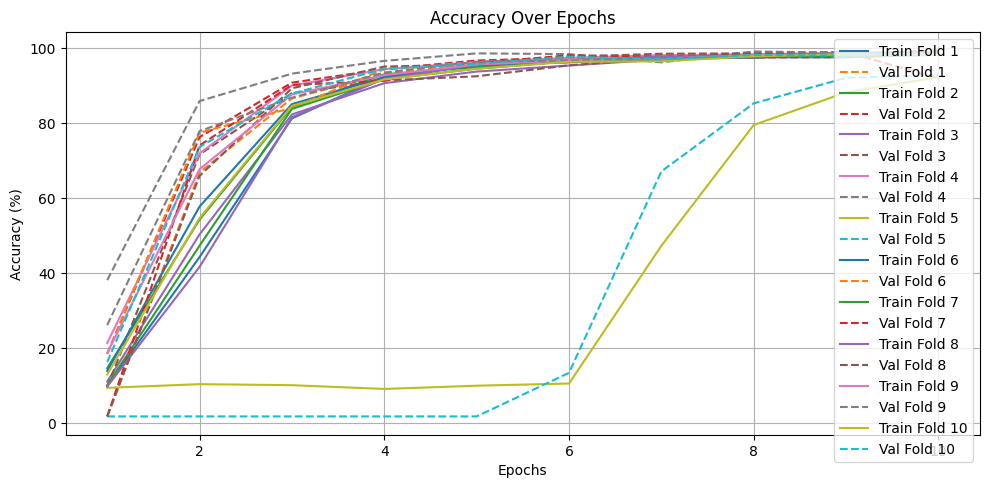

In [23]:
plot_cv_loss_accuracy(cv_history, num_epochs=10)


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_loss_accuracy(cv_history, num_epochs):
    # Convert list of lists → NumPy arrays for easy averaging
    train_loss_all = np.array(cv_history['train_loss'])  # Shape: (folds, epochs)
    val_loss_all   = np.array(cv_history['val_loss'])
    train_acc_all  = np.array(cv_history['train_acc'])
    val_acc_all    = np.array(cv_history['val_acc'])

    # Compute mean across folds
    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss   = np.mean(val_loss_all, axis=0)
    avg_train_acc  = np.mean(train_acc_all, axis=0)
    avg_val_acc    = np.mean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Average Accuracy Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


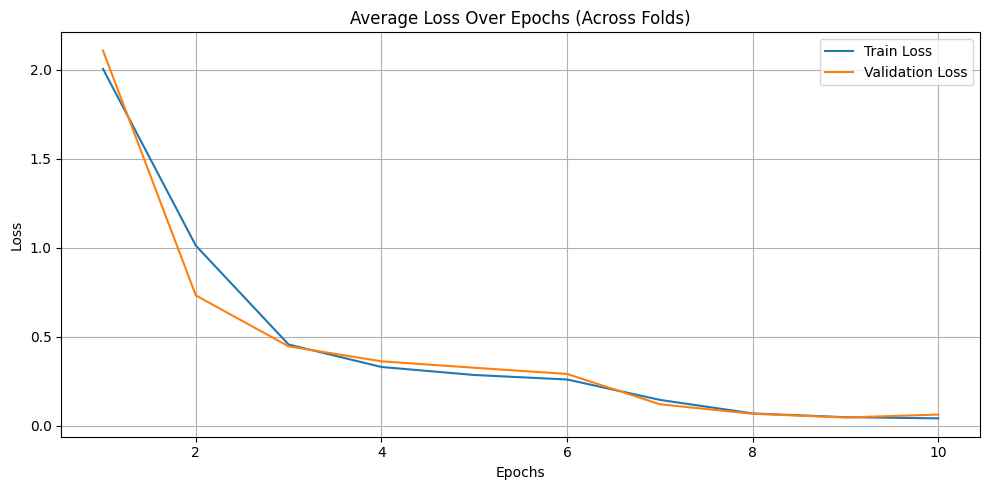

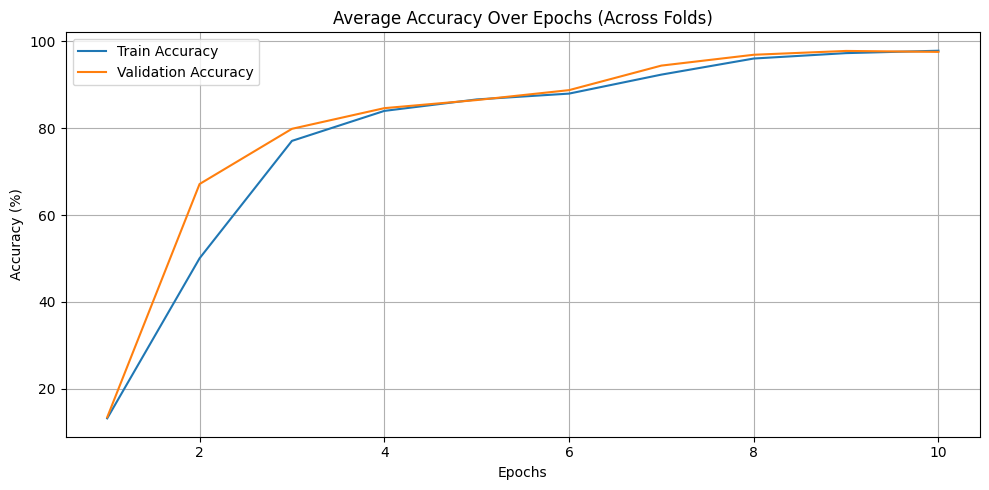

In [25]:
plot_avg_loss_accuracy(cv_history, num_epochs=10)


In [43]:
def print_per_fold_summary(cv_history):
    # Prepare data lists for each metric
    folds = []
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    val_macro_f1s = []

    num_folds = len(cv_history['train_acc'])

    for i in range(num_folds):
        folds.append(f"Fold {i+1}")
        train_accs.append(cv_history['train_acc'][i])
        val_accs.append(cv_history['val_acc'][i])
        train_losses.append(cv_history['train_loss'][i])
        val_losses.append(cv_history['val_loss'][i])
        val_macro_f1s.append(cv_history['val_f1_macro'][i])

    # Create DataFrame
    df_summary = pd.DataFrame({
        'Fold': folds,
        'Train Accuracy (%)': train_accs,
        'Val Accuracy (%)': val_accs,
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Val Macro F1': val_macro_f1s
    })

    # Format floats to 4 decimals
    df_summary = df_summary.round(4)

    print("=== Per-Fold Summary ===")
    print(df_summary)

    return df_summary

# Example usage after cross_validate_and_train finishes
df_per_fold_summary = print_per_fold_summary(cv_history)


=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.5531           98.5986      0.0314    0.0241   
1   Fold 2             98.6199           98.8989      0.0247    0.0241   
2   Fold 3             98.3306           98.9990      0.0369    0.0229   
3   Fold 4             98.7423           99.4995      0.0235    0.0141   
4   Fold 5             98.8983           99.2986      0.0212    0.0191   
5   Fold 6             98.4086           98.4970      0.0279    0.0437   
6   Fold 7             98.7425           98.6974      0.0221    0.0168   
7   Fold 8             98.8760           99.3988      0.0209    0.0173   
8   Fold 9             99.0763           98.5972      0.0178    0.0462   
9  Fold 10             98.6312           97.0942      0.0284    0.0768   

   Val Macro F1  
0        0.9891  
1        0.9924  
2        0.9903  
3        0.9963  
4        0.9931  
5        0.9850  
6        0.9909  
7        0.9949 

In [44]:
def evaluate_fold(model, val_loader, device, num_classes=10):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)  # logits
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate accuracy and macro F1
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

   
    cm = confusion_matrix(all_labels, all_preds)
    
    
    # === Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



    # ROC Curve plot
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, macro_f1


Best fold is fold 4

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9518    0.9954    0.9731       218
           1     0.9954    0.9908    0.9931       218
           2     0.9819    0.9954    0.9886       218
           3     0.9909    0.9954    0.9932       219
           4     1.0000    0.9761    0.9879       209
           5     0.9954    1.0000    0.9977       218
           6     0.9876    0.9876    0.9876       564
           7     1.0000    0.9907    0.9953       108
           8     1.0000    0.9833    0.9916       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9896      2496
   macro avg     0.9903    0.9915    0.9908      2496
weighted avg     0.9898    0.9896    0.9896      2496



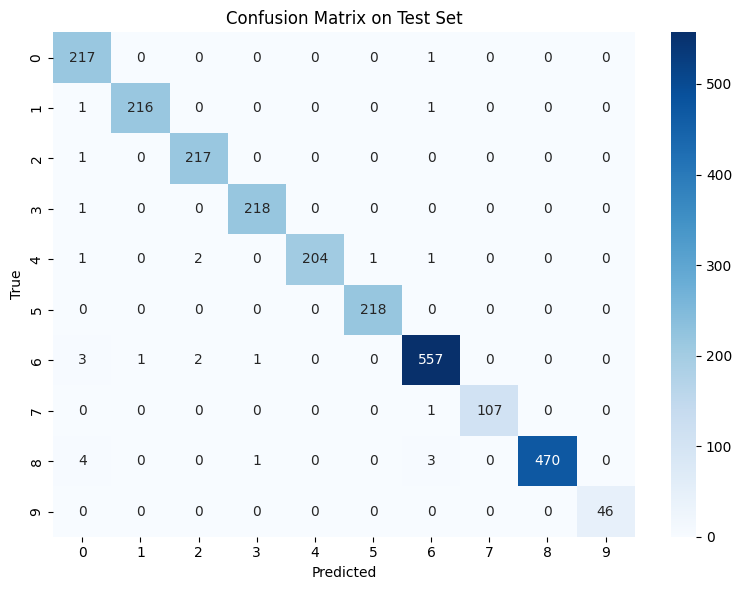

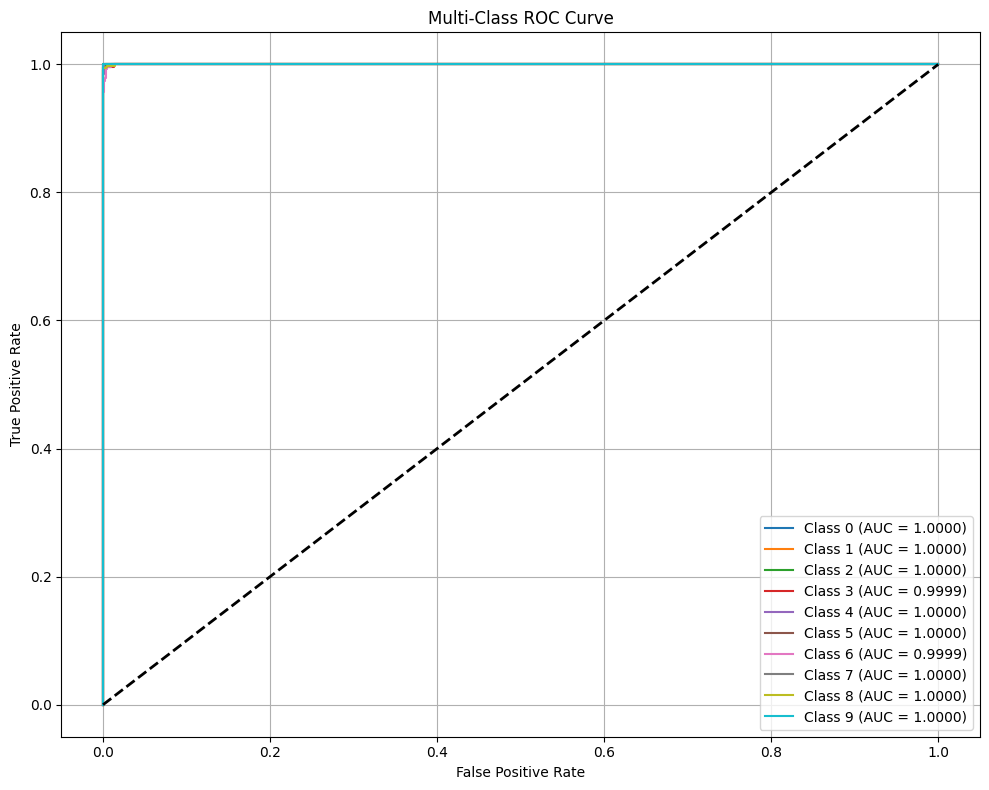

In [45]:
# After cross-validation training:
best_fold_idx = np.argmax(cv_history['val_f1_macro'])
print(f"Best fold is fold {best_fold_idx + 1}")

# Load best model weights
model = Dilated1DCNN_8192(num_classes=10).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold_idx + 1}.pth"))

# Evaluate on test set
test_dataset = STFTFlattenedDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
acc, macro_f1 = evaluate_fold(model, test_loader, device, num_classes=10)


## Attention-Augmented 1D CNN

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention1D(nn.Module):
    def __init__(self, channels, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (channels // heads) ** -0.5

        self.to_qkv = nn.Conv1d(channels, channels * 3, kernel_size=1, bias=False)
        self.to_out = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        # x: (batch, channels, length)
        b, c, l = x.size()
        qkv = self.to_qkv(x)  # (b, 3c, l)
        q, k, v = qkv.chunk(3, dim=1)  # each (b, c, l)

        # split heads
        q = q.view(b, self.heads, c // self.heads, l)
        k = k.view(b, self.heads, c // self.heads, l)
        v = v.view(b, self.heads, c // self.heads, l)

        attn = torch.einsum('bhcl,bhcm->bhlm', q, k) * self.scale  # (b, heads, l, l)
        attn = attn.softmax(dim=-1)

        out = torch.einsum('bhlm,bhcm->bhcl', attn, v)  # (b, heads, c//heads, l)
        out = out.contiguous().view(b, c, l)

        out = self.to_out(out)
        return out

class AttnAugmented1DCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.attn = SelfAttention1D(64, heads=4)
        self.pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.attn(x) + x  # residual connection
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)  # (batch, 256, 1)

        x = x.squeeze(-1)
        x = self.fc(x)
        return x


In [ ]:
# class DepthwiseSeparableConv1d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, padding=0, dilation=1):
#         super().__init__()
#         self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
#                                    padding=padding, dilation=dilation, groups=in_channels)
#         self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         x = self.depthwise(x)
#         x = self.pointwise(x)
#         return x

# class DepthwiseSeparable1DCNN(nn.Module):
#     def __init__(self, input_channels=1, num_classes=10):
#         super().__init__()
#         self.conv1 = DepthwiseSeparableConv1d(input_channels, 64, kernel_size=9, padding=4)
#         self.bn1 = nn.BatchNorm1d(64)
#         self.pool1 = nn.MaxPool1d(2)

#         self.conv2 = DepthwiseSeparableConv1d(64, 128, kernel_size=7, padding=3)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.pool2 = nn.MaxPool1d(2)

#         self.conv3 = DepthwiseSeparableConv1d(128, 256, kernel_size=5, padding=2)
#         self.bn3 = nn.BatchNorm1d(256)
#         self.pool3 = nn.AdaptiveAvgPool1d(1)

#         self.fc = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool1(x)

#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool2(x)

#         x = F.relu(self.bn3(self.conv3(x)))
#         x = self.pool3(x)

#         x = x.squeeze(-1)
#         x = self.fc(x)
#         return x


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
import torch
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
from tqdm import tqdm
import gc

class DataPrefetcher:
    def __init__(self, loader, device):
        self.loader = iter(loader)
        self.device = device
        self.stream = torch.cuda.Stream(device)
        self.next_input = None
        self.next_target = None
        self.preload()
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.to(self.device, non_blocking=True)
            self.next_target = self.next_target.to(self.device, non_blocking=True)
    
    def next(self):
        torch.cuda.current_stream(self.device).wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        self.preload()
        return input, target

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_prefetcher = DataPrefetcher(train_loader, device)

        X_batch, y_batch = train_prefetcher.next()
        batch_idx = 0
        pbar = tqdm(total=len(train_loader.dataset), desc=f"[Train] Epoch {epoch+1}/{num_epochs}")

        while X_batch is not None:
            optimizer.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

            pbar.update(X_batch.size(0))
            batch_idx += 1
            X_batch, y_batch = train_prefetcher.next()
        pbar.close()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        all_preds = []
        all_labels = []

        val_prefetcher = DataPrefetcher(val_loader, device)
        X_batch, y_batch = val_prefetcher.next()

        pbar_val = tqdm(total=len(val_loader.dataset), desc=f"[Val] Epoch {epoch+1}/{num_epochs}")
        while X_batch is not None:
            with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            pbar_val.update(X_batch.size(0))
            X_batch, y_batch = val_prefetcher.next()
        pbar_val.close()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        classwise_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(classwise_f1)

        # Save best model by macro F1
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
              f"Val Macro-F1={macro_f1:.4f}")

    return history

In [85]:

def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32, device='cuda'):
    from collections import defaultdict
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from sklearn.utils.class_weight import compute_class_weight

    cv_history = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print(f"\n=== Fold {fold + 1} ===")

        # Split data
        X_train = [X_trainval[i] for i in train_idx]
        y_train = [y_trainval[i] for i in train_idx]
        X_val = [X_trainval[i] for i in val_idx]
        y_val = [y_trainval[i] for i in val_idx]

        # Compute class weights and sampler
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
        sample_weights = [weight_map[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        # Datasets and loaders
        train_dataset = STFTFlattenedDataset(X_train, y_train)
        val_dataset = STFTFlattenedDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

        # Model setup
        model = AttnAugmented1DCNN(num_classes=10).to(device)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

        # Train & collect history
        history = train_model(model, train_loader, val_loader, criterion, optimizer,
                              device, num_epochs=num_epochs, fold=fold)

        for k in history:
            cv_history[k].append(history[k][-1])  # Append last epoch stat

        # Cleanup to prevent OOM
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return cv_history

In [ ]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
#     from torch.amp import autocast, GradScaler
#     scaler = GradScaler()
#     best_val_f1 = 0.0
#     best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

#     history = {
#         'train_loss': [], 'val_loss': [],
#         'train_acc': [], 'val_acc': [],
#         'val_f1_macro': [], 'val_classwise_f1': []
#     }

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct = 0.0, 0

#         for X_batch, y_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()

#             with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             train_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             train_correct += (preds == y_batch).sum().item()

#         train_loss /= len(train_loader.dataset)
#         train_acc = 100. * train_correct / len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss, val_correct = 0.0, 0
#         all_preds, all_labels = [], []

#         for X_batch, y_batch in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             val_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             val_correct += (preds == y_batch).sum().item()
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(y_batch.cpu().numpy())

#         val_loss /= len(val_loader.dataset)
#         val_acc = 100. * val_correct / len(val_loader.dataset)
#         macro_f1 = f1_score(all_labels, all_preds, average='macro')
#         classwise_f1 = f1_score(all_labels, all_preds, average=None)

#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['train_acc'].append(train_acc)
#         history['val_acc'].append(val_acc)
#         history['val_f1_macro'].append(macro_f1)
#         history['val_classwise_f1'].append(classwise_f1)

#         # Save best model by macro F1
#         if macro_f1 > best_val_f1:
#             best_val_f1 = macro_f1
#             torch.save(model.state_dict(), best_model_path)

#         print(f"Epoch {epoch+1}: "
#               f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
#               f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, "
#               f"Val Macro-F1={macro_f1:.4f}")

#     return history


In [86]:
# import torch
# import gc
# import numpy as np
# from collections import defaultdict
# from torch.utils.data import DataLoader, WeightedRandomSampler
# from sklearn.utils.class_weight import compute_class_weight

# def cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=32):
#     cv_history = defaultdict(list)

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#         print(f"\n=== Fold {fold + 1} ===")

#         # ======== Split Data ========
#         X_train = [X_trainval[i] for i in train_idx]
#         y_train = [y_trainval[i] for i in train_idx]
#         X_val   = [X_trainval[i] for i in val_idx]
#         y_val   = [y_trainval[i] for i in val_idx]

#         # ======== Class Weights & Sampler ========
#         class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#         weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#         sample_weights = [weight_map[y] for y in y_train]
#         sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#         # ======== Datasets & Loaders ========
#         train_dataset = STFTFlattenedDataset(X_train, y_train)
#         val_dataset   = STFTFlattenedDataset(X_val, y_val)

#         train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
#         val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         # ======== Model Setup ========
#         model = AttnAugmented1DCNN(num_classes=10).to(device)
#         class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#         criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
#         optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#         # ======== Train & Collect History ========
#         history = train_model(model, train_loader, val_loader, criterion, optimizer,
#                               device, num_epochs=num_epochs, fold=fold)

#         for k in history:
#             cv_history[k].append(history[k][-1])  # Append last epoch stat

#         # ======== Cleanup to Prevent OOM ========
#         del model
#         torch.cuda.empty_cache()
#         gc.collect()

#     return cv_history


In [87]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [88]:
import gc
torch.cuda.empty_cache()
gc.collect()


2894

In [91]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()


[Train] Epoch 1/10:   0%|          | 0/8985 [01:10<?, ?it/s]


4681

In [93]:
# Define Stratified KFold splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Run cross-validation training
# cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=16)

cv_history = cross_validate_and_train(X_trainval, y_trainval, skf, num_epochs=10, batch_size=8, device='cuda')



=== Fold 1 ===


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 7.67 GiB of which 2.58 GiB is free. Including non-PyTorch memory, this process has 4.96 GiB memory in use. Of the allocated memory 4.74 GiB is allocated by PyTorch, and 19.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)